# Installing Dependencies

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
import sklearn
import io
import cv2
import wandb
from wandb.keras import WandbCallback
import albumentations as A
from sklearn.metrics import confusion_matrix, roc_curve
import tensorflow_datasets as tfds
import tensorflow_probability as tfp 
from tensorflow.image import flip_left_right
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives,Precision ,Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.train import BytesList, FloatList, Int64List, Example, Features, Feature

from tensorboard.plugins.hparams import api as hp


In [1]:
# wandb installation

In [2]:
!pip install wandb

In [3]:
import wandb
from wandb.keras import WandbCallback

In [8]:
!wandb login

wandb: Currently logged in as: vasa_1410. Use `wandb login --relogin` to force relogin


In [12]:
wandb.init(project= "humans_emotion_detection", entity="vasa_1410")

Problem at: C:\Users\Vasanth M\AppData\Local\Temp\ipykernel_20092\1005149442.py 1 <module>


CommError: Run initialization has timed out after 60.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [16]:
train_directory = "D:/jupyter_codes/humans_emotion_detection/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "D:/jupyter_codes/humans_emotion_detection/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry", "happy","sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 5,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}


def explain()

# Dataset Loading


In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed= 99 

)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size= CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed= 99 

)

Found 2278 files belonging to 3 classes.


In [21]:
for i in val_dataset.take(1):
    print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

# Dataset Visualization

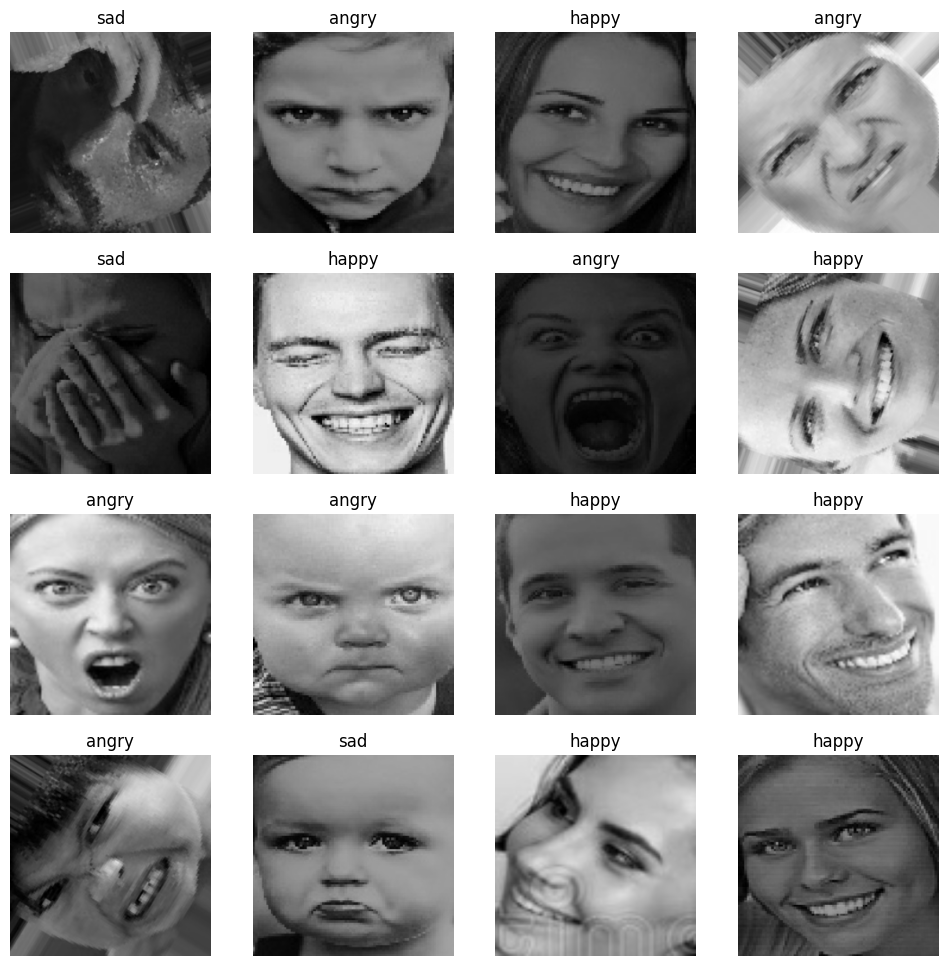

In [5]:
plt.figure(figsize = (12, 12))

for image, labels in train_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(image[i]/255.)
        plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
        plt.axis("off")

# Data Augmentation

In [10]:
# tf.keras.layer augment
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomContrast(factor = 0.1),
    RandomFlip(mode= "horizontal" , ),
])

In [11]:
def augment_layer(image, label):
    # image, label = resize_rescale(image, label)
    return augment_layers(image, training = True), label

Cutmix augmentation


In [7]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [8]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [85]:
train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [86]:

training_dataset = (
    mixed_dataset
    .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

# Dataset Preparation

In [12]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls =tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [13]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [9]:
training_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [10]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [14]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"] ),
    Rescaling(1.0/255 ),
])

# TFRecords

In [70]:
training_dataset = (
    training_dataset.unbatch()
)

In [71]:
validation_dataset = (
    validation_dataset.unbatch()
)

In [50]:
training_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [72]:
def create_example(image , label):

    bytes_feature = tf.train.Feature(
        bytes_list=tf.train.BytesList(value= [image]))

    int_feature = tf.train.Feature(
        int64_list=tf.train.Int64List(value= [label]))


    example = Example(
        features=Features(feature={
            'label': int_feature,
            'images': bytes_feature,
        }))
    
    return example.SerializeToString()

In [73]:
NUM_SHARDS = 10
PATH = "tfrecords/shard_{:02d}.tfrecord"

In [74]:
def encode_image(image, label):
    image = tf.image.convert_image_dtype(image, dtype= tf.uint8)
    image = tf.io.encode_jpeg(image)
    return image, tf.argmax(label)

In [75]:
encoded_dataset = (
    training_dataset
    .map(encode_image)
)

In [77]:
# Write the records to a file.
for shard_number in range(NUM_SHARDS):
    sharded_dataset = (
        encoded_dataset
        .shard(NUM_SHARDS, shard_number)
        .as_numpy_iterator()
    )
    with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
        for image , label in sharded_dataset:
            file_writer.write(create_example(image, label))

In [80]:
recons_dataset = tf.data.TFRecordDataset(
    filenames= [PATH.format(p) for p in range(NUM_SHARDS)]
)

In [81]:
def parse_tfrecords(example):
  
    feature_description = {
          "images": tf.io.FixedLenFeature([], tf.string),
          "labels": tf.io.FixedLenFeature([], tf.int64),
      }
    
    example = tf.io.parse_single_example(example, feature_description)
    example["images"] = tf.image.convert_image_dtype(
        tf.io.decode_jpeg(
        example["images"], channels = 3), dtype = tf.float32)

    return example["images"], example["labels"]
    

In [82]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [83]:
parsed_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Modelling

Lenet Model

In [13]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

ResNet34

In [15]:
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding = "valid"):
        super(CustomConv2D, self).__init__(name = "custom_conv2d")

        self.conv = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = "relu",
            strides = n_strides,
            padding = padding
        )

        self.batch_norm = BatchNormalization()

    def call(self, x , training = True):

        x = self.conv(x)
        x = self.batch_norm(x, training)

        return x

In [16]:
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides = 1):
        super(ResidualBlock,self).__init__(name = "res_block")

        self.dotted = (n_strides != 1)

        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding="same")
        self.custom_conv_2 = CustomConv2D(n_channels, 3,1, padding="same")

        self.activation = Activation("relu")

        if self.dotted:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
    def call(self, input, training):

        x = self.custom_conv_1(input, training)
        x = self.custom_conv_2(x, training)

        if self.dotted:
            x_add = self.custom_conv_3(input, training)
            x_add = Add()([x, x_add])

        else:
            x_add = Add()([x, input])

        return self.activation(x_add)


In [17]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')
    
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
    
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)
    
    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)
    
    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)
    
    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [18]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

Transfer learning with Efficient Net

In [19]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top= False,
    weights='imagenet',
    input_shape= (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3)
)

In [20]:
backbone.trainable = False

In [21]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    
    ])
pretrained_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 100)               179300    
                                                                 
 batch_normalization_36 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
 dense_3 (Dense)             (None, 3)                

Tranfer Learning with Mobile Net

In [ ]:
backbone = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

In [ ]:
backbone.trainable = False

In [ ]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    
    ])
pretrained_model.summary()

FineTuning EfficientNet





In [21]:
backbone.trainable = True

In [22]:
input  = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))
x = backbone(input, training = False)


x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)


In [23]:
finetuned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 100)               179300    
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 10)                1010  

# Vision Transformers

Patch Encoder

In [ ]:
test_image = cv2.imread("C:/Users/Vasanth M/jupyter_codes/humans_emotion_detection/dataset/EmotionsDataset/data/happy/4.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))

In [ ]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [ ]:
print(patches.shape)
patches = tf.image.extract_patches(
    images=tf.expand_dims(test_image, axis =0),
    sizes = [1, CONFIGURATION["PATCH_SIZE"],CONFIGURATION["PATCH_SIZE"],1],
    strides= [1, CONFIGURATION["PATCH_SIZE"],CONFIGURATION["PATCH_SIZE"],1],
    rates = [1,1,1,1],
    padding= "valid"
)

In [ ]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(pacthes.shape)

In [ ]:
plt.figure(figsize= (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16, 16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

In [ ]:
class PatchEncoder(Layer):
    def __init__(self, N_PATCHES, HIDDEN_SIZE):
        super(PatchEncoder, self).__init__(name = "patch_encoder")

        self.linear_projection = Dense(HIDDEN_SIZE)
        self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE)
        self.N_PATCHES = N_PATCHES

        def call(self, x):

            patches = tf.image.extract_patches(
                    images=x,
                    sizes=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                    strides=[1, CONFIGURATION["PATCH_SIZE"], CONFIGURATION["PATCH_SIZE"], 1],
                    rates=[1, 1, 1, 1],
                    padding='VALID')
            
            patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

            embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta=1)
            output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

            return output


TransformerEncoder

In [ ]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()
    
    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )
    
    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    
  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

ViT Model


In [ ]:

class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)
    
    return self.dense_3(x)


In [ ]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

In [ ]:
vit.summary()


Hugging face ViT

In [1]:
!pip install transformers

In [9]:
resize_rescale_hf = tf.keras.Sequential([
    Resizing(224, 224 ),
    Rescaling(1.0/255 ),
])

In [26]:
from transformers import ViTFeatureExtractor, TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (3, 256, 256))
x = resize_rescale_hf(inputs)
x = base_model.vit(inputs)

hf_model = tf.keras.Model(inputs = inputs, outputs = x)

All model checkpoint layers were used when initializing TFViTModel.

All the layers of TFViTModel were initialized from the model checkpoint at google/vit-base-patch16-224-in21k.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


ValueError: Exception encountered when calling layer "vit" (type TFViTMainLayer).

in user code:

    File "c:\Users\Vasanth M\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\modeling_tf_utils.py", line 506, in run_call_with_unpacked_inputs  *
        return func(self, **unpacked_inputs)
    File "c:\Users\Vasanth M\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 503, in call  *
        embedding_output = self.embeddings(
    File "c:\Users\Vasanth M\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Vasanth M\AppData\Local\Temp\__autograph_generated_file3qoo_6x8.py", line 30, in tf__call
        ag__.if_stmt(ag__.ld(interpolate_pos_encoding), if_body, else_body, get_state, set_state, ('embeddings',), 1)
    File "C:\Users\Vasanth M\AppData\Local\Temp\__autograph_generated_file3qoo_6x8.py", line 29, in else_body
        embeddings = ag__.ld(embeddings) + ag__.ld(self).position_embeddings

    ValueError: Exception encountered when calling layer 'embeddings' (type TFViTEmbeddings).
    
    in user code:
    
        File "c:\Users\Vasanth M\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\vit\modeling_tf_vit.py", line 136, in call  *
            embeddings = embeddings + self.position_embeddings
    
        ValueError: Dimensions must be equal, but are 257 and 197 for '{{node vit/embeddings/add}} = AddV2[T=DT_FLOAT](vit/embeddings/concat, vit/embeddings/add/ReadVariableOp)' with input shapes: [?,257,768], [1,197,768].
    
    
    Call arguments received by layer 'embeddings' (type TFViTEmbeddings):
      • pixel_values=tf.Tensor(shape=(None, 3, 256, 256), dtype=float32)
      • interpolate_pos_encoding=None
      • training=False


Call arguments received by layer "vit" (type TFViTMainLayer):
  • self=tf.Tensor(shape=(None, 3, 256, 256), dtype=float32)
  • pixel_values=None
  • head_mask=None
  • output_attentions=None
  • output_hidden_states=None
  • interpolate_pos_encoding=None
  • return_dict=None
  • training=False

In [23]:
test_image = cv2.imread("D:/jupyter_codes/humans_emotion_detection/dataset/EmotionsDataset/data/happy/4.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))


In [24]:
hf_model(tf.expand_dims(test_image, axis =0))

ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 3, 224, 224), found shape=(1, 256, 256, 3)

# Training

In [22]:
n_sample_0 = 1525 #angry
n_sample_1 = 3019 #happy
n_sample_2 = 2255 #sad

In [23]:
class_weights = {
    0 : 6799/n_sample_0,
    1 : 6799/n_sample_1,
    2 : 6799/n_sample_2
}

In [24]:
checkpoint_callback = ModelCheckpoint(
    'best_weights', 
    monitor='val_accuracy',
    mode = 'max',
    verbose=1, 
    save_best_only=True,
    
    )

In [ ]:
class LogConfMatrix(Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in validation_dataset:
      predicted.append(hf_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])
    
    cm = wandb.plot.confusion_matrix(
        y_true=lab,
        preds=pred,
        class_names=CONFIGURATION["CLASS_NAMES"])
        
    wandb.log({"conf_mat": cm})

In [25]:
loss_function = CategoricalCrossentropy(from_logits= False)
# loss_function = SparseCategoricalCrossentropy()


In [26]:
metrics = [CategoricalAccuracy(name ="accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [27]:
pretrained_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [26]:
history = pretrained_model.fit(
    training_dataset,
    validation_data= validation_dataset,
    epochs= 1,
    class_weight= class_weights
    verbose = 1,
    # callbacks= [checkpoint_callback]
)

213/213 [==============================] - 959s 5s/step - loss: 0.5740 - accuracy: 0.7525 - top_k_accuracy: 0.9257 - val_loss: 0.5586 - val_accuracy: 0.7665 - val_top_k_accuracy: 0.9346


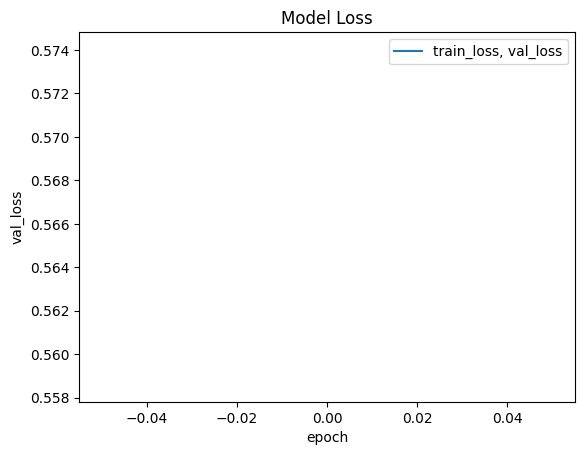

In [27]:

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("epoch")
plt.ylabel("val_loss")
plt.legend(["train_loss, val_loss"])
plt.show()

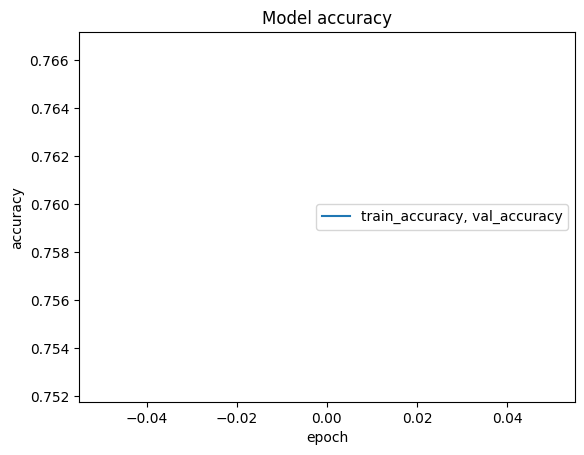

In [28]:

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train_accuracy, val_accuracy"])
plt.show()

# Ensembling

In [ ]:
inputs = Input(shape= (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

y_1 = resnet_34(inputs)
y_2 = pretrained_model(inputs)

output = 0.5*y_1+0.5*y_2

ensemble_model = Model(inputs = inputs, outputs = output)


# Evaluation

In [35]:
resnet_34.load_weights("best_weights")

AssertionError: Nothing except the root object matched a checkpointed value. Typically this means that the checkpoint does not match the Python program. The following objects have no matching checkpointed value: [<tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_2/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_11/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_36/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_33/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.14882030e-02, -1.17681958e-02, -2.03075372e-02, ...,
           1.27228089e-02,  1.35386735e-03,  8.55340436e-03],
         [-1.63083021e-02,  1.37305446e-02,  1.47406012e-04, ...,
           2.95340456e-03,  8.60777870e-03, -1.46521404e-02],
         [-1.98648125e-02, -6.70308247e-04,  2.21700780e-02, ...,
           2.27118917e-02,  5.82342967e-04,  2.22559758e-02],
         ...,
         [ 3.66317108e-03, -6.55652583e-03, -2.13353653e-02, ...,
           2.02644803e-02,  1.01576708e-02,  6.94089383e-03],
         [ 4.25944477e-03,  2.04315819e-02,  5.57658635e-03, ...,
          -2.20260601e-02,  1.89019069e-02,  1.43464096e-02],
         [-8.20082612e-03, -3.40322219e-03,  1.87223479e-02, ...,
           1.11040547e-02,  6.54553995e-03, -9.67882946e-03]],

        [[ 1.16982125e-03,  2.47548670e-02,  3.39374319e-03, ...,
          -2.45009884e-02,  1.83127746e-02, -7.13669695e-03],
         [ 1.23326853e-02,  1.47445239e-02,  7.80888647e-03, ...,
           2.50235386e-02, -4.49044257e-03,  2.25113295e-02],
         [ 2.33770981e-02, -1.27917109e-02,  1.03652738e-02, ...,
          -1.99321508e-02, -7.89943151e-03, -4.51263413e-03],
         ...,
         [ 2.04401724e-02, -1.54239126e-03, -8.74398649e-03, ...,
          -1.71872284e-02,  1.16277561e-02,  2.23138705e-02],
         [-5.90834953e-03,  2.37407982e-02,  3.44633497e-03, ...,
           1.37814619e-02, -7.49292783e-03,  8.26036930e-03],
         [-6.67566247e-03, -1.94058716e-02, -5.58254868e-03, ...,
           2.48754323e-02,  1.84479281e-02, -1.39204320e-02]],

        [[-9.04014334e-03,  1.76275559e-02,  6.83545694e-03, ...,
          -2.28209235e-03, -9.91282705e-03, -2.32752562e-02],
         [-2.04848237e-02,  1.55397467e-02, -1.86330527e-02, ...,
          -4.33148816e-04, -4.62387502e-03,  2.44202092e-02],
         [ 8.21419060e-04, -2.17138175e-02, -9.09289718e-03, ...,
           2.23512836e-02,  9.79674608e-03,  1.03318132e-03],
         ...,
         [-1.51975760e-02, -9.21785645e-03, -1.54006444e-02, ...,
           1.23328231e-02, -1.49709461e-02, -4.97025624e-03],
         [-6.03092834e-03,  4.05784138e-03, -6.90500066e-03, ...,
           2.32768618e-02,  1.12204179e-02,  1.15191042e-02],
         [ 7.30441511e-03,  1.03735030e-02, -1.62930526e-02, ...,
          -2.49402579e-02,  1.98777579e-02, -1.70406140e-02]]],


       [[[-3.75165232e-03, -9.39238816e-03, -7.56042264e-03, ...,
          -1.16435774e-02,  1.74322836e-02,  2.12953314e-02],
         [ 6.83826581e-03, -8.81783292e-03,  1.17439516e-02, ...,
           1.26710162e-02, -1.04310634e-02,  2.27779821e-02],
         [-1.88506786e-02,  1.82288736e-02, -2.23784149e-02, ...,
          -1.69582870e-02, -4.20421362e-03,  1.03507154e-02],
         ...,
         [-1.45231849e-02,  8.70187581e-03,  1.22176707e-02, ...,
          -1.62322000e-02,  1.77117549e-02, -1.96803231e-02],
         [-2.26256065e-02,  6.16161153e-04, -1.16325114e-02, ...,
          -6.60210848e-04,  8.29971209e-03,  1.63401775e-02],
         [-1.26775503e-02, -5.68648800e-04,  9.31431353e-03, ...,
           8.78069550e-05, -2.86513567e-03,  1.28593147e-02]],

        [[ 6.85811043e-03, -2.33826395e-02,  6.01407140e-03, ...,
          -2.00399775e-02,  4.31611203e-03, -5.44745475e-03],
         [ 1.22509301e-02,  9.16526467e-03,  2.39175260e-02, ...,
           1.40901580e-02,  7.90662318e-03, -2.23068986e-02],
         [-1.14355078e-02,  1.23854689e-02, -1.59531906e-02, ...,
          -8.14163499e-03,  8.72644037e-03,  2.25681625e-02],
         ...,
         [ 2.17891894e-02,  1.70281678e-02,  2.01857835e-02, ...,
           1.77199580e-03,  1.04113854e-02,  6.03596494e-03],
         [ 1.74228251e-02, -1.50691923e-02, -1.16013894e-02, ...,
          -1.83704570e-02,  1.39975995e-02, -2.19542198e-02],
         [ 1.77203491e-02,  1.58162601e-02,  1.05677359e-03, ...,
           1.22046769e-02,  2.48246193e-02,  1.96690485e-02]],

        [[ 1.19179003e-02, -2.11931542e-02,  1.69457532e-02, ...,
           7.98872858e-03, -3.57263722e-03, -1.49139995e-02],
         [ 1.72795728e-03, -2.01081410e-02, -5.56601956e-03, ...,
          -2.34087557e-03, -1.63376182e-02, -8.67597945e-03],
         [ 1.19821541e-02,  2.13725157e-02,  1.42036267e-02, ...,
          -2.04486344e-02, -1.99012775e-02, -1.92186497e-02],
         ...,
         [-1.25756534e-02, -2.81831063e-03,  2.41154134e-02, ...,
          -3.02534737e-03,  2.44471207e-02, -2.09562313e-02],
         [-5.37570193e-03,  2.19184086e-02,  2.02408507e-02, ...,
           2.51089968e-03,  1.85910463e-02,  5.58797456e-03],
         [-1.06451008e-02, -1.41406134e-02, -1.14720445e-02, ...,
           1.16623193e-03,  1.21184699e-02,  1.98268108e-02]]],


       [[[ 4.29711305e-03, -1.81737803e-02,  3.79198045e-03, ...,
          -1.07151577e-02,  1.00941435e-02,  1.18024684e-02],
         [ 2.26412043e-02, -1.69577934e-02,  2.23665163e-02, ...,
           1.87863819e-02,  1.43261030e-02, -6.71334937e-03],
         [-7.79121928e-03,  1.92691237e-02, -8.20380077e-03, ...,
           1.58296376e-02, -1.92493163e-02,  2.30785571e-02],
         ...,
         [ 6.73083588e-04,  1.60763599e-02,  7.81605765e-03, ...,
           1.12751909e-02, -6.86192326e-03,  3.40207852e-03],
         [-2.23650560e-02, -2.49144826e-02, -5.35577163e-03, ...,
           4.87345085e-03,  1.91831216e-03,  2.39511244e-02],
         [-2.05349512e-02, -2.43771318e-02, -1.29726855e-02, ...,
           2.52073482e-02, -7.21354038e-04, -9.70169902e-04]],

        [[-1.43500585e-02, -1.35255242e-02, -8.70153308e-04, ...,
           8.47201049e-03,  7.29270652e-03, -6.22319989e-03],
         [-2.06741393e-02, -4.55107540e-03,  7.98635185e-03, ...,
          -1.15060266e-02, -1.14611555e-02, -1.53732514e-02],
         [-1.44487992e-03,  6.70106709e-03, -2.13064626e-02, ...,
          -2.35011429e-02,  9.49471816e-03, -3.26590240e-03],
         ...,
         [-8.86056758e-03,  1.09632313e-02,  3.39606777e-03, ...,
           2.99921259e-03, -1.24119688e-02,  5.68296760e-04],
         [-9.24592465e-03,  1.78719349e-02, -9.32724215e-03, ...,
          -2.44184323e-02, -9.96336807e-03,  6.47801906e-03],
         [ 2.92403623e-04,  2.28677243e-02, -2.08102670e-02, ...,
          -1.20894583e-02,  8.92280787e-03, -1.19942836e-02]],

        [[ 2.02146806e-02, -9.11820494e-03,  2.29749754e-02, ...,
           7.72358477e-03, -1.87486000e-02, -1.06256586e-02],
         [-2.16925927e-02, -8.32760334e-03, -1.62078589e-02, ...,
           9.95958969e-03,  1.82090513e-02,  1.85954385e-02],
         [ 2.50500441e-02,  2.12888569e-02,  1.49314143e-02, ...,
          -4.71803918e-03,  1.77432075e-02,  1.88792869e-02],
         ...,
         [ 1.36245675e-02, -2.00298671e-02, -1.37392431e-03, ...,
           1.80373676e-02,  5.42467274e-03,  1.67553127e-03],
         [-1.04079107e-02, -1.21967997e-02, -2.48807017e-02, ...,
           1.84524059e-02,  2.26169489e-02,  1.38841569e-02],
         [-1.52492356e-02, -1.42550543e-02, -1.26636494e-02, ...,
           1.61488876e-02,  1.20039061e-02, -1.01380637e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_22/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_7/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_3/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_5/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_21/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_19/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 0.0195462 , -0.0230498 ,  0.0202994 , ..., -0.0102278 ,
           0.01464341,  0.02583996],
         [ 0.02355682,  0.02935275, -0.00777322, ..., -0.00829624,
          -0.01555327, -0.00102973],
         [-0.03530376,  0.01007641, -0.01284393, ..., -0.02808735,
           0.02769821,  0.03056882],
         ...,
         [ 0.01309676, -0.02745057, -0.01416727, ..., -0.0308476 ,
           0.02798945,  0.03317206],
         [ 0.00822605,  0.01037043,  0.01609159, ..., -0.0067007 ,
           0.00341198,  0.01458183],
         [ 0.02807289, -0.00966645,  0.02218884, ..., -0.0241571 ,
          -0.00627459, -0.02136613]],

        [[ 0.00773912,  0.02717716, -0.0163483 , ...,  0.01369005,
           0.0292125 , -0.02751492],
         [-0.0238479 ,  0.00233768, -0.00333651, ..., -0.01258197,
          -0.00099491, -0.00226004],
         [-0.00158347, -0.01141605,  0.02932996, ...,  0.01189026,
           0.02272972, -0.02782671],
         ...,
         [-0.00827778, -0.00928109, -0.0274236 , ..., -0.02152342,
           0.02386167, -0.00497499],
         [ 0.00482653, -0.0159248 ,  0.03439928, ...,  0.0081717 ,
          -0.03193109,  0.03137679],
         [-0.02836311, -0.02256121, -0.01414967, ...,  0.00027017,
          -0.0156131 , -0.02205267]],

        [[ 0.03182615,  0.03292837, -0.03308062, ...,  0.00325992,
          -0.00597454, -0.01498199],
         [-0.02096011, -0.01129539,  0.03253812, ...,  0.0324523 ,
          -0.0072283 ,  0.0214205 ],
         [-0.00665224,  0.00225262, -0.01642503, ..., -0.02152151,
           0.02590417, -0.0331905 ],
         ...,
         [-0.03088763, -0.02977928, -0.00112673, ..., -0.00347836,
          -0.01487357, -0.02279128],
         [ 0.00944041, -0.03130794,  0.02049498, ...,  0.03319295,
           0.01050423,  0.01323383],
         [ 0.00223006,  0.02503729, -0.02411673, ...,  0.01592544,
          -0.01832522, -0.00588705]]],


       [[[-0.01718793, -0.01473246, -0.03606225, ...,  0.03438424,
          -0.01464862, -0.01093813],
         [-0.00554375, -0.0178702 ,  0.01069537, ..., -0.00183684,
           0.01950041,  0.02621754],
         [ 0.02883659,  0.02458616, -0.02924266, ..., -0.01464884,
           0.00881982,  0.01680663],
         ...,
         [-0.00409039, -0.02446173, -0.00099462, ..., -0.02534111,
           0.02292552, -0.00846601],
         [ 0.03565151, -0.02239187,  0.02375391, ...,  0.01381414,
           0.0267137 ,  0.01676514],
         [-0.00534986,  0.02481185, -0.0346796 , ...,  0.00508217,
           0.03378729, -0.01377581]],

        [[-0.02044594,  0.01058267, -0.01858575, ..., -0.02806982,
          -0.02758796,  0.03535756],
         [-0.02893106, -0.02283156,  0.01303006, ...,  0.00989912,
           0.03066155, -0.01066492],
         [ 0.00252856, -0.03249322, -0.02674857, ...,  0.03104145,
          -0.03222758, -0.02161735],
         ...,
         [-0.03496648, -0.0085678 , -0.00484547, ..., -0.01037885,
           0.01024264,  0.00809959],
         [ 0.0076743 ,  0.03563543, -0.01144699, ..., -0.01936357,
           0.00203749, -0.00460759],
         [-0.03240804, -0.00366562,  0.02477154, ...,  0.03450564,
          -0.03187449, -0.01557008]],

        [[ 0.01069323,  0.00668642, -0.01943825, ...,  0.01464498,
          -0.00536436,  0.01465511],
         [ 0.00980501,  0.03139744,  0.03470416, ...,  0.00225867,
           0.02076029, -0.03264948],
         [ 0.02743194, -0.01630556, -0.0119861 , ..., -0.00187848,
          -0.02158003, -0.00536424],
         ...,
         [ 0.00660174,  0.03199779,  0.0176028 , ..., -0.02815058,
           0.02754916, -0.03546554],
         [ 0.00466178, -0.00632926, -0.00733795, ...,  0.01575171,
          -0.02003415, -0.01987863],
         [ 0.01994563,  0.01285063, -0.02560782, ..., -0.01023109,
          -0.01337588, -0.02886502]]],


       [[[ 0.03309365, -0.00892355, -0.01284846, ...,  0.02852575,
           0.03563388, -0.02928024],
         [ 0.03467493, -0.00127299,  0.01112032, ...,  0.01835086,
           0.01454632, -0.01846491],
         [ 0.02006197,  0.03379603,  0.00756512, ...,  0.01355442,
           0.01981537, -0.03490163],
         ...,
         [-0.01170901,  0.03209531, -0.0259762 , ..., -0.00891939,
          -0.01913542, -0.02153179],
         [ 0.02082669,  0.02364013, -0.02779807, ...,  0.01988191,
          -0.02051565,  0.00762501],
         [-0.03018732, -0.01738539,  0.00517326, ..., -0.01430111,
           0.02141175, -0.03400313]],

        [[-0.03122955, -0.03034589,  0.00823586, ..., -0.0011029 ,
          -0.01626748,  0.01692487],
         [ 0.03460678,  0.02855679,  0.0320922 , ...,  0.01012982,
           0.00713158,  0.03457798],
         [ 0.01456108, -0.00171481, -0.02684087, ...,  0.03161161,
          -0.02722494,  0.0158909 ],
         ...,
         [ 0.02291111, -0.03595421, -0.00846026, ..., -0.02467157,
          -0.02812875,  0.0118146 ],
         [-0.00554933,  0.00908143,  0.02213787, ..., -0.03479113,
          -0.01375864, -0.01904867],
         [ 0.02604192, -0.02314697,  0.01943583, ..., -0.03236781,
          -0.02263319, -0.03603742]],

        [[ 0.03572201, -0.03206632,  0.03163707, ..., -0.01390873,
          -0.03447437,  0.02106591],
         [-0.01361518,  0.03262521, -0.01073823, ..., -0.00958262,
          -0.01569433,  0.00376295],
         [ 0.00945708,  0.00617195,  0.03575703, ..., -0.03190572,
           0.0302303 ,  0.01268391],
         ...,
         [ 0.00160642,  0.03255633,  0.02981944, ..., -0.00363954,
          -0.0305852 ,  0.02322812],
         [ 0.01869992, -0.01073985,  0.00312132, ...,  0.03145634,
          -0.01746036,  0.00812473],
         [-0.03430199,  0.0096649 ,  0.00583139, ...,  0.02652981,
          -0.00168816,  0.01033166]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_27/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_14/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_33/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_23/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_6/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_13/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_29/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_7/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_21/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_36/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_6/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_8/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-3.55260260e-02,  1.23854727e-02, -3.56595591e-02, ...,
          -4.58868779e-02, -4.60646823e-02, -3.36486101e-03],
         [-3.40212211e-02,  1.40078962e-02, -5.06837852e-02, ...,
          -3.47590744e-02,  1.78241357e-02,  3.57674062e-02],
         [-8.48078355e-03,  3.09165418e-02, -2.88134981e-02, ...,
          -1.82614103e-02,  3.52031961e-02,  1.30044743e-02],
         ...,
         [ 1.56308264e-02, -3.96984182e-02, -2.78817937e-02, ...,
           3.01178619e-02, -1.75690278e-02,  1.01364702e-02],
         [-4.48290370e-02, -2.21377984e-02,  2.55298987e-02, ...,
          -6.23634458e-03,  4.70414013e-02,  2.56517753e-02],
         [-1.52669549e-02,  2.21491382e-02,  4.94466200e-02, ...,
           2.46214569e-02,  3.02311927e-02,  4.05753404e-02]],

        [[-1.35602914e-02,  3.36187333e-02, -3.30335647e-03, ...,
           2.92341411e-02, -2.68357210e-02, -3.59624363e-02],
         [ 2.59780511e-02,  4.28811684e-02, -4.79839370e-03, ...,
          -3.64774838e-03, -8.03808495e-03,  1.14313513e-02],
         [ 4.52060625e-02,  1.97168365e-02,  1.06716380e-02, ...,
          -3.83355841e-03,  2.03015208e-02,  5.04123047e-03],
         ...,
         [ 1.84976682e-02, -4.85410541e-03,  6.08281419e-03, ...,
           5.93483448e-04, -3.70822772e-02,  1.05755813e-02],
         [-2.44958121e-02, -9.37546417e-03,  4.57193702e-03, ...,
           5.74432313e-03,  2.01518685e-02, -4.58522364e-02],
         [-3.66982333e-02, -2.81056259e-02, -4.02022563e-02, ...,
          -1.04343593e-02, -1.77397281e-02,  4.07512709e-02]],

        [[ 1.04384609e-02,  2.81355083e-02, -3.43263857e-02, ...,
           1.82544291e-02,  1.55248940e-02, -6.01426512e-03],
         [ 3.40489075e-02, -4.43235040e-05, -1.78234354e-02, ...,
          -7.24552944e-03, -4.96587493e-02, -1.55005343e-02],
         [-4.45424765e-02,  4.85429764e-02, -2.96772029e-02, ...,
          -4.84458581e-02,  2.38351077e-02, -4.94517200e-02],
         ...,
         [-2.85789110e-02, -1.99862197e-02, -1.62920170e-02, ...,
          -1.99558269e-02,  5.03858626e-02,  2.17844546e-03],
         [ 2.25976780e-02, -3.00670993e-02, -3.08777932e-02, ...,
          -3.12995687e-02,  3.14339250e-02, -1.19712166e-02],
         [-1.41155571e-02,  4.30891216e-02,  4.87762094e-02, ...,
          -1.41490400e-02,  1.40188038e-02, -2.57778168e-03]]],


       [[[-6.67297468e-03, -2.25021075e-02, -1.78522095e-02, ...,
          -2.92659067e-02,  2.22868919e-02, -4.03753668e-03],
         [-3.95786129e-02,  1.03576854e-02,  3.80950272e-02, ...,
           1.53599009e-02,  3.12107354e-02, -3.52830440e-02],
         [-4.27870080e-02, -3.88900600e-02, -5.20345196e-03, ...,
          -2.32554004e-02, -3.05318087e-02,  1.37838274e-02],
         ...,
         [-3.69266644e-02,  3.83183658e-02, -2.43977960e-02, ...,
           5.86267561e-04, -2.38938015e-02, -2.71377731e-02],
         [-5.07758521e-02,  2.48864889e-02,  1.52707919e-02, ...,
           2.56581381e-02,  2.66032517e-02, -3.78566049e-02],
         [ 3.43803093e-02,  4.09051925e-02,  1.70383230e-02, ...,
          -4.84864116e-02, -4.60928679e-03, -4.55369353e-02]],

        [[ 7.58162513e-03, -3.87497619e-03, -3.84932309e-02, ...,
          -9.81184840e-03,  3.05549502e-02, -4.48469222e-02],
         [ 3.73081863e-02,  3.81107032e-02, -2.71123685e-02, ...,
           3.55935395e-02, -1.91404596e-02,  1.46250725e-02],
         [ 8.26886296e-03,  2.40489095e-03, -6.82275742e-03, ...,
          -2.27159504e-02,  4.69104275e-02, -4.65854071e-02],
         ...,
         [ 4.34942096e-02,  3.70403826e-02, -4.62152213e-02, ...,
          -1.16786361e-03,  3.45327482e-02,  4.22469378e-02],
         [-3.93197387e-02, -4.86950353e-02,  4.06744257e-02, ...,
          -8.64536315e-03, -1.36498138e-02, -3.32849249e-02],
         [ 1.00166537e-02, -3.94248962e-02,  4.56208959e-02, ...,
           1.21376291e-02, -4.59704846e-02, -6.43775612e-03]],

        [[ 3.29264328e-02,  4.49705496e-02, -1.98264569e-02, ...,
          -1.68189108e-02,  6.01060316e-03, -2.75005475e-02],
         [-2.11704448e-02,  9.42204148e-04, -1.86030194e-02, ...,
           5.44302166e-04, -2.40356661e-02, -9.01757926e-03],
         [ 3.55992243e-02,  1.09854788e-02, -4.21203300e-02, ...,
           7.60808587e-03, -3.24078724e-02, -3.34859788e-02],
         ...,
         [ 3.67880985e-02,  2.41662040e-02,  3.98048013e-02, ...,
           2.94038653e-02,  1.26584694e-02,  2.73738280e-02],
         [ 1.05032474e-02, -1.85319036e-02,  3.61802951e-02, ...,
          -3.03096063e-02, -2.39442661e-03,  3.23004127e-02],
         [-7.58513808e-03, -2.78591998e-02,  1.85528398e-02, ...,
           1.19362622e-02,  4.54701260e-02,  4.08459604e-02]]],


       [[[-3.08979657e-02,  8.55204463e-03,  3.73427942e-03, ...,
          -8.42772424e-05, -1.54367425e-02, -5.03123105e-02],
         [-3.82895693e-02, -2.35255379e-02,  1.29421577e-02, ...,
          -1.51977874e-02,  2.71727145e-03, -4.70405743e-02],
         [-4.48271036e-02,  9.63315740e-03,  4.78797182e-02, ...,
          -3.65998894e-02, -5.79471886e-03,  3.06331962e-02],
         ...,
         [ 4.71115559e-02,  4.73589078e-02, -1.09770894e-03, ...,
          -3.87494601e-02,  4.48819399e-02, -1.64403282e-02],
         [-1.09789148e-03,  3.80585566e-02, -4.34239991e-02, ...,
           2.01150402e-02, -3.53780426e-02, -3.78388539e-02],
         [ 1.30201951e-02,  1.75769627e-02, -3.96482050e-02, ...,
          -3.13308463e-03, -2.11391766e-02, -4.53587547e-02]],

        [[-2.76531316e-02, -4.29930985e-02, -5.02460040e-02, ...,
           1.28107443e-02, -7.87209347e-03, -2.82806065e-02],
         [ 3.82999256e-02, -4.92687449e-02,  1.65273324e-02, ...,
           8.50936398e-03, -4.43398952e-03,  6.67288899e-03],
         [ 2.21698210e-02,  4.15965915e-05,  2.54862458e-02, ...,
          -4.84778471e-02, -3.70552279e-02, -4.85579260e-02],
         ...,
         [ 2.82393768e-02,  1.96933150e-02, -3.49050462e-02, ...,
          -1.08816698e-02,  2.92476788e-02, -3.15906331e-02],
         [-4.49505486e-02, -1.80940218e-02,  2.01482922e-02, ...,
           2.71196663e-02, -2.40942370e-02, -4.03852016e-03],
         [ 1.64400041e-02, -3.84398028e-02, -3.22102346e-02, ...,
          -4.60401289e-02,  3.31260487e-02,  2.09216252e-02]],

        [[-6.26156852e-03,  3.43204960e-02, -1.77026652e-02, ...,
          -2.58516520e-03, -4.09178548e-02, -1.29299797e-02],
         [ 2.01568082e-02,  3.75485942e-02,  8.14287737e-03, ...,
          -4.73466180e-02, -4.99466807e-03, -5.66750765e-04],
         [ 2.72638425e-02, -7.30816275e-03, -3.33097801e-02, ...,
           2.11638957e-02, -1.30745694e-02,  4.14078683e-02],
         ...,
         [-2.32169889e-02, -2.39560213e-02,  1.41534954e-04, ...,
          -4.71546017e-02,  2.61219218e-02,  2.23755091e-03],
         [ 3.63283232e-03,  1.23774037e-02,  9.96417552e-03, ...,
          -1.31742880e-02, -3.41983549e-02, -4.32286263e-02],
         [-2.88969874e-02, -1.51425377e-02,  8.79244506e-03, ...,
          -4.06359397e-02, -2.21139025e-02, -2.60916259e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_11/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[ 0.03160974,  0.02248011,  0.01418542, ..., -0.02072388,
           0.01997213, -0.00056404],
         [ 0.00374545, -0.0313374 ,  0.01895046, ...,  0.04445837,
           0.04737414,  0.02774005],
         [ 0.01056032, -0.04203564,  0.01859264, ..., -0.04327076,
           0.03577062,  0.00571706],
         ...,
         [ 0.03701168,  0.01235246, -0.00771789, ...,  0.02067606,
          -0.03762574, -0.00657281],
         [-0.03896592,  0.0104092 , -0.02548049, ...,  0.02110033,
           0.01935788, -0.04785622],
         [ 0.03006741,  0.00971327,  0.00637997, ...,  0.04772847,
          -0.01366038,  0.02998541]],

        [[ 0.03969739,  0.00141213, -0.04009117, ..., -0.0071353 ,
           0.00553676, -0.01176662],
         [ 0.01454021, -0.03012911,  0.01473285, ..., -0.03137372,
           0.01130675,  0.03511853],
         [-0.0408285 ,  0.02713387,  0.04738474, ...,  0.00072958,
           0.03486153, -0.04340943],
         ...,
         [ 0.02941648,  0.04855705, -0.02742981, ..., -0.04422215,
          -0.01548787, -0.02680737],
         [-0.04168598,  0.03195386, -0.03657193, ..., -0.03600126,
          -0.0480929 , -0.04133678],
         [ 0.03410804, -0.04811182, -0.0359495 , ..., -0.03984932,
           0.01244478, -0.01530663]],

        [[ 0.03384904, -0.00761038, -0.02957314, ..., -0.03985666,
           0.04875735, -0.00040906],
         [ 0.04505526,  0.03886008, -0.0497949 , ..., -0.02663467,
          -0.01955666,  0.02108014],
         [ 0.04296413,  0.02800098,  0.00887698, ..., -0.01216363,
          -0.04169872, -0.00146501],
         ...,
         [ 0.01044386, -0.02496856, -0.00296536, ...,  0.0041284 ,
           0.04369368,  0.02086394],
         [-0.03219571, -0.04679013,  0.04865997, ..., -0.03485144,
           0.01661624,  0.00037004],
         [-0.00356101,  0.04405634,  0.01808461, ..., -0.03679659,
          -0.01313152, -0.02414831]]],


       [[[-0.00782402,  0.04423504, -0.00382732, ...,  0.05080396,
          -0.04846866,  0.01232203],
         [ 0.04147205,  0.02599856, -0.03937791, ..., -0.01425808,
          -0.01443873,  0.00418788],
         [ 0.00023089, -0.0292438 , -0.03361151, ...,  0.00252966,
          -0.02805   , -0.02448665],
         ...,
         [-0.02498601,  0.00221454, -0.03085946, ...,  0.02846951,
          -0.03105834, -0.0274827 ],
         [-0.04479924, -0.00161388,  0.03069334, ...,  0.03569916,
          -0.00639028, -0.04558447],
         [-0.04018222,  0.01122008, -0.02291396, ..., -0.02224737,
          -0.01403855, -0.03649585]],

        [[-0.02006107,  0.01399798,  0.02342256, ...,  0.0204301 ,
           0.00334656,  0.01162117],
         [-0.02360135, -0.03251266,  0.01978744, ...,  0.01527158,
          -0.04997265, -0.02993754],
         [-0.04349208,  0.04938759,  0.04954968, ...,  0.03518042,
           0.02194718,  0.03406459],
         ...,
         [ 0.01838738,  0.01806651, -0.02686782, ..., -0.01242905,
          -0.01342879, -0.00355298],
         [ 0.02506518,  0.04892933,  0.03311369, ..., -0.05057444,
          -0.02906382,  0.0120045 ],
         [ 0.04419043, -0.00881202, -0.0170225 , ...,  0.04530432,
          -0.03967288,  0.0182571 ]],

        [[ 0.04976878, -0.01497644, -0.03707277, ...,  0.04537215,
          -0.01524284,  0.02594648],
         [ 0.00427127,  0.014495  , -0.00110158, ..., -0.03186182,
          -0.0066726 , -0.04353487],
         [-0.01090297,  0.00912448, -0.01854157, ...,  0.02696835,
          -0.0194031 , -0.04516634],
         ...,
         [ 0.00549346,  0.02657411,  0.04295083, ...,  0.01388563,
           0.03617732,  0.01490851],
         [-0.04219821,  0.00202885,  0.00800151, ..., -0.01686188,
           0.01164433, -0.04194186],
         [-0.03792784, -0.02514519, -0.01825971, ...,  0.03616404,
           0.04443529, -0.04337666]]],


       [[[-0.04646858,  0.02553128, -0.01721431, ...,  0.03245841,
           0.02104939, -0.04730065],
         [ 0.0456602 ,  0.02167436,  0.00332486, ...,  0.03297484,
           0.02262007,  0.03546848],
         [-0.02573345, -0.04886129,  0.00840588, ..., -0.03056676,
           0.03117577, -0.00918582],
         ...,
         [-0.04013333, -0.0232384 , -0.04842974, ..., -0.04323192,
          -0.04234985, -0.02526762],
         [-0.030513  ,  0.00072722,  0.01762638, ..., -0.02534303,
           0.00484321,  0.02131809],
         [-0.02255563, -0.0297788 ,  0.03805429, ...,  0.00748502,
           0.04608913, -0.04926612]],

        [[-0.00140939, -0.04461503,  0.05005048, ..., -0.03943975,
           0.00036628,  0.04718073],
         [ 0.04414258, -0.00313585, -0.03242364, ...,  0.02180433,
           0.02597429,  0.00372276],
         [ 0.03725054, -0.02088908,  0.00798272, ...,  0.02979659,
           0.04836351,  0.05045128],
         ...,
         [-0.03902857,  0.00181467,  0.01064616, ..., -0.04561158,
           0.01684736, -0.01893367],
         [-0.03385814,  0.00335046,  0.00107298, ...,  0.02947202,
           0.01951019,  0.04306183],
         [-0.02884924,  0.01590376,  0.04283564, ..., -0.01193494,
          -0.00966663, -0.01516347]],

        [[ 0.03976423,  0.01056607,  0.00794429, ...,  0.05035848,
          -0.01972899, -0.01346253],
         [-0.01557415, -0.03895652, -0.03192901, ..., -0.01309997,
           0.03589656, -0.02607418],
         [ 0.01495221, -0.03365789,  0.04493529, ...,  0.02985508,
          -0.02679304, -0.01796565],
         ...,
         [-0.02720235,  0.01113427, -0.0418212 , ...,  0.0322661 ,
           0.01872171,  0.01600622],
         [-0.04251625,  0.04808625, -0.02793759, ..., -0.02136744,
           0.04219124,  0.04093536],
         [ 0.0400141 , -0.0287903 ,  0.00032091, ..., -0.02675838,
          -0.04716777, -0.02411565]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_17/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-0.02614551, -0.00887817, -0.01102387, ...,  0.03198801,
           0.0187367 ,  0.00062321],
         [-0.00011934, -0.00740408, -0.02698661, ..., -0.0306701 ,
          -0.0133531 ,  0.00969665],
         [ 0.00036912, -0.01423972, -0.02584861, ...,  0.01446318,
          -0.02137838, -0.00538186],
         ...,
         [-0.00834776,  0.02858245,  0.00801109, ..., -0.02858081,
          -0.03150478,  0.0084745 ],
         [-0.02798507,  0.01706206, -0.02379774, ..., -0.02617659,
           0.00791388, -0.01426955],
         [-0.03039383,  0.01146943, -0.02172766, ...,  0.03137165,
          -0.01504677, -0.03558017]],

        [[ 0.02723764, -0.00482789,  0.03585857, ...,  0.0181818 ,
          -0.02483498,  0.03116256],
         [ 0.00304496, -0.01734271, -0.02457479, ..., -0.02087   ,
           0.02152935,  0.00350255],
         [ 0.02411927, -0.00937646, -0.01787239, ..., -0.02228614,
          -0.00418412,  0.02319438],
         ...,
         [ 0.0001153 ,  0.01541342, -0.01793665, ...,  0.02538022,
           0.02986036, -0.02127551],
         [ 0.03548446, -0.0096934 , -0.03385697, ...,  0.01966998,
          -0.01192784, -0.02566739],
         [-0.03545501, -0.03386533,  0.00482039, ...,  0.00455806,
           0.02428229,  0.00442088]],

        [[-0.00291025,  0.01619933, -0.01744628, ...,  0.00748328,
           0.0118568 , -0.0184355 ],
         [-0.00617443,  0.01650161,  0.02329535, ..., -0.01383407,
          -0.00418697, -0.00273253],
         [-0.00016363,  0.03362156, -0.00489693, ...,  0.02121279,
           0.01964589, -0.02784959],
         ...,
         [-0.03185629,  0.0117898 , -0.03205479, ...,  0.0237564 ,
           0.02829341, -0.02893627],
         [-0.01650514, -0.03200423, -0.02215394, ...,  0.02792729,
          -0.03174175,  0.03553707],
         [ 0.00237058,  0.01177526, -0.02398894, ...,  0.00243316,
          -0.02163584, -0.00479132]]],


       [[[-0.03433558,  0.00740407, -0.01540074, ..., -0.03108697,
          -0.00058697, -0.02191914],
         [ 0.02393036, -0.01443934,  0.01735299, ...,  0.02131043,
          -0.02687704,  0.02236458],
         [ 0.00155262,  0.02109876, -0.03087447, ..., -0.01026435,
          -0.00681719, -0.02620455],
         ...,
         [ 0.02336964,  0.01851115, -0.00592482, ...,  0.02474301,
           0.00719561,  0.01182907],
         [-0.01751988, -0.01102886, -0.03568246, ..., -0.02800645,
           0.00283126, -0.03416606],
         [ 0.0024563 , -0.03303496,  0.03101621, ..., -0.00899375,
           0.02798469, -0.02256686]],

        [[ 0.01455085,  0.00542483, -0.01710977, ...,  0.00644544,
           0.01823394,  0.01673794],
         [ 0.00021708,  0.00786094, -0.03463861, ...,  0.02187107,
           0.01494846, -0.02079281],
         [ 0.00944259,  0.01171612,  0.02413642, ...,  0.02381736,
          -0.02035383,  0.00707269],
         ...,
         [-0.00085532,  0.0307183 , -0.02663215, ...,  0.01170836,
           0.01116131, -0.00417108],
         [ 0.03163222,  0.00113008, -0.01136973, ...,  0.01640113,
          -0.01654807,  0.03229414],
         [ 0.03422127,  0.00728383,  0.00786411, ..., -0.01644489,
           0.03597163, -0.0076484 ]],

        [[ 0.02766279,  0.02708789,  0.02334715, ...,  0.03287193,
           0.02280927, -0.01554454],
         [-0.00363742,  0.0326915 , -0.00705639, ..., -0.02166647,
           0.01596273, -0.01390121],
         [ 0.01050938, -0.00282588, -0.0341204 , ..., -0.02725986,
           0.014068  , -0.00767483],
         ...,
         [-0.03380153, -0.02006266,  0.02664905, ...,  0.00668421,
           0.01116227, -0.02935657],
         [-0.01745854, -0.02383406,  0.0010906 , ..., -0.00658919,
          -0.02665187,  0.01051507],
         [ 0.00488276, -0.00340282, -0.02955786, ..., -0.018844  ,
           0.03484353,  0.00971175]]],


       [[[-0.01778405,  0.0060096 , -0.02403836, ...,  0.00481326,
          -0.02301831,  0.01769025],
         [-0.00838132, -0.01664997, -0.03360318, ..., -0.02761524,
           0.01978701,  0.00825195],
         [-0.02418783, -0.00328887,  0.01366944, ...,  0.02398063,
           0.03211936, -0.00191212],
         ...,
         [ 0.00531265,  0.03127696,  0.00208089, ..., -0.03345679,
          -0.03157935, -0.01913404],
         [-0.00507106, -0.02603818, -0.01850931, ..., -0.02043591,
           0.02502694,  0.01727209],
         [-0.00187957, -0.01645192, -0.02336634, ..., -0.00231808,
           0.02023846,  0.01075277]],

        [[-0.00555556,  0.01218976, -0.03186893, ...,  0.03220467,
           0.01582791, -0.03055515],
         [ 0.02066171, -0.02074784,  0.00327209, ...,  0.03032089,
           0.01984919, -0.0335558 ],
         [ 0.00977377,  0.01664967, -0.0343389 , ...,  0.02377072,
          -0.01389371, -0.0029908 ],
         ...,
         [-0.02363259, -0.02909988, -0.00345892, ..., -0.00333881,
          -0.0337598 , -0.01392153],
         [-0.00293672,  0.01147529, -0.02078409, ..., -0.02760414,
          -0.01313791,  0.03274275],
         [ 0.03081021,  0.02672987, -0.02185996, ...,  0.02256069,
          -0.01956203, -0.03155135]],

        [[ 0.00779499, -0.03080154, -0.02501515, ..., -0.03440322,
          -0.0106957 ,  0.017795  ],
         [-0.00629685, -0.01227738, -0.02383697, ...,  0.00630127,
           0.02730622, -0.0336108 ],
         [-0.00755542,  0.01279896,  0.00685047, ...,  0.00469104,
           0.02327919, -0.02340369],
         ...,
         [ 0.00181799,  0.01954281,  0.02228051, ..., -0.01182323,
          -0.0309642 ,  0.02307358],
         [ 0.01292281,  0.02292857, -0.00682282, ...,  0.00258918,
           0.01664325,  0.02442634],
         [ 0.00794748, -0.02846758, -0.00068132, ...,  0.00500038,
          -0.02123937,  0.02181323]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_10/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-2.38213725e-02,  2.90958062e-02,  1.17270425e-02, ...,
           1.81951374e-03, -8.53437558e-03, -1.72884986e-02],
         [ 8.23699683e-03, -3.17398831e-03, -4.81729358e-02, ...,
          -1.45037733e-02,  4.31513637e-02, -2.38631647e-02],
         [ 1.33373216e-03, -4.91759852e-02,  4.59732935e-02, ...,
          -2.54422147e-02, -3.73670608e-02, -2.91578788e-02],
         ...,
         [ 4.75803316e-02,  4.47702259e-02, -2.81007960e-03, ...,
          -2.69122254e-02, -6.51932135e-03,  2.05680951e-02],
         [-1.50201060e-02, -3.17873210e-02,  3.53866965e-02, ...,
          -1.50374062e-02, -4.03598398e-02,  4.86913994e-02],
         [-2.18651071e-03, -3.96956801e-02,  3.04020941e-04, ...,
          -3.80414911e-02,  4.85882536e-03,  1.54387653e-02]],

        [[ 2.61402056e-02, -9.89406183e-03, -4.70013395e-02, ...,
          -1.20570399e-02, -2.72021350e-02,  4.67957556e-03],
         [-3.02669778e-03,  4.51239273e-02, -4.27680388e-02, ...,
           4.83887270e-02,  1.55944750e-02,  2.36198083e-02],
         [-4.43151966e-03, -3.35798413e-03, -3.70836034e-02, ...,
          -1.55683011e-02, -3.18523645e-02, -2.69472040e-02],
         ...,
         [ 3.24216709e-02, -1.28684752e-02,  4.73475531e-02, ...,
          -1.29023865e-02,  5.01918122e-02,  7.70394877e-03],
         [ 5.56070358e-03,  3.31469774e-02,  3.97506356e-02, ...,
          -3.30469161e-02,  4.81703207e-02,  3.82561386e-02],
         [-3.32799703e-02, -1.50841251e-02,  4.35954183e-02, ...,
           4.66113091e-02, -9.81226191e-03,  1.17621645e-02]],

        [[-3.95277180e-02, -3.55806574e-02, -1.69174597e-02, ...,
          -5.09564802e-02,  4.66213971e-02,  3.32056731e-02],
         [-3.53020132e-02,  9.21494886e-03,  2.38791853e-02, ...,
           1.63037851e-02,  9.89676267e-03,  4.48209718e-02],
         [ 2.69620121e-02, -4.67827618e-02, -3.91075760e-03, ...,
           1.88002512e-02,  4.65276390e-02,  2.48878598e-02],
         ...,
         [-3.96959484e-03, -4.16653976e-03,  3.42542976e-02, ...,
           4.58886251e-02, -1.46008767e-02,  3.83093953e-04],
         [ 4.63432521e-02,  3.26488689e-02, -2.01017056e-02, ...,
           5.06095588e-02, -4.51633558e-02,  2.35902146e-02],
         [-4.46662121e-02,  3.52112725e-02,  3.14709097e-02, ...,
          -2.72447057e-02,  4.52398583e-02,  4.88357916e-02]]],


       [[[ 2.84345523e-02,  7.99171627e-03, -1.42680407e-02, ...,
           4.66587692e-02,  2.90112346e-02,  3.95014286e-02],
         [-2.14538090e-02, -4.89608161e-02,  4.70682085e-02, ...,
           4.78226095e-02, -2.01685987e-02, -1.41433701e-02],
         [-2.15743929e-02, -2.04530805e-02, -4.93188240e-02, ...,
          -3.07256244e-02,  2.76606753e-02,  1.29408464e-02],
         ...,
         [-3.88734415e-02,  3.97193730e-02, -1.77534260e-02, ...,
           2.64785662e-02, -3.82319838e-02, -2.22687367e-02],
         [-3.58153880e-03,  3.68513614e-02, -2.61673890e-02, ...,
           3.51960063e-02,  2.27280110e-02,  3.07866186e-02],
         [-1.34820342e-02,  1.06781460e-02, -5.29489666e-03, ...,
          -3.47250998e-02, -2.62742620e-02, -1.15156434e-02]],

        [[-2.24613249e-02, -3.23648863e-02,  5.16803190e-03, ...,
          -2.28640083e-02,  4.87447381e-02, -1.78850703e-02],
         [-4.42199223e-02,  1.49230137e-02,  4.02823985e-02, ...,
           3.13189477e-02, -1.59045793e-02,  2.99998671e-02],
         [ 4.96424213e-02, -2.25771032e-02,  4.89126146e-02, ...,
           3.80195379e-02,  3.90215814e-02, -1.99685041e-02],
         ...,
         [-4.36278172e-02, -2.27743015e-02, -4.09823284e-02, ...,
           3.96098718e-02, -4.63551022e-02, -4.64947373e-02],
         [ 3.35089490e-02,  3.38710845e-04, -1.16277747e-02, ...,
          -2.65537556e-02,  3.86814997e-02,  3.54680046e-03],
         [ 4.86787558e-02, -2.56719962e-02, -3.92416902e-02, ...,
           7.49010593e-04, -1.30068511e-02,  4.07110900e-02]],

        [[-1.09182820e-02,  4.58290577e-02, -6.99322671e-03, ...,
          -1.87345296e-02, -4.16094959e-02, -3.56812999e-02],
         [ 1.02882385e-02, -2.66748406e-02, -3.74508202e-02, ...,
          -4.75707799e-02, -4.66421880e-02,  2.25494504e-02],
         [-4.41583209e-02,  6.76564872e-03,  4.84050736e-02, ...,
           8.44864920e-03, -3.52837741e-02, -3.38140316e-02],
         ...,
         [ 3.61027569e-02, -4.40981463e-02,  2.81107500e-02, ...,
           1.80343315e-02, -3.39556634e-02,  3.05082649e-04],
         [ 4.57682014e-02,  3.11979651e-03, -4.64914367e-03, ...,
          -1.06570721e-02,  1.20804012e-02, -1.91408247e-02],
         [ 1.75906122e-02,  2.85023078e-02, -1.87230296e-02, ...,
          -2.36634966e-02, -1.67928375e-02, -3.44037637e-02]]],


       [[[-1.84446201e-02, -6.17779791e-04, -3.61590758e-02, ...,
           1.23584941e-02, -1.21593624e-02,  1.27388015e-02],
         [ 6.01561740e-03,  9.49874520e-05,  3.24954465e-03, ...,
          -1.55843794e-03,  1.11864731e-02, -3.87194939e-02],
         [-3.51382867e-02,  5.03849089e-02, -2.82166582e-02, ...,
          -4.27978374e-02,  5.34470752e-03, -2.11579856e-02],
         ...,
         [-2.95346603e-03, -7.60766119e-03, -4.77501042e-02, ...,
          -3.42920758e-02, -2.26422921e-02, -2.78366674e-02],
         [-1.69991367e-02, -7.92896003e-03, -1.91754512e-02, ...,
           2.11665481e-02,  3.75173464e-02, -3.45231369e-02],
         [ 7.27077574e-03,  1.47119984e-02,  3.10594589e-02, ...,
           2.32879966e-02, -3.75873074e-02, -4.01038006e-02]],

        [[-2.52391156e-02, -2.03747526e-02, -5.43489680e-03, ...,
          -3.98823433e-02,  2.77593732e-02, -4.25982028e-02],
         [ 2.90632546e-02,  3.05868536e-02, -2.07351893e-03, ...,
           1.13368779e-02,  4.63014320e-02,  4.45422530e-02],
         [-1.37235671e-02,  5.09078950e-02,  4.64732796e-02, ...,
           6.25512004e-03,  4.11632583e-02,  4.90099341e-02],
         ...,
         [ 1.04436912e-02,  3.75044495e-02, -1.67186819e-02, ...,
          -1.51988119e-04, -1.05192848e-02,  3.81830633e-02],
         [-1.65716596e-02,  8.00192356e-03, -2.86321174e-02, ...,
           1.22315809e-03, -3.83721218e-02, -2.10843403e-02],
         [ 4.44194824e-02, -3.07957176e-02,  4.91316393e-02, ...,
          -2.53215209e-02,  1.88175663e-02, -1.62868574e-02]],

        [[ 3.75371054e-02, -5.23580238e-03,  2.26451904e-02, ...,
           4.19250131e-03, -3.69390473e-02,  2.24610195e-02],
         [-1.03617609e-02,  1.83038861e-02, -4.81739342e-02, ...,
          -1.59341916e-02, -4.92653772e-02,  1.69931501e-02],
         [ 4.36209887e-02,  3.73473018e-03, -1.06280074e-02, ...,
          -1.42198987e-02,  3.45563218e-02,  4.52173501e-02],
         ...,
         [ 3.62430736e-02,  3.04835066e-02, -3.66675481e-03, ...,
           9.77890193e-03, -3.36462408e-02, -3.53135094e-02],
         [ 3.09045240e-02,  5.40331379e-03,  8.95988569e-03, ...,
          -2.17514671e-02, -5.86412847e-03,  1.59865245e-02],
         [-2.89182737e-03,  3.13527957e-02,  2.21968815e-02, ...,
           4.04875055e-02, -5.74963912e-03, -1.22556873e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_16/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_8/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_27/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/custom_conv2d/conv2d/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
array([[[[ 1.20926127e-02,  3.10945101e-02, -3.25545073e-02, ...,
          -2.84241922e-02, -1.59538146e-02, -3.00056897e-02],
         [-2.27281302e-02,  2.48556323e-02, -1.62682831e-02, ...,
          -5.44203445e-03, -4.25066426e-03, -6.47787750e-03],
         [ 8.07853788e-03,  2.51287706e-02, -3.33264135e-02, ...,
          -3.83120589e-02,  3.80292051e-02, -4.09451686e-02]],

        [[ 5.08723408e-03, -1.00546069e-02, -2.38806047e-02, ...,
           2.58243643e-02, -2.06986833e-02,  4.20680009e-02],
         [ 4.00339402e-02,  2.44024508e-02, -1.32415816e-03, ...,
          -8.88705254e-04, -1.55543499e-02,  7.84541294e-03],
         [-3.79261523e-02,  2.31628008e-02,  3.05591859e-02, ...,
          -3.04397568e-02,  3.23188044e-02, -2.69476380e-02]],

        [[ 1.47075988e-02,  3.01625542e-02,  3.65604274e-02, ...,
           1.24803670e-02, -5.47695532e-03, -9.22436640e-03],
         [ 3.96985561e-04,  1.00177787e-02,  3.44520397e-02, ...,
           3.47792394e-02, -1.57848019e-02, -4.25588526e-02],
         [-1.65911820e-02, -3.34922746e-02,  1.48115940e-02, ...,
           4.10036854e-02,  2.91652195e-02, -6.12233207e-03]],

        ...,

        [[ 3.84366103e-02,  3.91181558e-03, -4.16057743e-02, ...,
          -1.21140797e-02,  3.84957679e-02, -3.95461880e-02],
         [ 1.18552893e-03,  2.65257619e-02,  2.71260552e-02, ...,
           4.03845198e-02,  3.52452286e-02,  3.30266394e-02],
         [-3.53236534e-02, -2.52617486e-02,  1.18665956e-02, ...,
          -3.76793519e-02,  4.08466905e-03,  1.59115046e-02]],

        [[-3.06566339e-02, -1.72397085e-02,  2.02691220e-02, ...,
           2.67572589e-02, -7.67804310e-03,  1.26386061e-02],
         [-3.62803489e-02, -3.79765630e-02, -2.06623264e-02, ...,
          -1.58184394e-03, -1.15315579e-02,  4.16158102e-02],
         [ 3.73680480e-02,  1.30249634e-02,  1.77909918e-02, ...,
           2.11894028e-02, -3.44244614e-02,  3.84156033e-03]],

        [[ 2.70111151e-02,  5.25475666e-03, -2.92139575e-02, ...,
           3.39901112e-02,  1.83976069e-02,  2.30922364e-02],
         [ 2.05666535e-02, -4.03245352e-02, -2.39733607e-03, ...,
           1.13966204e-02,  1.75762437e-02, -1.97487324e-02],
         [-2.35617533e-02,  4.12604026e-02, -6.44367188e-03, ...,
           7.18713179e-03, -2.82811001e-03, -2.01284438e-02]]],


       [[[-3.99992242e-02,  1.00364424e-02,  3.97460125e-02, ...,
          -6.39840588e-03,  1.77503414e-02, -3.33414488e-02],
         [ 1.36076063e-02, -1.97074432e-02, -1.18119940e-02, ...,
          -4.03221622e-02, -2.93114297e-02,  2.17159353e-02],
         [ 1.58197917e-02,  2.09395699e-02, -3.84868309e-03, ...,
          -2.38010734e-02,  3.03832181e-02,  4.11135145e-02]],

        [[-2.14981921e-02,  4.19192053e-02,  7.21294805e-03, ...,
           2.93899290e-02, -3.96364816e-02, -1.97998378e-02],
         [-2.24311817e-02, -4.09064777e-02, -2.69033927e-02, ...,
          -1.55307855e-02,  3.67293768e-02, -1.40092000e-02],
         [-3.91896926e-02,  2.77004056e-02,  3.97330932e-02, ...,
           1.02964640e-02, -2.94368677e-02,  3.10120471e-02]],

        [[-2.73598321e-02, -2.50750426e-02, -2.89040133e-02, ...,
           4.18904051e-03, -4.20295782e-02,  3.86193357e-02],
         [ 4.87768650e-03, -5.44703007e-03,  3.76738943e-02, ...,
          -3.55059355e-02,  7.77810812e-04,  1.91490278e-02],
         [-2.23938171e-02, -2.20789090e-02,  1.64666921e-02, ...,
           3.17876451e-02, -1.59187522e-02,  2.55214162e-02]],

        ...,

        [[-1.63108576e-02, -8.88729095e-03, -1.48836952e-02, ...,
           3.42433490e-02, -1.98459588e-02,  3.92508693e-02],
         [-8.85228068e-03,  1.60900056e-02, -1.03071705e-03, ...,
          -3.35402116e-02, -4.23280112e-02,  3.35727595e-02],
         [-3.29582505e-02,  1.60042681e-02,  4.19767760e-02, ...,
           4.12158668e-03,  3.07757743e-02, -3.50733027e-02]],

        [[ 7.83160329e-03, -2.36247480e-03, -2.48843431e-03, ...,
           3.09947766e-02,  1.76894516e-02,  4.15634103e-02],
         [-1.95832476e-02,  3.89689691e-02, -8.28722864e-03, ...,
          -1.90237518e-02,  3.06779481e-02,  1.96896866e-02],
         [ 1.41772553e-02,  3.25149260e-02,  5.71588799e-03, ...,
           8.12542066e-03, -4.39930335e-03,  2.19004191e-02]],

        [[-3.90129648e-02,  3.66114937e-02, -3.97072807e-02, ...,
           2.96443664e-02,  1.63167790e-02,  2.02566348e-02],
         [ 3.03473137e-02,  7.91232660e-03, -5.18897548e-03, ...,
           3.92842330e-02, -5.17976284e-03,  9.65818763e-03],
         [ 2.86067910e-02, -3.16379964e-03, -1.75399799e-02, ...,
           2.86435373e-02,  2.99662761e-02, -2.58489493e-02]]],


       [[[-3.36083062e-02, -7.60950148e-04,  1.79858394e-02, ...,
           4.56816331e-03, -1.20128579e-02, -1.90931931e-03],
         [ 1.70465931e-02, -1.49750095e-02,  2.14627869e-02, ...,
          -4.54915315e-03,  2.12398060e-02,  1.73149109e-02],
         [ 3.75542454e-02,  6.01280481e-03, -1.48330685e-02, ...,
          -2.83126757e-02, -7.39148259e-03, -7.16850907e-03]],

        [[ 9.34951007e-03,  2.33579986e-02, -3.48581113e-02, ...,
          -3.68372798e-02,  3.58915962e-02,  2.44924165e-02],
         [-1.27547905e-02,  3.51932272e-03,  3.47958319e-02, ...,
           6.40814006e-03, -2.77960915e-02, -2.06307918e-02],
         [ 2.56535672e-02, -6.39386475e-04,  3.85305025e-02, ...,
          -2.01831758e-03, -2.38518119e-02, -3.23346220e-02]],

        [[-3.97047102e-02, -3.16935480e-02,  2.86745392e-02, ...,
          -2.48648133e-02,  2.61676870e-02, -1.00356564e-02],
         [-4.15089652e-02,  2.88865827e-02,  2.51622386e-02, ...,
          -1.12618655e-02,  3.81289795e-03,  2.88644396e-02],
         [ 5.55217266e-04,  1.58228911e-02, -3.31024528e-02, ...,
          -3.43294963e-02, -2.48029437e-02, -3.29198875e-02]],

        ...,

        [[-3.35198790e-02, -3.35510261e-02,  2.78937854e-02, ...,
          -2.37816982e-02, -8.77144188e-03,  2.50545852e-02],
         [-1.53442118e-02,  3.18655334e-02, -1.74845010e-03, ...,
           3.81773151e-02,  3.30433957e-02, -3.15546021e-02],
         [-2.31291633e-02, -3.20808813e-02,  4.12358716e-03, ...,
          -3.64442542e-03, -1.68885570e-02, -3.45061719e-03]],

        [[ 1.46480128e-02,  4.05383222e-02,  1.19336210e-02, ...,
           9.09692794e-03,  3.84104811e-02,  2.66019814e-02],
         [ 3.08498926e-02, -2.88986024e-02,  3.35215814e-02, ...,
           1.22384466e-02, -2.84967832e-02, -3.14096734e-03],
         [ 2.73796581e-02,  3.33028696e-02,  3.99004780e-02, ...,
           1.85420141e-02, -4.05308232e-02,  2.91493908e-03]],

        [[-2.57829614e-02,  9.81277972e-03,  1.59160309e-02, ...,
           2.33265199e-02,  3.78137492e-02, -2.60482319e-02],
         [-1.71976350e-02, -2.49572378e-02,  3.73024531e-02, ...,
           2.17320584e-02,  4.14952748e-02,  1.84404664e-02],
         [ 3.41703855e-02,  2.48760618e-02, -2.47049741e-02, ...,
          -2.52120197e-02,  3.12977843e-02, -6.15009665e-03]]],


       ...,


       [[[-3.92767675e-02,  3.54758687e-02, -1.49064343e-02, ...,
          -1.88397374e-02,  2.86821239e-02,  3.66609581e-02],
         [ 2.76006125e-02, -1.63908787e-02, -2.87343562e-03, ...,
           3.54736336e-02, -2.89456621e-02,  2.14348547e-02],
         [-3.82836945e-02, -1.95746049e-02, -2.95606144e-02, ...,
           7.25537166e-03,  1.97249651e-02, -2.57554930e-02]],

        [[-1.58710722e-02, -2.19609588e-03, -2.87117027e-02, ...,
          -1.29677113e-02,  1.99002400e-03, -2.14117598e-02],
         [-3.98323014e-02, -3.25077325e-02, -3.58553827e-02, ...,
           3.66628505e-02,  1.33397877e-02, -1.41120106e-02],
         [-3.51607427e-03,  2.60987394e-02,  7.18151778e-03, ...,
          -2.39763744e-02,  2.48114131e-02, -2.55725086e-02]],

        [[-1.88214611e-02,  3.43460217e-03,  2.46151201e-02, ...,
          -3.39976624e-02, -4.18354943e-03, -3.98681052e-02],
         [-1.57644283e-02, -2.49992106e-02,  2.59477682e-02, ...,
           1.91568770e-02,  1.76980458e-02, -4.17714603e-02],
         [ 2.99903415e-02,  1.72712952e-02,  3.73387821e-02, ...,
           4.60639596e-04, -2.79805753e-02, -2.57579405e-02]],

        ...,

        [[-8.71069729e-04, -3.89959663e-02,  2.76932679e-02, ...,
          -2.60570999e-02,  3.35477553e-02, -2.08282098e-02],
         [ 3.77292596e-02, -7.48446584e-03,  8.51463154e-03, ...,
           2.71272399e-02,  2.19612978e-02,  2.00995915e-02],
         [ 2.77977549e-02, -2.14103609e-04, -7.70245492e-03, ...,
           4.02808078e-02, -2.10106242e-02,  1.92096829e-02]],

        [[ 4.11105268e-02,  4.36742976e-03, -3.08459792e-02, ...,
          -1.02165528e-02,  3.88709046e-02, -3.89231704e-02],
         [ 2.54673101e-02, -2.07972527e-03, -3.55044566e-02, ...,
           2.70369314e-02,  2.65847631e-02, -3.07872910e-02],
         [-1.09152496e-02,  8.87732208e-03,  1.37300678e-02, ...,
           1.17365718e-02, -3.42810303e-02, -6.62824884e-03]],

        [[ 2.46688388e-02,  1.49283670e-02, -6.13720343e-03, ...,
          -1.34727284e-02,  2.80162878e-02,  3.22230794e-02],
         [ 3.16873677e-02, -2.03896463e-02,  3.19167934e-02, ...,
          -8.16819072e-03, -4.00359556e-02, -4.12983373e-02],
         [-4.68832254e-03,  2.12562419e-02,  2.44309045e-02, ...,
           1.24304853e-02, -1.04191527e-03, -4.58110124e-04]]],


       [[[-2.84542199e-02,  8.89633223e-03, -2.19845064e-02, ...,
           2.68368684e-02, -3.83498743e-02,  2.60954313e-02],
         [-3.65816429e-03, -3.52897309e-02,  1.07011646e-02, ...,
           3.81427743e-02, -1.99756902e-02, -3.05443518e-02],
         [-1.42453182e-02, -1.21406838e-03,  2.23316662e-02, ...,
          -3.31055112e-02, -4.01640534e-02, -3.30081433e-02]],

        [[-3.47987600e-02,  1.71045177e-02, -2.63440385e-02, ...,
           2.54099779e-02, -2.45427601e-02,  3.61100249e-02],
         [-3.51052582e-02, -1.85359586e-02,  1.52150318e-02, ...,
           5.49213961e-03, -2.57774275e-02, -4.26286384e-02],
         [ 7.01039284e-03, -4.74091247e-03, -3.49744968e-02, ...,
          -1.77638587e-02, -2.40173172e-02, -3.04840505e-05]],

        [[-2.25340445e-02, -1.19747687e-02, -1.11915879e-02, ...,
          -3.31676155e-02,  5.87040558e-03,  2.41178013e-02],
         [ 2.71487348e-02,  1.45632438e-02,  1.20386742e-02, ...,
           3.65444757e-02,  2.08275504e-02,  2.65119784e-02],
         [ 2.82267369e-02,  1.97652467e-02, -3.22957896e-02, ...,
          -4.12056781e-02, -2.89528817e-03, -1.57866776e-02]],

        ...,

        [[ 6.30529970e-03,  8.66565853e-04, -2.27851272e-02, ...,
          -1.80545822e-03,  4.19834889e-02, -1.72542743e-02],
         [-1.78044755e-02,  1.57024339e-03, -2.08641998e-02, ...,
           2.97927670e-02, -2.38991156e-02, -1.29858945e-02],
         [ 3.36538814e-02, -4.34045121e-03, -6.40802830e-03, ...,
           3.57319601e-02, -2.50158962e-02,  3.04733850e-02]],

        [[ 1.11189559e-02, -2.84364950e-02, -2.96222996e-02, ...,
          -3.84837203e-02,  3.17256115e-02,  2.71172933e-02],
         [ 3.77410688e-02, -2.72405073e-02, -3.38532329e-02, ...,
          -4.13550064e-03, -2.22240910e-02, -3.97372767e-02],
         [ 1.11067444e-02, -1.69097278e-02, -3.22500542e-02, ...,
           8.58105719e-03,  3.93191613e-02, -2.92292871e-02]],

        [[-1.86462924e-02,  1.77391618e-02, -2.89672688e-02, ...,
           9.82107595e-03,  2.30173655e-02,  3.71739157e-02],
         [-2.57523227e-02,  3.93157043e-02, -1.82730332e-02, ...,
          -3.05298287e-02, -3.82007770e-02,  1.70631334e-03],
         [ 1.23855248e-02, -3.17931883e-02,  2.10695453e-02, ...,
          -3.84936072e-02,  6.43645599e-03,  3.07804830e-02]]],


       [[[ 2.93716751e-02,  2.63981707e-02,  2.24996470e-02, ...,
           3.38099562e-02,  1.45420618e-02,  8.59273598e-03],
         [ 5.07079437e-03, -1.63378362e-02, -2.68724672e-02, ...,
          -4.51632217e-03, -2.47030370e-02,  1.78985111e-02],
         [ 3.02306823e-02,  2.74878182e-02, -4.69214469e-03, ...,
          -2.44254451e-02,  8.06967914e-03,  1.73905902e-02]],

        [[ 1.22253299e-02, -3.28046903e-02,  1.54327638e-02, ...,
           1.88602731e-02,  7.91795552e-03, -3.14927138e-02],
         [-3.99132594e-02,  4.05683480e-02, -2.75149196e-03, ...,
           2.89948992e-02, -3.06515768e-03,  1.85101815e-02],
         [ 1.26456395e-02, -1.83514040e-02, -4.88559529e-03, ...,
           3.40206213e-02,  8.80892947e-03,  9.23212245e-03]],

        [[-1.58426445e-02, -1.84442066e-02, -6.34407997e-03, ...,
          -2.88905799e-02, -4.14505005e-02,  3.56879123e-02],
         [-1.72461104e-02, -2.16070171e-02, -2.40075942e-02, ...,
          -2.15794779e-02, -3.17614377e-02,  3.04922499e-02],
         [ 3.43508609e-02, -1.74829941e-02, -3.48841101e-02, ...,
          -2.96849646e-02,  2.99921073e-02,  3.06540988e-02]],

        ...,

        [[-1.74613670e-03, -1.74492225e-03, -2.40155850e-02, ...,
           4.49024886e-03,  2.86901481e-02,  3.16427164e-02],
         [ 1.98510028e-02,  3.30210663e-02,  1.59699805e-02, ...,
          -3.30955125e-02,  3.02171148e-02, -2.96140425e-02],
         [ 5.02617285e-03,  4.78241593e-04, -1.66765545e-02, ...,
           3.91067378e-02,  5.05517796e-03,  1.21967420e-02]],

        [[-6.23617321e-04, -3.25086080e-02, -2.00309828e-02, ...,
          -4.98753041e-03, -4.01268750e-02,  2.06680261e-02],
         [ 4.26271148e-02,  1.90668032e-02,  9.65126976e-03, ...,
          -3.89014557e-03, -2.86636651e-02,  1.51150152e-02],
         [-1.02999099e-02,  1.20506100e-02,  1.23843849e-02, ...,
           3.81932594e-02,  1.54665634e-02, -3.22302505e-02]],

        [[ 2.73986347e-02,  3.12409215e-02, -6.89460710e-03, ...,
           2.88870744e-02,  3.46560739e-02,  2.64501236e-02],
         [ 2.13363282e-02,  2.41468512e-02,  3.28005143e-02, ...,
           2.24345960e-02, -9.71818343e-03,  1.26468092e-02],
         [ 3.91553380e-02, -1.58229116e-02,  3.92595045e-02, ...,
          -1.80479735e-02, -2.96525508e-02,  3.53829190e-03]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_17/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/dense_3/kernel:0' shape=(512, 3) dtype=float32, numpy=
array([[-0.0322106 , -0.10219615,  0.04792362],
       [ 0.04681813, -0.08466004, -0.0763737 ],
       [ 0.03533121,  0.00234231,  0.07129187],
       ...,
       [ 0.09026342, -0.01642089,  0.10315419],
       [-0.08820231, -0.05564056, -0.08674652],
       [ 0.02374414, -0.00936095,  0.00025289]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_30/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.99352764e-03, -2.00656746e-02,  1.14419982e-02, ...,
           1.89822130e-02,  2.62337551e-03, -1.86971333e-02],
         [ 8.55807960e-03,  1.63486041e-02,  5.46157919e-03, ...,
          -3.69793735e-03, -9.01373103e-04,  8.09097290e-03],
         [-1.82627570e-02, -6.30749203e-03,  1.36019737e-02, ...,
          -2.02890858e-03, -1.12919342e-02,  1.32435597e-02],
         ...,
         [ 6.61676750e-04, -9.46432352e-04, -7.35435449e-03, ...,
           2.40270495e-02, -5.98563254e-03, -8.74522701e-03],
         [-1.29923401e-02,  7.93642923e-03, -1.43005578e-02, ...,
          -1.23527227e-02,  5.55291586e-03,  7.17895478e-03],
         [ 1.70215964e-02,  5.11283800e-03,  1.72297880e-02, ...,
          -1.29260318e-02, -2.35249419e-02,  2.34631039e-02]],

        [[ 1.95093192e-02, -1.13737984e-02,  2.09847428e-02, ...,
           1.71852298e-03,  1.15496553e-02, -1.99216567e-02],
         [ 1.22395046e-02, -9.55760479e-05, -2.30914522e-02, ...,
           1.71252340e-02,  2.54060365e-02, -2.64778920e-03],
         [ 1.03899948e-02, -1.00677712e-02,  2.44222581e-03, ...,
          -3.81035730e-03, -2.15975940e-02, -1.66758671e-02],
         ...,
         [ 6.88983500e-03, -2.90432945e-04,  1.52526908e-02, ...,
           1.19490251e-02, -9.43889655e-03, -8.82869773e-03],
         [ 3.56082991e-03,  1.78865716e-02, -2.37384923e-02, ...,
           1.86412260e-02,  2.43161879e-02, -7.26269744e-03],
         [-3.57822143e-03, -6.47378713e-03, -1.87062398e-02, ...,
           1.61836371e-02,  1.10129826e-03,  9.37362015e-03]],

        [[-4.41979617e-03,  2.43737847e-02,  2.16592923e-02, ...,
          -2.29891371e-02,  5.06752916e-03,  2.20010616e-03],
         [ 1.35153718e-02,  2.40358002e-02,  7.13419169e-03, ...,
           9.50935856e-03, -1.12018092e-02,  6.25959039e-03],
         [ 2.42599361e-02,  2.95428187e-03,  1.91756077e-02, ...,
           2.37444714e-02,  1.32627115e-02, -5.35466522e-03],
         ...,
         [ 3.77348624e-03, -1.86496601e-02, -3.87024321e-03, ...,
          -1.06193200e-02, -6.72464631e-03,  5.08782268e-03],
         [ 5.10985218e-03, -1.27701648e-03, -1.63851716e-02, ...,
          -2.49566585e-02, -7.20672309e-04, -1.71588808e-02],
         [ 5.04504517e-03, -2.37797797e-02, -2.12703403e-02, ...,
          -1.07316738e-02,  5.37631474e-03, -1.74948219e-02]]],


       [[[ 5.51944412e-03,  1.85320079e-02, -6.20785169e-03, ...,
          -2.71024555e-03,  2.04447396e-02, -2.52574813e-02],
         [ 1.82142779e-02, -2.23324783e-02,  2.48780772e-02, ...,
          -9.84681584e-03, -2.26343777e-02,  1.75315291e-02],
         [-1.75817534e-02,  1.67490989e-02, -1.44015728e-02, ...,
          -1.99517198e-02,  1.37019977e-02, -1.19505264e-02],
         ...,
         [ 1.70965418e-02,  1.07905008e-02,  5.96894696e-03, ...,
          -2.26815492e-02, -8.07810016e-03, -4.34459932e-03],
         [ 1.14200450e-02, -6.83852658e-03, -1.33297304e-02, ...,
          -2.24104803e-02,  1.88364424e-02, -2.87149288e-03],
         [-6.02059066e-04, -8.83884355e-03,  1.60092935e-02, ...,
          -9.80673358e-03,  5.85688278e-03, -1.80328302e-02]],

        [[-2.48723179e-02, -1.28492471e-02,  3.46098281e-03, ...,
          -1.73362158e-03, -1.91686619e-02, -1.46926735e-02],
         [ 1.62840858e-02,  1.20131485e-03,  8.52124766e-03, ...,
          -1.81487612e-02, -2.19201911e-02, -1.74160227e-02],
         [-1.80391744e-02,  3.24225053e-04,  7.73524120e-03, ...,
           4.55185398e-03, -1.05385389e-02,  1.84488967e-02],
         ...,
         [-3.15004960e-03,  4.94056940e-03, -5.65135665e-03, ...,
           1.04910210e-02,  1.64060257e-02,  2.30429322e-02],
         [ 1.56545825e-02, -6.17452711e-03,  9.56621021e-03, ...,
           5.26756980e-03, -5.41046076e-03,  3.33276950e-03],
         [ 2.33944133e-03,  5.19757345e-03, -1.01537900e-02, ...,
          -1.25107504e-02,  1.02390908e-02,  1.02152973e-02]],

        [[ 2.17125379e-03, -2.12441813e-02,  1.75261833e-02, ...,
          -1.06982151e-02,  1.66182742e-02,  1.68541633e-03],
         [ 4.16718423e-03,  1.89456232e-02, -6.98479079e-03, ...,
          -2.43892707e-03, -1.02856383e-03, -1.21389469e-02],
         [ 1.28591694e-02, -2.25476790e-02, -1.84483267e-03, ...,
           8.74843448e-04,  4.95726801e-03, -2.23980937e-02],
         ...,
         [ 1.22052059e-02, -1.83054060e-02,  8.32119957e-04, ...,
           1.17280707e-02,  2.36790888e-02,  2.15073116e-02],
         [-1.50333792e-02,  2.38334723e-02, -1.08297803e-02, ...,
           3.08182463e-03, -1.34968348e-02,  2.31112354e-02],
         [-2.17674728e-02,  1.31606981e-02,  1.19254179e-03, ...,
          -8.01513158e-03, -1.68644153e-02,  1.81687698e-02]]],


       [[[ 2.21427828e-02, -2.33374089e-02,  9.99137387e-03, ...,
           7.40175694e-03,  1.26349665e-02,  1.91928260e-02],
         [ 1.16832480e-02,  2.22579762e-02, -6.12963177e-03, ...,
          -4.46597487e-03, -1.09770587e-02, -5.23090363e-03],
         [ 1.43880844e-02, -1.04428595e-02, -1.43162468e-02, ...,
          -2.12024264e-02, -4.15692106e-03, -2.12455690e-02],
         ...,
         [-4.32737172e-03, -7.26802647e-03,  1.13456994e-02, ...,
           4.75892052e-03, -9.03627463e-03, -1.75782982e-02],
         [-2.17188485e-02, -1.95673853e-02, -8.12090188e-03, ...,
          -2.29265578e-02, -1.63874961e-02,  1.92655213e-02],
         [ 1.95804872e-02,  5.30284084e-03, -4.32615541e-03, ...,
           2.53703818e-02,  5.69045544e-03, -1.01486854e-02]],

        [[ 9.81589779e-04,  1.14757493e-02, -2.10727267e-02, ...,
          -1.68506838e-02,  1.06331185e-02, -7.64629617e-03],
         [ 1.53585300e-02,  2.29141302e-03,  1.15627125e-02, ...,
          -1.40329683e-02, -1.84508413e-02, -4.23072465e-03],
         [-2.42435522e-02, -1.32038957e-02,  1.25198029e-02, ...,
           4.82176803e-03, -7.61460699e-03,  7.92121515e-03],
         ...,
         [ 1.07809566e-02,  6.62964955e-03,  1.95437036e-02, ...,
           2.05704384e-03,  1.19059533e-02,  5.59470244e-03],
         [ 7.16293976e-03, -5.82635216e-03, -1.58883557e-02, ...,
          -7.99212977e-03, -6.09073788e-04,  1.73871517e-02],
         [-2.52533928e-02,  2.39360705e-03, -8.28402862e-03, ...,
          -2.18596309e-03,  1.48165077e-02,  1.70100331e-02]],

        [[ 2.38214992e-02,  3.65307741e-03,  1.98477320e-03, ...,
           2.04860605e-02,  2.45757401e-03,  2.26461738e-02],
         [ 2.20506117e-02,  1.26355551e-02, -2.32047923e-02, ...,
           1.28561929e-02, -2.07537282e-02, -7.90493004e-03],
         [ 1.68576203e-02, -1.40362978e-03,  2.51336396e-03, ...,
           1.14510283e-02, -3.31165455e-03, -3.72356549e-03],
         ...,
         [ 1.71518326e-03,  2.05922276e-02, -2.11740527e-02, ...,
          -2.38837749e-02,  2.03009620e-02, -1.37611693e-02],
         [ 1.25498697e-03,  6.39006868e-03,  1.84231214e-02, ...,
          -1.11487741e-02, -1.07776215e-02,  1.78084709e-03],
         [-1.06304707e-02,  2.11877078e-02, -2.00621821e-02, ...,
          -1.90426391e-02, -1.25560230e-02, -2.21327506e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_7/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_19/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_32/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_23/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_5/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_29/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_25/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_7/kernel:0' shape=(3, 3, 64, 128) dtype=float32, numpy=
array([[[[ 0.03175869, -0.01824013, -0.00193895, ...,  0.04163053,
           0.01527301, -0.00672433],
         [ 0.00040797,  0.04575805,  0.03897721, ..., -0.05077001,
           0.05180626, -0.04304992],
         [ 0.00084281,  0.03586874,  0.04396287, ..., -0.04462866,
           0.0242903 , -0.05053505],
         ...,
         [ 0.05806413,  0.0242003 ,  0.04351113, ...,  0.0008992 ,
           0.02758298, -0.03120608],
         [ 0.01264904, -0.05665468,  0.05102168, ...,  0.04420443,
          -0.01648641,  0.05807416],
         [-0.05247887,  0.0182396 , -0.0282376 , ...,  0.03211566,
          -0.0576073 , -0.03341291]],

        [[ 0.05277203, -0.04501455,  0.00731042, ..., -0.04423327,
          -0.04445376, -0.00060149],
         [ 0.02499725,  0.00095036,  0.02184423, ..., -0.02643405,
           0.04407767,  0.01881156],
         [ 0.04193689, -0.05236232, -0.01688959, ...,  0.01401911,
          -0.01859148,  0.05717104],
         ...,
         [ 0.04694456,  0.03525006, -0.04355693, ...,  0.02333927,
           0.00744447,  0.00172361],
         [ 0.01625947,  0.02324521, -0.01847044, ...,  0.03161557,
          -0.01818131,  0.03232219],
         [ 0.02582346,  0.01210167, -0.04824745, ...,  0.02903239,
          -0.0462983 , -0.00162757]],

        [[-0.02221293, -0.02667897, -0.00670368, ..., -0.0564854 ,
           0.00847007,  0.02224396],
         [ 0.03309108, -0.00908762,  0.03680653, ..., -0.05288438,
          -0.03083521, -0.02882697],
         [ 0.04217157, -0.01645723,  0.01617353, ..., -0.0058241 ,
          -0.01302531,  0.0027432 ],
         ...,
         [-0.03363195, -0.05027875,  0.043318  , ..., -0.00447512,
           0.00842215,  0.02166571],
         [-0.03060116,  0.0422015 , -0.04163365, ...,  0.01833556,
          -0.05749443, -0.05301044],
         [-0.04324132,  0.01135867,  0.0327668 , ..., -0.02697193,
           0.02892495, -0.00090846]]],


       [[[-0.01440044,  0.00593625,  0.04449231, ..., -0.00293742,
          -0.00208238, -0.034348  ],
         [ 0.04556351,  0.00308856,  0.03186717, ..., -0.02175668,
           0.00947373, -0.01682866],
         [-0.04133026,  0.02830016,  0.02173949, ...,  0.04852695,
          -0.00844357, -0.0448523 ],
         ...,
         [ 0.02958223, -0.02733823, -0.01523024, ...,  0.02913174,
           0.00930522,  0.0174938 ],
         [-0.02322859, -0.02236804, -0.00612061, ..., -0.02324265,
           0.04393091, -0.00142987],
         [-0.05647116,  0.02517955, -0.04117881, ..., -0.00627647,
           0.03211172,  0.0014426 ]],

        [[ 0.00725621,  0.0352667 ,  0.02607672, ...,  0.01365936,
           0.01172115,  0.03273529],
         [-0.04562253,  0.05650127, -0.04968542, ..., -0.03732005,
           0.0156271 ,  0.00805509],
         [-0.05846809,  0.0486344 , -0.00459013, ..., -0.05055329,
          -0.00679327, -0.01663772],
         ...,
         [ 0.01468749, -0.03727557,  0.01382504, ...,  0.00943831,
           0.00562937, -0.02834973],
         [-0.02628998,  0.0194463 , -0.05410158, ...,  0.0314307 ,
           0.0584722 , -0.00708661],
         [-0.01853744,  0.02236405,  0.01810811, ..., -0.02866876,
          -0.02580621,  0.04182779]],

        [[ 0.00091421, -0.00125362, -0.02000074, ..., -0.05231621,
           0.05871135,  0.05330225],
         [-0.03320473,  0.05373025, -0.02237717, ...,  0.03173409,
           0.04469436, -0.0185056 ],
         [-0.02598723,  0.04473079, -0.04959149, ...,  0.00496068,
          -0.02929377, -0.02585189],
         ...,
         [ 0.05739173, -0.04950678,  0.03734166, ..., -0.05087132,
           0.01553062,  0.05549568],
         [ 0.00377024, -0.05168986,  0.05762743, ...,  0.04935042,
           0.01907446,  0.01330056],
         [-0.02364514, -0.04887766, -0.0560649 , ...,  0.05793185,
          -0.05301271,  0.03457698]]],


       [[[-0.04167341, -0.05509089,  0.02020611, ...,  0.03285905,
           0.0253937 , -0.0327361 ],
         [-0.03627433,  0.02582423, -0.04065977, ...,  0.03006167,
          -0.03457959,  0.03657634],
         [ 0.04532721, -0.01030128,  0.04295905, ..., -0.05136897,
          -0.03611735,  0.0525323 ],
         ...,
         [-0.03950906, -0.04641141,  0.00757653, ..., -0.05582594,
          -0.00499707,  0.02895033],
         [ 0.052149  , -0.02328666,  0.02353033, ..., -0.02771991,
           0.03164852,  0.04672601],
         [-0.05374797,  0.05372261,  0.02326857, ...,  0.03411432,
          -0.00308361, -0.04662737]],

        [[ 0.04821744, -0.01125998, -0.02120258, ..., -0.00242634,
          -0.01378531, -0.01543328],
         [-0.03005385, -0.01968138,  0.05056723, ...,  0.05388597,
           0.04740829, -0.05095682],
         [ 0.05066406,  0.01832185,  0.02881926, ...,  0.01353787,
           0.01966197, -0.01758181],
         ...,
         [-0.00814253, -0.04677398,  0.03691396, ...,  0.00994037,
          -0.00835935, -0.05188245],
         [ 0.02249083,  0.01293292, -0.00188444, ..., -0.04407243,
           0.05033941, -0.04672319],
         [-0.0546862 , -0.0027169 ,  0.05615338, ..., -0.0244476 ,
           0.05822169,  0.03108469]],

        [[ 0.00835459,  0.016977  , -0.04274087, ..., -0.02876046,
           0.0071699 , -0.00901548],
         [ 0.05632726,  0.00792465, -0.00628844, ...,  0.04588955,
          -0.04189382, -0.02818023],
         [ 0.05005402, -0.04855146, -0.01456924, ..., -0.01946225,
           0.0448914 , -0.01012345],
         ...,
         [ 0.02744203, -0.00128763, -0.04463923, ..., -0.02053338,
           0.05668644, -0.0129388 ],
         [-0.02719405, -0.04116778, -0.05803172, ..., -0.01489831,
          -0.02357114, -0.00712182],
         [-0.03760935, -0.01241388, -0.03072738, ..., -0.03851453,
           0.01335483,  0.02291976]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_22/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_8/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_6/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_21/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_8/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_24/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_12/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-0.026888  ,  0.04681353,  0.01029572, ...,  0.0031139 ,
          -0.01582927, -0.01360815],
         [ 0.03139122, -0.03222589, -0.05081301, ...,  0.00471264,
          -0.04723237,  0.00376193],
         [ 0.01709564,  0.02226185, -0.02091479, ..., -0.00340485,
          -0.05084428,  0.0299238 ],
         ...,
         [ 0.0172691 ,  0.0428398 ,  0.04696955, ...,  0.03783143,
           0.00734783, -0.01795024],
         [-0.03445243,  0.00355836,  0.03316962, ..., -0.03454951,
          -0.02550333, -0.04249718],
         [ 0.04319724,  0.04909724, -0.02657501, ...,  0.03612727,
          -0.00608862,  0.00960298]],

        [[-0.02525789,  0.00957004, -0.04076312, ...,  0.00183869,
           0.03467845,  0.05017019],
         [ 0.02746432,  0.02080911,  0.05052153, ...,  0.0177088 ,
          -0.01839341, -0.04644176],
         [-0.048593  , -0.0478764 , -0.03618066, ..., -0.01175894,
           0.03926159, -0.00054467],
         ...,
         [ 0.01334987, -0.04102195, -0.03473836, ..., -0.02470086,
           0.02313571,  0.01809392],
         [-0.04887716,  0.0020512 , -0.00443877, ..., -0.02836309,
           0.05082653, -0.02489742],
         [ 0.02683488,  0.02410982,  0.04349146, ..., -0.03276225,
          -0.00489921,  0.01060085]],

        [[-0.0326867 , -0.01922187, -0.03328299, ..., -0.01713769,
           0.01551653,  0.01370583],
         [ 0.01885501, -0.01533077,  0.01155158, ..., -0.00494015,
           0.05100472,  0.0035443 ],
         [ 0.03536914,  0.00361065,  0.04670025, ..., -0.03869149,
          -0.04315587,  0.01033325],
         ...,
         [-0.04356348,  0.04134138,  0.02511341, ...,  0.0450746 ,
           0.02496568,  0.04537409],
         [ 0.02873926,  0.01417201, -0.02821519, ..., -0.00569377,
          -0.00904628, -0.00765968],
         [-0.02754874,  0.03351749, -0.03935925, ...,  0.03141497,
          -0.0226516 ,  0.00946807]]],


       [[[-0.04628523,  0.02931641,  0.00537771, ...,  0.04868277,
          -0.04012889,  0.01382248],
         [ 0.04843484, -0.01494017,  0.03428571, ..., -0.03079254,
          -0.04254023,  0.03526067],
         [-0.03601511,  0.04114346,  0.03433827, ..., -0.01713495,
          -0.03352359,  0.00946515],
         ...,
         [-0.02388791, -0.0036851 ,  0.04802808, ..., -0.04115625,
           0.00858676, -0.00977228],
         [ 0.03778635,  0.04348188, -0.04573729, ..., -0.01737651,
          -0.04493339,  0.05057952],
         [-0.00325132,  0.03163554, -0.00643311, ..., -0.03954111,
           0.01844867, -0.03861772]],

        [[ 0.02266347,  0.0403567 , -0.03315069, ..., -0.04821996,
          -0.02358685,  0.01127617],
         [ 0.00188399, -0.03706297, -0.01231943, ...,  0.02212665,
          -0.01157962, -0.008309  ],
         [ 0.00363081,  0.05085169,  0.02256945, ..., -0.04293644,
           0.0117168 ,  0.04945789],
         ...,
         [ 0.01923489, -0.05038122,  0.04682926, ...,  0.00320099,
          -0.01085011, -0.03394179],
         [-0.01160176,  0.0389975 ,  0.02903382, ..., -0.04375491,
          -0.04266451,  0.01210714],
         [-0.03886277,  0.03094023, -0.00519075, ..., -0.04628615,
           0.0260658 ,  0.0245363 ]],

        [[-0.04985318, -0.02529876, -0.01486272, ..., -0.00077653,
           0.01888378,  0.04226116],
         [-0.03226516, -0.00765365, -0.03949298, ...,  0.00944373,
          -0.04168532,  0.05072354],
         [-0.03145976,  0.00717695, -0.00654476, ...,  0.0451569 ,
           0.03214945, -0.04008122],
         ...,
         [ 0.03734555,  0.03178219,  0.02002301, ...,  0.02788437,
          -0.00195457,  0.02566963],
         [ 0.01115666,  0.0386139 ,  0.00172484, ..., -0.01526659,
           0.01910267,  0.03107769],
         [-0.04098353,  0.01086532,  0.02819648, ...,  0.04999076,
           0.01919587, -0.02748426]]],


       [[[-0.00549214, -0.00918301, -0.03810568, ..., -0.04652457,
           0.02955854,  0.0436498 ],
         [-0.00899653,  0.03287558,  0.00059044, ..., -0.04715614,
          -0.0221602 ,  0.03222393],
         [-0.03441712, -0.02850673, -0.02124813, ...,  0.00793472,
           0.0033826 , -0.0358424 ],
         ...,
         [-0.00513034, -0.02795638, -0.04818218, ..., -0.03647092,
           0.02156045, -0.00087147],
         [-0.02858018, -0.01178062,  0.03939699, ..., -0.01657857,
           0.04375663,  0.01124138],
         [ 0.03945404,  0.04670549,  0.04711436, ..., -0.02145161,
          -0.02604982, -0.02648756]],

        [[ 0.0010935 , -0.04498803, -0.02256293, ...,  0.0219676 ,
          -0.00857942,  0.02329455],
         [-0.00518587, -0.05016351, -0.01197653, ..., -0.00405367,
           0.01894608, -0.02370079],
         [ 0.04532778,  0.04470061, -0.01704297, ..., -0.03404539,
          -0.04815264,  0.04653494],
         ...,
         [-0.00281053,  0.00400653, -0.03595334, ...,  0.01289175,
          -0.03273002,  0.05005244],
         [ 0.04311926,  0.02014944, -0.02842908, ...,  0.04957161,
           0.00929298, -0.0086691 ],
         [-0.02216678,  0.03275958, -0.03027206, ...,  0.00181131,
          -0.00851299, -0.00959582]],

        [[-0.00039618,  0.04690927, -0.04412153, ..., -0.04898896,
           0.03957147,  0.01726705],
         [-0.01337666, -0.01891446, -0.01699961, ...,  0.02408724,
           0.02935827, -0.02725272],
         [-0.02123379,  0.01115673,  0.04385913, ..., -0.05079383,
          -0.03974162,  0.00370966],
         ...,
         [ 0.01104407,  0.02093253, -0.0397612 , ..., -0.0502657 ,
           0.04856672, -0.00628233],
         [ 0.02810466,  0.00687012,  0.02530202, ..., -0.01083367,
          -0.00541716, -0.00247356],
         [ 0.03468427,  0.03430556, -0.03117047, ..., -0.01894741,
          -0.0416088 ,  0.04743855]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_17/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_20/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_30/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_18/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_28/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_16/kernel:0' shape=(3, 3, 128, 256) dtype=float32, numpy=
array([[[[-0.00480575, -0.02070226, -0.0318751 , ..., -0.00203088,
          -0.03190383,  0.01251377],
         [-0.00820018,  0.0215922 ,  0.02016641, ..., -0.01748663,
           0.02461204,  0.03659442],
         [-0.00160435,  0.03096582,  0.01153089, ...,  0.01824279,
          -0.02014224,  0.02450253],
         ...,
         [ 0.02346662, -0.01089471,  0.01449386, ...,  0.02124717,
          -0.02796362,  0.01669298],
         [-0.03193265,  0.0277573 , -0.03263775, ...,  0.03734971,
          -0.02971176, -0.0037061 ],
         [ 0.02861144,  0.03678173, -0.00475496, ..., -0.04023665,
          -0.00767322, -0.0028101 ]],

        [[-0.03739079, -0.00559314,  0.01973693, ...,  0.01178332,
          -0.02118476,  0.04008305],
         [-0.03348111, -0.03726874, -0.03780901, ..., -0.03421535,
           0.00885561, -0.03490844],
         [ 0.01638044, -0.01572053,  0.00993882, ..., -0.01399299,
          -0.03650309,  0.04067577],
         ...,
         [ 0.03994421,  0.00727769, -0.00710448, ..., -0.00042459,
           0.02471134,  0.00035705],
         [ 0.03996387, -0.03393122, -0.03096207, ..., -0.01389359,
          -0.0412301 ,  0.0194101 ],
         [-0.03099352,  0.03508459,  0.00114068, ...,  0.03871265,
          -0.00274202, -0.00729762]],

        [[-0.01078054, -0.0307094 , -0.01158172, ..., -0.02855148,
           0.00010604,  0.02516068],
         [ 0.02483461,  0.02395073, -0.0310282 , ...,  0.01523535,
          -0.02667323, -0.03842644],
         [ 0.03386595,  0.00885025, -0.02457399, ...,  0.03935533,
           0.03079416,  0.01529778],
         ...,
         [ 0.00749538,  0.00392113, -0.03839418, ..., -0.03967568,
          -0.03953872, -0.02833139],
         [-0.01593268,  0.00166224,  0.00678648, ...,  0.01206356,
           0.02711604, -0.03019025],
         [ 0.02170886, -0.03421509, -0.03470833, ...,  0.03411489,
          -0.01955699,  0.00803895]]],


       [[[ 0.01406267,  0.03523212, -0.02149494, ...,  0.01082571,
           0.03976676,  0.00290502],
         [ 0.02652999, -0.03963697, -0.02371467, ...,  0.01989558,
          -0.01999403,  0.00055717],
         [-0.03626626, -0.01970118,  0.03706594, ...,  0.04143848,
           0.01003848,  0.00637449],
         ...,
         [ 0.03222398, -0.01928562,  0.00411759, ..., -0.00861146,
           0.02839212, -0.01777043],
         [ 0.01637365, -0.00737942,  0.01510108, ...,  0.00938541,
          -0.02200426, -0.00673689],
         [-0.02705851,  0.02955281,  0.03062977, ..., -0.03103506,
           0.01772544,  0.0275845 ]],

        [[ 0.01286578, -0.02419232,  0.03650258, ...,  0.02231387,
          -0.03795258, -0.0117042 ],
         [ 0.00324665,  0.00937319, -0.03512135, ..., -0.02770463,
           0.03779199, -0.03729336],
         [-0.02860436, -0.02463489, -0.03968966, ...,  0.02498774,
           0.03991348, -0.00290619],
         ...,
         [-0.00342198, -0.00602877,  0.03071998, ..., -0.01627286,
          -0.02276625,  0.00241168],
         [-0.01009572,  0.02560185,  0.01197023, ...,  0.02311218,
          -0.02961305, -0.01973455],
         [-0.0155638 ,  0.02355297, -0.01808603, ...,  0.02607347,
           0.00561303,  0.03476704]],

        [[ 0.02086643,  0.02161783, -0.02894429, ..., -0.0350466 ,
           0.03865762,  0.03731025],
         [-0.03440372,  0.00974533,  0.02054725, ...,  0.01879162,
           0.02049359, -0.00187678],
         [-0.01517648,  0.02068507, -0.01937553, ..., -0.01556541,
           0.01968658, -0.00633625],
         ...,
         [-0.02671695, -0.03188032, -0.03697529, ...,  0.00181656,
           0.02823569, -0.04043436],
         [ 0.02322156, -0.01081075,  0.03844902, ...,  0.01423908,
           0.03137759, -0.00135261],
         [ 0.00569158, -0.00843178, -0.00661201, ..., -0.0310051 ,
          -0.01989932,  0.0230165 ]]],


       [[[-0.00785728, -0.00411524,  0.01957718, ..., -0.02804907,
          -0.01263183, -0.02914979],
         [-0.01863392,  0.00835542,  0.00330444, ..., -0.01002419,
           0.00593593, -0.01274056],
         [ 0.03019426, -0.03174639, -0.03918017, ..., -0.04049033,
          -0.00206694,  0.03493993],
         ...,
         [ 0.03567405,  0.04143698,  0.01308947, ...,  0.00849107,
          -0.03077725, -0.0039547 ],
         [-0.02214296, -0.01901336, -0.03638157, ...,  0.02805823,
           0.00252126, -0.00928885],
         [-0.02235209,  0.02735544,  0.0293359 , ..., -0.03647965,
           0.01623441, -0.03082137]],

        [[-0.0298685 , -0.02294554, -0.03570322, ..., -0.02288034,
          -0.01568689, -0.00974878],
         [ 0.02270592, -0.00165259, -0.02265893, ..., -0.02565676,
          -0.03344893,  0.01300823],
         [-0.03878241,  0.0416551 , -0.01251814, ...,  0.02058027,
          -0.01151207, -0.01569518],
         ...,
         [-0.02144529, -0.02717923, -0.04159169, ...,  0.018801  ,
           0.01726051, -0.00247881],
         [ 0.0406339 ,  0.03402689, -0.0191529 , ..., -0.01474836,
           0.00651879, -0.02149591],
         [ 0.02724965, -0.0066439 ,  0.01412567, ...,  0.01371822,
          -0.02471355, -0.00861927]],

        [[ 0.01122008, -0.00892104, -0.00161821, ..., -0.03793157,
           0.03164653, -0.00872514],
         [ 0.03192912, -0.04036004,  0.03759781, ...,  0.02775512,
          -0.00342558,  0.00081889],
         [-0.03756471,  0.00278233, -0.03764354, ...,  0.0169486 ,
           0.00415131,  0.03680015],
         ...,
         [ 0.03358592, -0.02278098,  0.00576288, ..., -0.01779891,
          -0.03113174,  0.00086729],
         [-0.03494301,  0.0135547 , -0.03868925, ...,  0.02554655,
          -0.04080382,  0.03588339],
         [-0.00202887,  0.0073324 , -0.02107107, ...,  0.03944797,
           0.02339515,  0.00472006]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_14/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_15/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_7/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_32/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_26/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_35/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_15/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_34/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/custom_conv2d/batch_normalization_1/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_8/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_6/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_19/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_9/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_15/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_10/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_24/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-3.23687494e-02, -2.04040799e-02,  2.48037614e-02, ...,
          -1.75304785e-02,  1.19875297e-02,  3.16826105e-02],
         [ 2.70175263e-02,  2.94650644e-02,  2.41899416e-02, ...,
          -1.66780390e-02,  1.06158368e-02,  2.43165009e-02],
         [-1.23406891e-02, -2.77790874e-02, -7.66254216e-03, ...,
          -1.99307855e-02,  1.65179521e-02,  6.50040805e-04],
         ...,
         [ 3.51415351e-02,  1.19135156e-03,  1.48795247e-02, ...,
           7.57443532e-03,  1.96429752e-02, -1.31625347e-02],
         [-3.06032896e-02,  2.12162063e-02,  5.85385039e-03, ...,
          -1.66641921e-03, -3.17066163e-03, -2.20950544e-02],
         [-2.82092895e-02,  1.46070868e-02, -3.26636359e-02, ...,
          -2.19019819e-02, -2.20158100e-02, -8.66597518e-03]],

        [[ 1.13648809e-02, -3.01866978e-03,  2.03736611e-02, ...,
           1.99566558e-02,  4.92604077e-03,  2.86735594e-04],
         [-9.08391736e-03, -6.54239208e-04, -2.86533684e-03, ...,
           8.51656497e-03,  2.98025832e-02, -3.56904343e-02],
         [ 1.98728926e-02,  1.81673206e-02, -3.12958919e-02, ...,
          -2.00227536e-02,  3.12874019e-02, -3.01587991e-02],
         ...,
         [-1.93855744e-02,  2.90832072e-02, -1.22995488e-02, ...,
          -2.78958157e-02,  1.10990703e-02,  3.35279182e-02],
         [ 2.47470476e-02, -2.56788079e-02, -2.86960844e-02, ...,
           3.13758329e-02,  1.69063248e-02,  2.92620361e-02],
         [ 7.26104155e-03,  2.04078928e-02, -2.56904401e-02, ...,
           1.08721703e-02, -2.23043263e-02,  8.38728249e-03]],

        [[-2.21193414e-02, -1.39540900e-02,  1.02794692e-02, ...,
           1.54176466e-02, -2.78504193e-03, -1.29558444e-02],
         [-3.14454362e-03, -1.96275394e-02, -2.82824598e-02, ...,
          -3.38394046e-02, -2.21600346e-02, -7.34220259e-03],
         [-1.59316789e-02,  3.59254032e-02,  1.49347670e-02, ...,
           2.10881978e-02, -3.43376175e-02, -1.79029871e-02],
         ...,
         [-2.76992153e-02,  2.11591385e-02,  3.49900424e-02, ...,
          -4.73725051e-03,  3.70407850e-03,  1.26285627e-02],
         [-2.16229707e-02, -2.26459857e-02, -2.28867456e-02, ...,
          -7.21331872e-03, -1.87906902e-02, -1.46216359e-02],
         [ 1.58918612e-02,  8.29021260e-03, -2.10619420e-02, ...,
           1.51883364e-02, -4.98239137e-03,  1.10920742e-02]]],


       [[[ 3.32105309e-02,  2.53804326e-02, -5.44976816e-03, ...,
          -9.04585794e-03, -6.98250346e-03,  6.21843711e-03],
         [-1.73436347e-02, -2.07397770e-02, -3.39915603e-03, ...,
           8.11304897e-04, -1.64759085e-02, -1.46768522e-02],
         [-2.19340287e-02,  3.15738842e-02, -1.69133395e-03, ...,
           1.25802271e-02,  1.58452764e-02, -3.52543108e-02],
         ...,
         [-1.10060722e-03,  8.87272879e-03,  1.70663521e-02, ...,
           2.55204216e-02, -2.26534903e-03, -2.22501364e-02],
         [ 3.30471471e-02,  1.77904069e-02,  2.98545435e-02, ...,
          -2.29462981e-04,  3.57974768e-02,  2.65306011e-02],
         [ 1.77498236e-02, -2.92988326e-02,  9.18239728e-03, ...,
          -2.21221894e-02,  2.17301585e-02, -2.92201824e-02]],

        [[ 3.26539949e-02, -2.32274160e-02, -2.56279483e-03, ...,
           2.18098573e-02,  2.24639699e-02,  2.20704451e-03],
         [-3.18062156e-02,  3.43774185e-02, -3.52593698e-02, ...,
          -1.93911921e-02, -2.62264274e-02,  3.21760848e-02],
         [ 1.74470954e-02, -4.62761149e-03,  7.62166083e-03, ...,
          -3.15600075e-02, -3.35359797e-02,  2.95687541e-02],
         ...,
         [-3.10989972e-02, -1.97211765e-02, -7.95594603e-03, ...,
           2.32964829e-02, -1.27168465e-02,  3.36450711e-02],
         [-2.71685608e-02,  2.46408582e-02,  3.58529687e-02, ...,
          -2.81002186e-02, -1.64314974e-02,  1.02233179e-02],
         [-3.60624120e-03,  3.06782424e-02,  3.08284387e-02, ...,
           1.50828622e-02, -2.56267488e-02, -2.04315688e-02]],

        [[-1.11847371e-03, -1.56963896e-02, -7.80972652e-03, ...,
          -9.58085619e-03,  1.19301453e-02, -2.51336768e-02],
         [-2.03333795e-03,  4.25172970e-03, -3.20930034e-02, ...,
          -3.10453922e-02, -3.18855792e-03,  5.00897318e-03],
         [ 7.21957162e-03, -4.74756584e-03, -2.56160647e-02, ...,
          -3.21883261e-02,  1.33860968e-02,  2.06180587e-02],
         ...,
         [ 4.20724228e-03,  3.78068537e-04,  2.78006718e-02, ...,
          -3.25787887e-02, -4.69799340e-03,  2.11400576e-02],
         [ 1.19859278e-02,  2.02229135e-02, -2.70293448e-02, ...,
          -3.49176526e-02, -2.79261246e-02, -3.01861912e-02],
         [-1.14263594e-02, -2.65471116e-02, -2.44309753e-03, ...,
           1.21331476e-02, -1.52437165e-02, -2.67438814e-02]]],


       [[[-7.60831684e-03,  1.60524771e-02, -3.34597230e-02, ...,
          -3.17417681e-02, -1.98423099e-02, -1.02011710e-02],
         [-1.06033105e-02, -1.21317785e-02,  1.81915127e-02, ...,
           3.44286561e-02,  8.24339688e-04, -1.85195729e-03],
         [-2.48882771e-02,  1.26347132e-02, -2.71040555e-02, ...,
           1.39622539e-02,  2.47956812e-02,  1.81219205e-02],
         ...,
         [ 1.10361986e-02, -2.07631439e-02, -3.11485864e-02, ...,
           2.51856372e-02,  2.00204290e-02,  3.56903896e-02],
         [-2.14789808e-03,  3.80764157e-03, -2.49646604e-04, ...,
           1.58420429e-02,  6.54876232e-04, -2.90215760e-03],
         [ 2.05772296e-02,  1.05383471e-02,  1.73950978e-02, ...,
           3.42055559e-02, -2.46416852e-02,  2.04601400e-02]],

        [[-1.60658974e-02, -1.30686145e-02, -1.68277342e-02, ...,
           2.25109421e-02,  1.49241425e-02,  2.76353434e-02],
         [-3.45510282e-02, -1.72688384e-02,  1.30393393e-02, ...,
          -9.96220112e-03, -2.54594274e-02, -2.98297256e-02],
         [ 1.18781291e-02,  8.15175474e-03, -1.70823187e-04, ...,
           1.65736564e-02, -6.54439442e-03,  3.72741371e-04],
         ...,
         [-6.55039027e-03,  2.91893110e-02, -2.10108031e-02, ...,
           3.30614224e-02, -3.27578634e-02, -2.54339688e-02],
         [-2.54033338e-02,  9.10830125e-03,  2.79961526e-02, ...,
           2.71911472e-02, -4.93798405e-04, -1.29757095e-02],
         [ 3.59840319e-02,  5.49384207e-03,  1.65944509e-02, ...,
           7.58618116e-05,  1.31054968e-03,  2.51174755e-02]],

        [[ 2.61516720e-02, -1.31799281e-03, -2.72549801e-02, ...,
           1.71233937e-02, -2.64926516e-02, -2.33707018e-02],
         [-1.80291440e-02, -2.75937226e-02, -2.75651254e-02, ...,
          -3.42945568e-02,  3.64981592e-04,  8.04411247e-03],
         [ 2.83025280e-02,  5.72520867e-03, -2.35102959e-02, ...,
           3.41009796e-02, -1.17878579e-02, -1.13853924e-02],
         ...,
         [-2.50602905e-02,  1.08850487e-02,  9.73440707e-04, ...,
           2.53867730e-02, -2.89355535e-02,  2.97266096e-02],
         [-1.48989428e-02,  2.82243267e-03,  7.44500384e-03, ...,
           1.13799460e-02, -1.97354071e-02,  2.99607292e-02],
         [-2.98138708e-02,  1.50549710e-02,  1.03960671e-02, ...,
           4.90135700e-03, -3.26358452e-02,  5.55452704e-03]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_33/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_30/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_4/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_18/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_15/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[ 3.03912684e-02, -1.70426443e-02, -7.00918958e-03, ...,
           2.09326223e-02, -5.11520356e-03,  3.83464471e-02],
         [-5.41712344e-03, -2.93090940e-03, -5.12822345e-03, ...,
          -4.44465876e-03,  3.44199985e-02,  2.01217234e-02],
         [-5.03378361e-02, -1.60602406e-02,  1.81443989e-04, ...,
          -1.87759325e-02,  3.81292328e-02,  1.38523132e-02],
         ...,
         [-2.92603225e-02, -3.94547433e-02, -2.64136922e-02, ...,
          -3.06790136e-02, -3.08119729e-02,  1.57907084e-02],
         [ 2.64543667e-02, -3.80851552e-02,  3.87588814e-02, ...,
           1.71326548e-02, -2.53226161e-02,  2.88519114e-02],
         [-1.58016756e-03,  2.40306407e-02,  3.44565213e-02, ...,
           2.84381211e-02, -3.80671397e-02, -1.24024525e-02]],

        [[-2.21586656e-02,  1.05213411e-02, -3.80644724e-02, ...,
          -3.70363817e-02,  3.15979123e-03,  8.29838961e-03],
         [ 2.43795738e-02, -2.76139788e-02,  1.30275413e-02, ...,
          -5.51439449e-03,  4.25745249e-02,  1.09344013e-02],
         [ 4.54862639e-02, -6.93588704e-03, -4.10656705e-02, ...,
          -2.67037731e-02, -2.70402189e-02, -4.24477383e-02],
         ...,
         [-3.14324424e-02, -3.02380305e-02, -2.66652890e-02, ...,
          -2.41991617e-02,  4.64870483e-02, -2.84243692e-02],
         [-6.00610301e-03,  3.37777734e-02, -8.92742351e-03, ...,
           3.42298299e-02,  3.55406851e-02,  2.55841911e-02],
         [ 2.23340392e-02, -3.02432608e-02,  5.02331555e-02, ...,
           1.41001493e-03,  5.01978695e-02,  3.45804244e-02]],

        [[ 3.87072042e-02, -4.89771366e-04, -2.51904111e-02, ...,
          -2.17429884e-02, -4.99693453e-02,  5.05463779e-02],
         [ 1.83843225e-02, -3.77419963e-03, -4.06563915e-02, ...,
           2.92983949e-02, -1.99438781e-02, -7.96302781e-03],
         [ 2.47081667e-02,  2.92471945e-02,  4.33190390e-02, ...,
           1.39233321e-02,  3.17419097e-02,  2.20563412e-02],
         ...,
         [-1.75918899e-02,  1.57102495e-02,  9.64116305e-03, ...,
          -1.41867213e-02,  8.10126588e-03, -3.05284131e-02],
         [-4.72213365e-02, -4.57906872e-02, -4.60472330e-02, ...,
          -3.24670151e-02,  1.38555616e-02, -3.46342027e-02],
         [ 3.10772583e-02,  5.52805886e-03,  1.70231014e-02, ...,
           2.37696171e-02, -9.42741707e-03,  1.87167525e-02]]],


       [[[-3.87902930e-02,  2.43001431e-02,  4.58035842e-02, ...,
          -3.30512002e-02,  2.53394321e-02, -4.34650481e-02],
         [-3.53748910e-02, -2.42008418e-02,  4.52098325e-02, ...,
           3.92072126e-02, -2.90122423e-02, -3.29961702e-02],
         [-4.11592312e-02, -1.51706822e-02, -4.02015075e-03, ...,
          -3.19733620e-02,  4.92687523e-03,  4.63189408e-02],
         ...,
         [-2.41244454e-02, -4.73933145e-02,  4.30186838e-02, ...,
          -1.88586302e-02, -1.47173256e-02,  3.04213986e-02],
         [-2.47580912e-02, -2.46998351e-02, -2.98965219e-02, ...,
          -2.60249525e-02, -2.13082209e-02, -7.18554854e-03],
         [ 4.22604531e-02,  4.56764549e-02,  1.74283534e-02, ...,
          -1.31860673e-02,  4.89270687e-02, -3.89025733e-03]],

        [[ 2.67927349e-02, -1.53416842e-02, -2.75424868e-03, ...,
          -4.97082211e-02,  7.55152479e-03, -4.86785844e-02],
         [-5.72344661e-03, -5.01158684e-02, -4.19246778e-02, ...,
           6.34436309e-03,  2.19703466e-03,  2.02094689e-02],
         [ 4.71010581e-02, -5.09394705e-02,  3.03107500e-02, ...,
          -1.68689750e-02,  3.26789320e-02, -4.21521813e-03],
         ...,
         [ 1.71252713e-02, -1.12030655e-04, -5.08403853e-02, ...,
           4.70124483e-02,  2.10742280e-02,  2.45531574e-02],
         [-3.84637862e-02,  4.97270152e-02, -5.06316647e-02, ...,
          -4.79804948e-02, -7.41976872e-03, -3.15574259e-02],
         [ 4.44027260e-02,  9.68149304e-03, -1.04115717e-02, ...,
           2.37021744e-02, -7.64571130e-04,  4.61229309e-03]],

        [[-1.03592314e-02, -5.49864024e-04,  2.31563970e-02, ...,
           4.32431847e-02, -3.92972566e-02, -1.29438974e-02],
         [-2.84370836e-02, -3.05931643e-02,  3.96262184e-02, ...,
          -3.80322412e-02, -2.84801424e-02, -4.76665050e-03],
         [-9.18966532e-03,  4.26967442e-02,  4.43609953e-02, ...,
           1.41991675e-02,  2.03218013e-02,  1.56002194e-02],
         ...,
         [ 5.00679016e-05,  9.39013809e-03, -4.86458577e-02, ...,
           1.91467032e-02, -2.40501557e-02,  4.27737311e-02],
         [ 5.83384186e-04, -3.82578261e-02,  9.63684171e-03, ...,
           3.30237895e-02, -3.36207636e-02, -1.62465610e-02],
         [-2.88359821e-02,  1.48882046e-02, -4.03062627e-03, ...,
          -3.26462090e-02, -3.97212319e-02, -9.75299999e-03]]],


       [[[-4.70488966e-02, -4.10056263e-02,  3.85055318e-02, ...,
          -2.46897247e-02,  1.13685727e-02, -4.15905192e-02],
         [ 1.35238543e-02,  4.27010953e-02,  2.21231356e-02, ...,
           5.65570220e-03, -1.54534727e-02, -9.98538360e-03],
         [-2.60625035e-04,  2.84437388e-02,  1.31654292e-02, ...,
          -6.20727986e-03, -1.16261803e-02,  2.34754458e-02],
         ...,
         [ 3.95242646e-02,  4.47168723e-02, -3.74738984e-02, ...,
          -4.91768867e-03,  1.14214867e-02,  3.15637887e-02],
         [-4.73201275e-03, -2.48222463e-02,  1.47090852e-02, ...,
          -3.92594412e-02, -8.78453627e-03,  2.29501724e-02],
         [-2.14451700e-02, -3.75775248e-02,  3.38157564e-02, ...,
          -1.18750259e-02,  3.53930667e-02,  1.75387934e-02]],

        [[-3.96332406e-02, -1.66090690e-02,  6.33034483e-03, ...,
          -1.60317831e-02, -2.84578651e-04,  3.16642225e-03],
         [-3.91891189e-02, -3.02328113e-02, -3.81197929e-02, ...,
           2.91514546e-02,  1.10686496e-02, -1.50391832e-02],
         [ 2.70310193e-02, -2.24098563e-04, -4.93319035e-02, ...,
          -3.86758037e-02, -2.23891512e-02, -2.17697024e-03],
         ...,
         [ 2.42018625e-02, -1.56457312e-02, -3.76014784e-02, ...,
           8.60530883e-03,  3.97381932e-03,  1.29671767e-02],
         [-3.67656238e-02, -1.27527937e-02,  4.22056839e-02, ...,
           7.04918057e-04,  4.28183898e-02,  1.98005810e-02],
         [-1.84317119e-02,  1.16677284e-02, -3.19270566e-02, ...,
           3.91914994e-02,  2.92461589e-02, -4.45884392e-02]],

        [[-2.78614257e-02,  2.08098590e-02, -3.16538736e-02, ...,
           1.66491941e-02,  4.43925783e-02,  3.39141414e-02],
         [ 2.30269656e-02, -2.33366136e-02, -1.22492276e-02, ...,
           3.08005214e-02, -4.84852120e-03,  3.23479846e-02],
         [-4.41391394e-03, -1.91645361e-02, -1.85890868e-03, ...,
          -9.96936113e-03, -9.84895602e-03,  7.01175630e-03],
         ...,
         [ 1.64695531e-02,  2.55009085e-02, -5.01301289e-02, ...,
          -2.28129067e-02, -4.66736890e-02,  2.16427371e-02],
         [ 2.62653455e-03, -3.06843799e-02,  2.20340565e-02, ...,
          -3.36224176e-02, -1.22245774e-02,  2.11514980e-02],
         [-2.76890956e-02,  2.05062255e-02, -1.02951117e-02, ...,
           4.37984169e-02, -1.53015479e-02, -9.85356793e-03]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_36/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_28/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_24/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_10/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_17/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_32/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_30/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_32/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-0.00728682, -0.01272829,  0.02001709, ..., -0.01368391,
           0.00418016,  0.02080799],
         [-0.01715145, -0.02368127,  0.02037889, ..., -0.00266623,
          -0.00025593,  0.01864682],
         [ 0.00186602, -0.01393023,  0.01497319, ...,  0.00157264,
           0.0052624 ,  0.02083962],
         ...,
         [ 0.00504103,  0.02336833, -0.01526767, ...,  0.02201686,
          -0.00636015,  0.00219198],
         [ 0.01509749, -0.01401   ,  0.02413139, ..., -0.01843257,
           0.00751811, -0.00999559],
         [ 0.01240941,  0.01857927, -0.02048551, ..., -0.00373988,
           0.0142724 , -0.00887592]],

        [[-0.00311001, -0.01025663, -0.02175014, ..., -0.0047943 ,
          -0.0249159 ,  0.0167547 ],
         [-0.01165458,  0.02507979, -0.00717247, ..., -0.02118045,
          -0.00964909,  0.00375957],
         [-0.02251773, -0.02517935,  0.01385354, ...,  0.0110665 ,
          -0.00704916,  0.01974066],
         ...,
         [ 0.00773052,  0.02392825, -0.01959314, ..., -0.00814459,
           0.01342893, -0.00094972],
         [-0.02049092,  0.00154311,  0.01676727, ..., -0.00121617,
          -0.004077  , -0.02223221],
         [-0.0138352 ,  0.0067888 , -0.02272493, ..., -0.00957336,
          -0.02423207,  0.00347279]],

        [[-0.00201247, -0.02084428,  0.00662386, ..., -0.01129572,
           0.00168067,  0.01899403],
         [-0.01437205,  0.02251492, -0.02120278, ...,  0.01541814,
          -0.01883136, -0.02316903],
         [-0.02474582,  0.00342431,  0.00509259, ...,  0.0131605 ,
           0.00855692,  0.00524808],
         ...,
         [ 0.02164076, -0.00310006,  0.01522375, ...,  0.02407013,
          -0.0148773 ,  0.01486966],
         [ 0.00128918,  0.02238857, -0.00794742, ...,  0.01724533,
           0.02243224,  0.00753831],
         [-0.0225209 ,  0.00505179, -0.02385686, ..., -0.01082157,
           0.02064431, -0.02214678]]],


       [[[-0.02289631, -0.01262334, -0.02131824, ..., -0.02473751,
           0.0177745 , -0.01430593],
         [-0.00383233,  0.01019715,  0.00819869, ...,  0.01371752,
          -0.022134  ,  0.0242273 ],
         [ 0.00642835,  0.02282367,  0.00653318, ..., -0.01919464,
           0.01139016,  0.02461644],
         ...,
         [ 0.00237696, -0.0073183 ,  0.00857706, ..., -0.00331305,
          -0.01813288,  0.01833715],
         [-0.02006836, -0.01782893, -0.00593626, ...,  0.02461141,
          -0.01400893, -0.01883669],
         [-0.00214861, -0.00751135,  0.01769434, ...,  0.02322712,
           0.01650706, -0.0006862 ]],

        [[ 0.02108718, -0.01044316, -0.01721485, ..., -0.02097485,
          -0.00494056, -0.01345902],
         [-0.00625104, -0.01215126, -0.02172743, ..., -0.00308863,
           0.00555189,  0.00752898],
         [-0.00523375,  0.01674927, -0.02226448, ...,  0.00486618,
          -0.01400693,  0.002265  ],
         ...,
         [ 0.01156791,  0.00134147,  0.00500118, ..., -0.00165115,
          -0.00649556,  0.0016221 ],
         [-0.00769078, -0.0075399 ,  0.00969253, ...,  0.00012941,
          -0.01948822,  0.02116864],
         [-0.00122732, -0.02480735,  0.02419665, ...,  0.00274601,
           0.00304358,  0.01901174]],

        [[ 0.01489049,  0.01690903, -0.00683833, ...,  0.00409646,
          -0.01589789, -0.00575077],
         [ 0.02371387,  0.01866556, -0.00925718, ...,  0.00050657,
          -0.01274787, -0.0135462 ],
         [-0.02191994, -0.01357431, -0.01193415, ...,  0.02010844,
           0.00244161,  0.00308439],
         ...,
         [ 0.01055318,  0.0157333 , -0.01520475, ...,  0.02244834,
           0.01392292, -0.01664674],
         [-0.01013896, -0.01630934,  0.02427448, ..., -0.00779433,
           0.00802097,  0.00693804],
         [-0.0157533 ,  0.02321624, -0.01559783, ...,  0.02295676,
           0.00704295, -0.00537897]]],


       [[[-0.01488117,  0.02070987, -0.00343026, ..., -0.00960383,
          -0.01065912, -0.01579134],
         [ 0.00977643, -0.00378133,  0.00369528, ...,  0.01936382,
           0.01500016, -0.02371573],
         [ 0.02173926, -0.02271567, -0.02285513, ..., -0.02294974,
          -0.01950558, -0.01336213],
         ...,
         [-0.02355435, -0.01471091,  0.01764753, ...,  0.00548248,
           0.01127033, -0.00362185],
         [-0.02006467,  0.00520146,  0.00399838, ..., -0.01660357,
           0.01987115, -0.00157577],
         [ 0.00046248,  0.01278793, -0.01650034, ..., -0.00889395,
           0.00417879,  0.02092005]],

        [[-0.00993001, -0.01788831,  0.0024752 , ...,  0.00962218,
           0.02230543, -0.01078523],
         [ 0.00167992,  0.00889793,  0.00537711, ...,  0.00503977,
           0.01909653,  0.01259805],
         [ 0.02472675,  0.00034207,  0.00021761, ..., -0.02117091,
           0.00675223, -0.02063006],
         ...,
         [ 0.02014497,  0.01904813,  0.00231628, ..., -0.01830153,
          -0.00251294, -0.01224026],
         [ 0.01136281,  0.00244906,  0.00133783, ..., -0.02075288,
          -0.00968777,  0.00498042],
         [-0.01530081, -0.02314544, -0.01330811, ...,  0.00981497,
          -0.01593438, -0.00193195]],

        [[ 0.00760206, -0.02028837,  0.0144358 , ...,  0.02235139,
           0.0089328 , -0.01116745],
         [-0.02273781, -0.00042771, -0.01010479, ..., -0.00156179,
           0.01241571,  0.01987522],
         [ 0.0223862 ,  0.02237162,  0.01280043, ...,  0.025208  ,
           0.01415643, -0.01276043],
         ...,
         [ 0.00165307, -0.01141747, -0.01267714, ..., -0.01325553,
           0.00171021, -0.01288048],
         [-0.01158313,  0.00722668,  0.01246065, ...,  0.01194617,
          -0.00707818, -0.01342259],
         [ 0.02506129,  0.00671002,  0.01551438, ..., -0.00125317,
          -0.01965738,  0.01189202]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_27/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_21/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_14/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_25/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-0.01020687,  0.01776608,  0.03469849, ..., -0.02427464,
          -0.01758484, -0.01543761],
         [-0.0306252 , -0.00922446, -0.020615  , ...,  0.00393487,
           0.02757659, -0.02672246],
         [ 0.01150166, -0.01307077, -0.03206087, ..., -0.01707072,
          -0.01810461, -0.03256588],
         ...,
         [ 0.00675891,  0.02213028, -0.00244959, ...,  0.01343399,
          -0.01306322,  0.0088519 ],
         [ 0.03322379,  0.00459009, -0.00484   , ...,  0.01524526,
           0.02891908, -0.02055227],
         [-0.03345322, -0.02098341,  0.00420137, ...,  0.00810897,
           0.01883594, -0.0169123 ]],

        [[ 0.01487179,  0.01604559,  0.02497322, ...,  0.01271038,
           0.02274435,  0.01764787],
         [ 0.01239812, -0.0352674 , -0.01631319, ...,  0.01109831,
          -0.00864238, -0.00343273],
         [ 0.03257094, -0.02401886,  0.02083002, ..., -0.0082413 ,
           0.015213  , -0.02866516],
         ...,
         [ 0.03582796, -0.01958822, -0.01175809, ..., -0.02050222,
          -0.02546988,  0.02519211],
         [-0.01759692, -0.01059096,  0.02635843, ..., -0.00534312,
           0.02419453,  0.02301383],
         [-0.0136031 ,  0.03521086,  0.00951189, ...,  0.03287813,
          -0.01753575, -0.00115602]],

        [[ 0.01969319,  0.02850237, -0.02413824, ...,  0.00938069,
          -0.01182174, -0.03197095],
         [-0.00043936,  0.00183196, -0.01361168, ...,  0.02577882,
           0.02020279,  0.00486832],
         [-0.02156655, -0.01319081, -0.01672048, ..., -0.00522264,
           0.0065506 , -0.00994738],
         ...,
         [ 0.00163679, -0.00262824, -0.02492107, ..., -0.0304464 ,
          -0.02615242, -0.01228934],
         [ 0.00452317, -0.00464843, -0.0060682 , ..., -0.00509806,
           0.03230667,  0.03057504],
         [-0.02080065, -0.02586379, -0.00666126, ...,  0.02556598,
           0.01790121, -0.02147679]]],


       [[[ 0.02483852, -0.01934463,  0.02940194, ..., -0.02410068,
           0.00436267,  0.03472775],
         [-0.02909926, -0.03262379,  0.02976488, ...,  0.0063002 ,
           0.00950449, -0.03170657],
         [-0.00924821, -0.01356119, -0.02429875, ...,  0.00230328,
           0.01217202,  0.00347804],
         ...,
         [-0.01325188,  0.02178096,  0.02456808, ...,  0.00787273,
           0.0195309 ,  0.01846034],
         [-0.00060441,  0.02885433, -0.02113701, ..., -0.01452475,
           0.01192484,  0.03504489],
         [ 0.0113736 ,  0.0126123 , -0.02755558, ...,  0.01818748,
           0.00644934,  0.01499243]],

        [[ 0.01968135,  0.00851036, -0.02181938, ..., -0.03337445,
          -0.0142577 ,  0.01527433],
         [ 0.01272595, -0.03015346, -0.00950065, ..., -0.00580864,
           0.0251467 ,  0.01787951],
         [ 0.00944014,  0.00063177, -0.0137446 , ..., -0.00036201,
           0.03383172,  0.02532982],
         ...,
         [ 0.02012534,  0.02228208,  0.02300629, ..., -0.03408635,
           0.00124941, -0.0165337 ],
         [ 0.00177197, -0.01448829, -0.01858671, ...,  0.03217528,
          -0.01826433, -0.01912025],
         [ 0.00284788, -0.01203621,  0.01025603, ...,  0.03555469,
          -0.02187182, -0.01425554]],

        [[-0.00303828, -0.00775516,  0.01844141, ...,  0.01061002,
          -0.03349678, -0.02025537],
         [-0.03486244,  0.01871125,  0.01353138, ...,  0.00459899,
          -0.01945562, -0.02657796],
         [ 0.00762821, -0.00891205, -0.0139749 , ..., -0.00784496,
           0.01807538,  0.03382393],
         ...,
         [ 0.00593999,  0.03032138, -0.03441803, ...,  0.03497386,
           0.00090031, -0.01458392],
         [-0.01760557,  0.02332031,  0.01973797, ...,  0.01215198,
          -0.01296271, -0.03603334],
         [ 0.01192132,  0.02415701, -0.01855188, ..., -0.01663169,
           0.00489921, -0.00735475]]],


       [[[ 0.01329198, -0.0201437 ,  0.02374224, ..., -0.00445694,
           0.00469336, -0.00456099],
         [ 0.0180078 , -0.01246646, -0.0094198 , ...,  0.0348597 ,
           0.03006355,  0.01499096],
         [-0.02185902,  0.02848326,  0.02663747, ...,  0.0191012 ,
           0.03328459,  0.03532411],
         ...,
         [-0.00739113,  0.02306663,  0.03437936, ..., -0.00697958,
           0.00478099,  0.02331691],
         [ 0.03473654,  0.02719555, -0.0110056 , ..., -0.02977774,
          -0.00628983,  0.02750245],
         [-0.00855345, -0.0258644 ,  0.02964438, ..., -0.01981193,
          -0.0256043 ,  0.03041986]],

        [[-0.0318584 ,  0.01587036, -0.01276599, ..., -0.00852355,
          -0.01603603,  0.02014236],
         [-0.00550367,  0.00230934,  0.0181275 , ...,  0.00914241,
          -0.01079952, -0.01250277],
         [ 0.01730645, -0.01184552,  0.01999842, ..., -0.02535807,
          -0.01246498,  0.0147646 ],
         ...,
         [ 0.02147499, -0.01163691,  0.02973884, ..., -0.0293556 ,
           0.00582135,  0.01165178],
         [ 0.00146602,  0.02262782, -0.03111007, ..., -0.00928254,
          -0.01917363, -0.00976126],
         [ 0.00219823, -0.01914015, -0.00732744, ...,  0.01995414,
          -0.00591961,  0.03396854]],

        [[ 0.03581039, -0.0099758 , -0.02468895, ..., -0.00935138,
           0.01061191,  0.01848562],
         [ 0.02587358, -0.0270166 ,  0.00509427, ..., -0.02057245,
          -0.01422025, -0.022933  ],
         [-0.03030223, -0.02082575, -0.0346604 , ..., -0.02638584,
          -0.03278069,  0.02767318],
         ...,
         [-0.02732443, -0.02188479,  0.00716126, ..., -0.03035494,
          -0.02114443,  0.03406174],
         [-0.02176733,  0.00065627, -0.03490625, ...,  0.02101268,
          -0.02292862,  0.02141443],
         [ 0.00848553,  0.0239471 , -0.02739238, ...,  0.00156734,
          -0.01449445, -0.00089941]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_34/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_29/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_10/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_31/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_2/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_19/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_11/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_2/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_1/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 0.0437481 ,  0.06145096,  0.05701511, ..., -0.023877  ,
          -0.03751446, -0.02317551],
         [-0.00079326, -0.03088357,  0.06336077, ..., -0.02476877,
           0.02617357, -0.03906376],
         [-0.05773956, -0.00284592, -0.04398844, ...,  0.04480216,
          -0.02759853,  0.06052165],
         ...,
         [ 0.05118829, -0.01391532, -0.00893484, ..., -0.02279592,
           0.05652234,  0.01527589],
         [ 0.06186727,  0.04383735, -0.0406729 , ..., -0.06424765,
           0.06513092,  0.0619895 ],
         [ 0.05919482,  0.03378646, -0.0347227 , ..., -0.06019149,
          -0.01310858, -0.04663631]],

        [[-0.00231185,  0.00958786,  0.06862371, ..., -0.00801785,
           0.03090544, -0.06708497],
         [-0.00889255,  0.02482693,  0.0491143 , ..., -0.0476803 ,
           0.01296108,  0.05484509],
         [ 0.00222917, -0.00335108,  0.06860393, ..., -0.05087481,
          -0.03130855, -0.02001195],
         ...,
         [ 0.07097457, -0.02098915, -0.06385184, ..., -0.0517748 ,
           0.03751829, -0.05373024],
         [-0.02986091, -0.0333651 , -0.00800759, ..., -0.05678989,
          -0.02702387,  0.06572163],
         [ 0.01925127,  0.0081656 , -0.02582617, ...,  0.06393756,
           0.05964532,  0.04073973]],

        [[ 0.03351178,  0.00524352,  0.05533059, ...,  0.00954718,
          -0.06449852, -0.02473753],
         [ 0.02339847,  0.03411256,  0.01803233, ..., -0.06239405,
          -0.0072895 ,  0.02626282],
         [-0.05474598,  0.03519883,  0.06277941, ...,  0.06304939,
           0.04724698, -0.04956528],
         ...,
         [ 0.00154362,  0.02723336,  0.02765741, ...,  0.03526676,
          -0.00224636,  0.0178129 ],
         [-0.01057461,  0.02521577, -0.01728752, ..., -0.05685297,
          -0.01831385, -0.05715037],
         [ 0.06912133,  0.01975256, -0.0095415 , ..., -0.06779743,
          -0.02612954, -0.05814908]]],


       [[[-0.02034439,  0.04929772, -0.04280668, ...,  0.04609232,
           0.0193287 ,  0.01940697],
         [ 0.04353265,  0.06933261, -0.04494814, ..., -0.01900195,
          -0.04777267, -0.00914911],
         [ 0.03693831, -0.07155706,  0.02487831, ...,  0.03520136,
          -0.00729454, -0.00151739],
         ...,
         [ 0.05125649, -0.04489853, -0.02568162, ...,  0.0551033 ,
           0.06643894,  0.02792384],
         [-0.02401381,  0.02165574, -0.05979555, ...,  0.00237911,
           0.05082119,  0.01361495],
         [-0.03784758,  0.03383135, -0.06640019, ..., -0.00571457,
           0.06211644,  0.01655854]],

        [[ 0.06301947,  0.03073682,  0.02685458, ...,  0.01672314,
          -0.07161783, -0.06428441],
         [ 0.03347262, -0.02056376,  0.00460199, ..., -0.04744172,
          -0.07155145,  0.06027059],
         [-0.01020113, -0.01666744,  0.02718666, ..., -0.02246121,
          -0.06662645, -0.06055141],
         ...,
         [-0.00888167,  0.06753552,  0.02228051, ..., -0.03467672,
          -0.04907763, -0.04212438],
         [ 0.01645732, -0.05786708,  0.00986161, ..., -0.00786101,
          -0.03044357, -0.05483303],
         [ 0.03156142, -0.00851619,  0.05603012, ..., -0.04132392,
          -0.01168661,  0.03868247]],

        [[ 0.02607814,  0.02613053, -0.05297691, ..., -0.01504352,
           0.02253884, -0.00830196],
         [ 0.06066516,  0.05235471,  0.05423653, ...,  0.04561313,
          -0.02864845, -0.07059918],
         [ 0.0367763 , -0.02634914, -0.0461653 , ...,  0.06455132,
          -0.04690158, -0.0017897 ],
         ...,
         [ 0.04051708,  0.06304099,  0.04413175, ..., -0.06926254,
          -0.06764726,  0.04085371],
         [-0.04463495, -0.03150794,  0.00924428, ..., -0.04233579,
           0.02295102, -0.00555095],
         [ 0.02596558, -0.01259946,  0.01247057, ...,  0.01450733,
           0.05615433, -0.00686245]]],


       [[[-0.06095934, -0.02020005, -0.04353942, ...,  0.05032637,
           0.02559657,  0.0223721 ],
         [ 0.0382647 , -0.0564836 , -0.04470547, ..., -0.02350517,
           0.03324103,  0.04185892],
         [-0.04095722, -0.03592329,  0.04411815, ...,  0.01841829,
          -0.05958049, -0.06034497],
         ...,
         [-0.0692609 ,  0.03950495, -0.01346513, ...,  0.0504108 ,
          -0.00357027,  0.04166287],
         [-0.03015132, -0.00488807,  0.05600892, ...,  0.03150213,
           0.04705076, -0.06728744],
         [ 0.03059692,  0.05441962, -0.04351226, ..., -0.02914697,
          -0.0098948 ,  0.01025256]],

        [[-0.01439823, -0.02055711, -0.06762577, ..., -0.04661473,
           0.05797559, -0.00725734],
         [-0.00621369,  0.01391592,  0.0075444 , ..., -0.00940045,
          -0.06493054,  0.06479365],
         [-0.03325664, -0.01306554,  0.03072067, ..., -0.03120585,
           0.02697979,  0.00430861],
         ...,
         [ 0.02514107, -0.06075466, -0.06230777, ..., -0.03626795,
          -0.06931008,  0.05647582],
         [-0.05937718, -0.07144541, -0.02558485, ..., -0.04479763,
          -0.01957644, -0.06082382],
         [ 0.0192798 ,  0.05842654,  0.00599626, ..., -0.01085043,
           0.00776749, -0.00359532]],

        [[ 0.06633998, -0.03507828,  0.05639602, ...,  0.02386514,
          -0.03956273,  0.05367267],
         [ 0.05029503, -0.00441147,  0.02011995, ..., -0.01605846,
          -0.03851383,  0.03754965],
         [-0.06295029,  0.0146557 , -0.06265835, ...,  0.0119277 ,
           0.0342085 , -0.06371032],
         ...,
         [-0.01461112,  0.02692884, -0.0191098 , ...,  0.00187353,
           0.05325237,  0.03253093],
         [ 0.02058886, -0.03772948, -0.04329512, ...,  0.03719334,
           0.02358833, -0.02500426],
         [ 0.05346844,  0.02643885, -0.01616801, ...,  0.06079021,
           0.02928644,  0.00681534]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_20/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_22/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_13/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[-0.03867852,  0.01666433,  0.01009765, ...,  0.04964329,
           0.04149886,  0.04339088],
         [ 0.04709809, -0.00897565,  0.02678312, ...,  0.03099327,
          -0.0090803 ,  0.03628788],
         [-0.00279588, -0.00826071,  0.0388891 , ..., -0.0487294 ,
          -0.03989288, -0.04910486],
         ...,
         [ 0.03528754, -0.00090648,  0.04161145, ..., -0.0456112 ,
           0.02908236,  0.00687111],
         [-0.0167458 , -0.01573991,  0.01286762, ...,  0.02061097,
          -0.03761651,  0.01822653],
         [ 0.00266607,  0.035592  ,  0.01268665, ...,  0.04948287,
           0.00832303, -0.02010408]],

        [[-0.03087204,  0.02993175, -0.00223437, ...,  0.0369392 ,
           0.01100811,  0.03177616],
         [-0.02193132,  0.04211237, -0.03538731, ...,  0.00894452,
           0.01036197, -0.00883262],
         [-0.01041989, -0.04803125, -0.04525158, ...,  0.02271769,
          -0.02782427,  0.00687771],
         ...,
         [ 0.0045124 , -0.03127676, -0.00084525, ...,  0.04346759,
          -0.04504913,  0.0052944 ],
         [-0.01319807, -0.01004697, -0.02186908, ..., -0.01408044,
           0.04816502, -0.04584423],
         [-0.01274674, -0.01089929, -0.01785025, ...,  0.00296826,
           0.00928355, -0.01655845]],

        [[-0.04637385,  0.01131825, -0.01761578, ..., -0.00237725,
           0.00995445, -0.03512895],
         [-0.03768869, -0.00654505,  0.02861888, ...,  0.03357222,
           0.04128435, -0.0338964 ],
         [-0.0359259 , -0.03061553,  0.01141894, ...,  0.04624252,
          -0.03847988, -0.00640606],
         ...,
         [-0.0212574 ,  0.01659303, -0.03408942, ...,  0.00707358,
          -0.02583374, -0.02049719],
         [ 0.02121969, -0.02488615, -0.01501918, ...,  0.00629669,
          -0.0074194 , -0.04408938],
         [-0.03993266,  0.0141939 , -0.04413541, ..., -0.01087319,
          -0.04209176,  0.01388318]]],


       [[[-0.00393686, -0.04137879,  0.0136842 , ...,  0.02767127,
          -0.03258269, -0.04354925],
         [-0.0124779 , -0.01848961, -0.01653856, ..., -0.02651632,
           0.01007747,  0.01124615],
         [-0.04589616,  0.02823278, -0.05019236, ..., -0.04487864,
           0.01893207, -0.02074935],
         ...,
         [-0.01049485,  0.01242538,  0.01023141, ...,  0.02444426,
           0.01621229, -0.04725886],
         [ 0.02243876,  0.03219785,  0.00393637, ..., -0.01917101,
          -0.03217814,  0.00359244],
         [-0.04422224, -0.02902354,  0.00784952, ..., -0.03635275,
           0.00495642,  0.03815927]],

        [[ 0.05054969, -0.04606999, -0.00876062, ..., -0.02156163,
          -0.03517427,  0.01804302],
         [ 0.03999671,  0.00225587, -0.01363513, ..., -0.04736594,
           0.01714905,  0.03525572],
         [ 0.00583213,  0.01588228, -0.02702991, ...,  0.00155722,
          -0.03763591, -0.02823869],
         ...,
         [ 0.05024257,  0.03927184, -0.02926755, ...,  0.01680785,
          -0.03161324, -0.03211294],
         [ 0.0384056 , -0.03816454, -0.03521068, ...,  0.0068177 ,
           0.00983543, -0.03027177],
         [ 0.01128299, -0.02499211,  0.04752143, ...,  0.00420677,
          -0.02301954, -0.01878778]],

        [[-0.02626029,  0.04384908, -0.04527332, ..., -0.04236188,
           0.02888528, -0.04262582],
         [ 0.0353824 ,  0.00133975, -0.0373219 , ..., -0.04255342,
           0.04400119, -0.01318093],
         [-0.02666913, -0.02089901,  0.03272846, ...,  0.0246535 ,
          -0.02691332, -0.04030519],
         ...,
         [-0.01991622,  0.04554163,  0.0273762 , ...,  0.00446041,
          -0.02557134, -0.00197322],
         [-0.00213182, -0.01061584,  0.02878045, ..., -0.05074563,
          -0.04739793,  0.01489261],
         [ 0.03543124,  0.00357006, -0.03250136, ...,  0.02691451,
          -0.02473342, -0.01720063]]],


       [[[-0.04435485,  0.03823598, -0.03981495, ..., -0.0400331 ,
          -0.04012429,  0.04597955],
         [ 0.01460011, -0.00962184, -0.03593742, ...,  0.03592617,
          -0.03555682,  0.03979982],
         [ 0.00731673, -0.00017189, -0.03860619, ..., -0.01642063,
          -0.02544156, -0.0018932 ],
         ...,
         [ 0.00104218,  0.03740226, -0.00197915, ..., -0.04743996,
           0.03987439,  0.04567633],
         [ 0.04563536,  0.04128633, -0.02379964, ..., -0.00600895,
           0.00937273,  0.02965803],
         [ 0.0111242 ,  0.00510725,  0.02978327, ...,  0.02363711,
           0.02348229,  0.04788973]],

        [[ 0.00579575,  0.05093724, -0.00159995, ..., -0.03943116,
           0.00300398, -0.01487489],
         [-0.02689159,  0.00543193, -0.02688778, ...,  0.017509  ,
           0.01002797,  0.0431879 ],
         [ 0.00235849, -0.01272117, -0.03198843, ..., -0.04247595,
          -0.0283812 , -0.02486081],
         ...,
         [-0.01359719,  0.04383997,  0.03265225, ..., -0.00276183,
           0.03659626,  0.00413149],
         [ 0.04292611,  0.01650403, -0.01665946, ...,  0.00223755,
          -0.00089825, -0.02759946],
         [-0.01160243,  0.04681972,  0.00505784, ..., -0.00132532,
          -0.03598385, -0.04710126]],

        [[ 0.00357373,  0.00299539,  0.03579979, ...,  0.03263606,
          -0.01522857, -0.02812177],
         [-0.04544549, -0.03366793,  0.01647611, ..., -0.01426431,
          -0.02106641, -0.04740604],
         [-0.01487043, -0.00193356, -0.02819208, ...,  0.02287944,
           0.03754856, -0.03880554],
         ...,
         [ 0.00081537, -0.03104484, -0.0496173 , ...,  0.02124965,
           0.04887576,  0.04754502],
         [ 0.04636538,  0.02406301, -0.04796977, ..., -0.01669661,
           0.04580618,  0.04024012],
         [-0.01066061,  0.03385583, -0.01249484, ...,  0.0308803 ,
           0.00327009,  0.03328361]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_15/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_28/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_35/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[ 1.25638768e-03,  1.71869844e-02, -1.14514520e-02, ...,
           1.33305639e-02,  1.32827461e-03,  2.31223255e-02],
         [-1.86798275e-02,  2.56586447e-03,  7.87751749e-03, ...,
           1.25140958e-02, -7.56381825e-03, -4.22374718e-03],
         [ 1.13962628e-02,  1.92416459e-03,  3.33520956e-03, ...,
           1.29935332e-02, -3.13441642e-03,  3.52418423e-03],
         ...,
         [-2.35867798e-02, -1.23690013e-02, -2.46810131e-02, ...,
           1.44520476e-02, -7.42659532e-03, -3.69865447e-03],
         [-1.75713636e-02,  2.17319652e-02,  4.79261577e-03, ...,
          -1.69431511e-02,  1.82847343e-02,  1.06431842e-02],
         [ 1.23538375e-02, -8.87988880e-03, -2.41422765e-02, ...,
          -1.71754882e-02, -2.24171281e-02, -3.21042724e-03]],

        [[-8.57300684e-03, -8.89097340e-03, -2.10085362e-02, ...,
          -9.71932709e-03,  1.52566694e-02, -2.45746393e-02],
         [-1.95677802e-02,  6.74135238e-03,  2.28789188e-02, ...,
          -1.69380009e-03,  8.40149075e-03, -2.03643925e-03],
         [ 1.18330941e-02,  2.10832767e-02, -4.21717204e-03, ...,
           1.26652494e-02,  1.65481120e-03,  7.60718063e-03],
         ...,
         [-2.61239521e-03,  2.69671716e-03,  1.74198188e-02, ...,
           4.34136949e-03, -2.52913460e-02,  8.50956142e-03],
         [-9.77201015e-03, -6.35848753e-03,  9.15929675e-03, ...,
          -2.14817617e-02, -1.52374823e-02,  1.45057254e-02],
         [-2.09082812e-02, -8.45887698e-03, -9.77714360e-03, ...,
           1.18562467e-02,  2.38187760e-02,  3.54293734e-05]],

        [[-1.80340633e-02, -1.65073201e-04, -1.83200072e-02, ...,
          -1.54890670e-02, -3.63776088e-03, -9.18261521e-03],
         [-2.20130906e-02,  8.07769969e-03, -9.08674113e-03, ...,
           1.84557103e-02, -1.14615206e-02,  6.39523938e-03],
         [ 1.11293569e-02, -2.51895841e-02, -2.10363120e-02, ...,
           5.64672798e-03, -1.72833819e-02,  2.07250938e-02],
         ...,
         [ 1.39423013e-02,  1.30093507e-02,  4.05762903e-03, ...,
           1.44951046e-02,  2.35346146e-02,  1.58671550e-02],
         [ 2.46860087e-02,  2.13036761e-02,  1.14570744e-02, ...,
           2.03825198e-02,  2.32478045e-03,  3.68085504e-03],
         [ 1.93402246e-02,  7.86358863e-03, -1.82703249e-02, ...,
           1.79452524e-02, -2.11959407e-02,  4.78527322e-03]]],


       [[[-1.27644269e-02,  9.75251943e-03,  1.43440180e-02, ...,
           1.71232186e-02, -1.20685436e-02, -2.10875832e-02],
         [-9.30622220e-04,  2.47180872e-02, -1.54048000e-02, ...,
           3.44930403e-03,  1.41868703e-02,  4.35994752e-03],
         [ 1.52943805e-02,  1.37960538e-03,  1.29913837e-02, ...,
           1.35917217e-02, -2.85958685e-03, -1.19351111e-02],
         ...,
         [-2.50181854e-02,  1.11709982e-02, -2.19435394e-02, ...,
          -1.65243167e-02, -9.42819566e-03, -8.23319517e-03],
         [-2.50833798e-02, -1.36278160e-02,  1.79262608e-02, ...,
           1.47268251e-02, -9.99427121e-03, -1.15601718e-03],
         [ 2.51046494e-02, -7.91578926e-03, -9.11943987e-03, ...,
           3.27747874e-03,  8.79815966e-03,  5.84314764e-03]],

        [[ 1.03222765e-02,  2.33410187e-02,  7.59394839e-03, ...,
           8.66290182e-04, -1.65904798e-02,  1.79987065e-02],
         [ 1.29063204e-02,  6.28402084e-03, -3.54746543e-03, ...,
          -5.72899356e-03, -1.51909143e-03, -1.11154923e-02],
         [ 1.42497234e-02,  2.03920230e-02,  1.60244294e-02, ...,
           2.11560689e-02,  1.24008954e-03,  6.53633848e-04],
         ...,
         [ 1.27652287e-02, -2.04867348e-02, -1.96352415e-03, ...,
          -1.19091757e-03,  7.83897936e-04, -2.46182512e-02],
         [ 6.48398697e-03, -1.64249502e-02, -6.59219362e-03, ...,
           1.87666789e-02,  7.17531517e-03, -8.36471282e-03],
         [-3.93607654e-03, -2.24169884e-02, -1.99955627e-02, ...,
          -3.02404538e-03,  6.90028071e-03, -3.01119126e-03]],

        [[ 1.57505423e-02, -3.82085145e-03,  1.95747651e-02, ...,
           9.89271700e-03, -6.71330094e-03, -1.22055039e-03],
         [-1.89425908e-02,  5.87845594e-03, -1.85269155e-02, ...,
          -1.22352522e-02,  1.24250837e-02,  3.55179608e-03],
         [-1.35782426e-02,  4.02856246e-03,  1.66905858e-03, ...,
           1.46299861e-02, -1.90344695e-02,  2.52691321e-02],
         ...,
         [ 3.49893793e-03,  7.31088221e-04,  1.93014666e-02, ...,
          -1.81143358e-03,  2.19819546e-02, -1.87462084e-02],
         [-1.09746316e-02, -3.23172659e-04,  3.01021710e-03, ...,
          -9.38273408e-03, -1.84913818e-02,  3.04344483e-03],
         [-1.22251362e-02,  2.39019059e-02,  2.36434713e-02, ...,
          -7.16793537e-03,  1.11071803e-02,  1.27760880e-02]]],


       [[[-2.23526154e-02, -3.25357169e-03,  2.18021125e-02, ...,
           2.12261677e-02, -1.51182972e-02, -9.60505754e-03],
         [-6.22362643e-03,  1.10546947e-02, -2.08117627e-03, ...,
           1.35979876e-02, -3.91331315e-03,  5.35825454e-03],
         [ 7.93077424e-03,  1.59887597e-02,  2.12215446e-03, ...,
          -2.01274864e-02, -2.61433609e-03, -1.26186628e-02],
         ...,
         [ 2.48340666e-02,  2.27295458e-02,  2.17767134e-02, ...,
           1.36858560e-02, -2.35253368e-02, -8.67080875e-03],
         [ 7.61054456e-04,  1.17331930e-02,  8.75660777e-03, ...,
           3.88322398e-03, -1.21542811e-03,  1.21321753e-02],
         [-2.98934616e-03,  8.87279585e-03, -1.88763738e-02, ...,
           4.89218161e-03, -1.82191990e-02, -6.08898699e-06]],

        [[ 1.12915933e-02, -8.78403895e-03, -1.85403340e-02, ...,
           9.39175487e-04, -2.33879313e-02, -1.04973363e-02],
         [ 7.14533031e-03,  8.82279128e-03,  4.44381870e-03, ...,
           2.37900987e-02, -2.37385724e-02, -9.87371057e-03],
         [ 1.17227770e-02,  1.34593807e-02,  8.39020684e-03, ...,
           2.20051222e-02, -2.07691547e-02,  2.02329531e-02],
         ...,
         [ 1.79637223e-02,  2.24594437e-02, -3.86550277e-03, ...,
          -3.16214375e-03,  2.27948204e-02, -1.68612693e-02],
         [ 1.29560791e-02,  2.08601914e-03, -1.54887568e-02, ...,
           2.08929032e-02,  2.48735771e-03,  1.65783390e-02],
         [-3.72011214e-04, -6.46137074e-03,  1.94904134e-02, ...,
          -2.42447201e-02, -1.41540943e-02, -1.10019948e-02]],

        [[ 1.24749802e-02, -2.10725386e-02,  1.56193860e-02, ...,
          -1.30217783e-02,  3.23618390e-03,  1.34307407e-02],
         [ 6.68772683e-03,  2.26315558e-02,  8.21443275e-04, ...,
          -1.36849023e-02,  2.15921029e-02,  2.42142677e-02],
         [-1.46568790e-02,  1.67392716e-02, -1.43022733e-02, ...,
          -2.27428395e-02, -2.51383074e-02, -1.17036933e-02],
         ...,
         [ 2.44800486e-02,  1.90090537e-02, -3.37307341e-03, ...,
          -9.62534547e-03, -1.42515255e-02, -1.07885106e-02],
         [ 2.51189135e-02,  1.34170465e-02,  5.02284057e-03, ...,
           1.25705935e-02,  7.63117895e-03,  9.42882150e-03],
         [ 9.97344032e-04, -9.20198485e-03,  4.45023738e-03, ...,
           2.13721395e-02,  9.02730227e-03, -3.64822894e-03]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_33/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_30/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_33/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_6/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_16/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_3/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_34/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_4/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 0.02989615, -0.05940583, -0.0643986 , ...,  0.0435198 ,
          -0.01905142, -0.02000968],
         [-0.00169215,  0.06770447,  0.00800969, ...,  0.0579748 ,
          -0.06830999,  0.02539522],
         [ 0.00318982,  0.03194247, -0.03229899, ..., -0.00551862,
          -0.01010128,  0.03514448],
         ...,
         [-0.05190635, -0.0311146 ,  0.02886759, ..., -0.00329955,
           0.00433137, -0.0357707 ],
         [ 0.0507482 , -0.0224563 ,  0.00177953, ..., -0.03937921,
          -0.00910978,  0.03319943],
         [ 0.03060079,  0.00916045,  0.04805692, ..., -0.04400592,
          -0.02723842,  0.0532992 ]],

        [[-0.05650546, -0.05865601, -0.00895714, ...,  0.03929075,
           0.02021657,  0.05435088],
         [ 0.06882732,  0.03354228,  0.00898853, ...,  0.01576035,
           0.03695904,  0.00315747],
         [ 0.06480362, -0.02218496, -0.00505845, ..., -0.06544971,
          -0.01553891,  0.04419446],
         ...,
         [-0.01816589, -0.00120404, -0.05867516, ...,  0.06718466,
          -0.02603883,  0.0189971 ],
         [-0.01195761,  0.06342411, -0.02403118, ...,  0.06199563,
          -0.00353352, -0.01473079],
         [-0.05195609, -0.03875871,  0.05024017, ...,  0.00762796,
           0.03645739, -0.04805919]],

        [[-0.02122075,  0.05161986,  0.02479747, ...,  0.06582095,
          -0.03090279, -0.02317599],
         [ 0.06071064, -0.06444859, -0.0431923 , ...,  0.01530532,
           0.06697604,  0.00804911],
         [ 0.05030426, -0.05333941,  0.0035319 , ...,  0.0705058 ,
           0.06488293, -0.06530683],
         ...,
         [ 0.00347023, -0.02533481, -0.05313548, ..., -0.00856609,
          -0.05285373, -0.03756578],
         [ 0.03220222,  0.00025588, -0.02160431, ..., -0.04850862,
           0.02550746, -0.00736662],
         [-0.05138572,  0.0695356 , -0.03218902, ...,  0.03978213,
           0.02470401,  0.05659756]]],


       [[[-0.04994559,  0.01938849,  0.00234762, ...,  0.05806701,
          -0.0213091 , -0.06615173],
         [-0.0545632 ,  0.00026409,  0.0307591 , ..., -0.02962894,
           0.01972615,  0.01875265],
         [-0.03072042, -0.05656752, -0.03757732, ..., -0.05525665,
           0.04766861,  0.03064019],
         ...,
         [-0.04625913,  0.01878016, -0.03884719, ..., -0.05941684,
           0.00451726,  0.0523555 ],
         [ 0.0144212 , -0.03153767, -0.03145956, ..., -0.03770339,
          -0.01467943, -0.04386161],
         [-0.03364618,  0.05881971, -0.03071843, ...,  0.0257868 ,
          -0.00034559, -0.07152356]],

        [[ 0.00309966,  0.01983915,  0.05339956, ...,  0.01420648,
           0.02530523, -0.05137162],
         [ 0.05468519, -0.01110271, -0.02286416, ...,  0.06943394,
          -0.05102591, -0.06459211],
         [-0.0085371 , -0.0545049 ,  0.00133026, ..., -0.00730915,
          -0.00959215,  0.06465474],
         ...,
         [-0.03412097, -0.06226388,  0.07196629, ...,  0.06370962,
          -0.04136019, -0.04148214],
         [ 0.04061793, -0.00283378, -0.01174877, ...,  0.05319178,
           0.03315401,  0.00420155],
         [ 0.07181217, -0.03801601, -0.0591684 , ..., -0.04029123,
           0.04490815,  0.04074381]],

        [[-0.01014476, -0.03534479, -0.03621296, ..., -0.05304392,
           0.02617194,  0.05042274],
         [ 0.03732593,  0.01081207, -0.05080978, ...,  0.0503592 ,
          -0.03937898, -0.02365409],
         [-0.06402013,  0.04716506,  0.06944135, ..., -0.00750344,
           0.00538678, -0.02672593],
         ...,
         [-0.03747544,  0.06869863, -0.02224611, ..., -0.03557078,
          -0.02991762,  0.01599775],
         [ 0.00957502,  0.02405457,  0.052264  , ..., -0.01735511,
           0.0573635 , -0.04025914],
         [-0.03724913,  0.01089897,  0.02978981, ..., -0.05403028,
          -0.03880427,  0.06085001]]],


       [[[-0.04594984,  0.03895926, -0.01173121, ..., -0.05789466,
          -0.00278553,  0.00683489],
         [-0.02148955,  0.0052805 ,  0.01790746, ...,  0.01863072,
           0.03669773,  0.04149931],
         [-0.04868359,  0.02800572, -0.00736013, ..., -0.06143044,
          -0.02854759, -0.06254231],
         ...,
         [-0.00742369,  0.04069196,  0.0082174 , ...,  0.05924031,
          -0.06621233, -0.04660829],
         [-0.00751562,  0.01222809, -0.0585793 , ..., -0.04386038,
           0.01785621,  0.01195852],
         [ 0.02594935,  0.04540011, -0.06115654, ...,  0.01975019,
           0.03618245, -0.02176674]],

        [[ 0.02036234, -0.06678971, -0.01110436, ...,  0.00487661,
           0.03823507,  0.00817502],
         [ 0.03468318, -0.03132075,  0.02120198, ..., -0.02533177,
           0.02396926,  0.06628297],
         [ 0.02358339,  0.0077046 , -0.06024931, ...,  0.02107342,
           0.03302222,  0.00435048],
         ...,
         [-0.00112452, -0.05536142, -0.0008354 , ..., -0.04536591,
          -0.07165266, -0.06611076],
         [ 0.05594899,  0.05336094,  0.05094019, ..., -0.00495095,
           0.05038224,  0.04631248],
         [ 0.00731176, -0.02459062,  0.04072294, ...,  0.03750949,
           0.03037595,  0.01753806]],

        [[-0.06185511, -0.02130919, -0.06784987, ...,  0.03639913,
          -0.03788939,  0.0039852 ],
         [ 0.07204159,  0.02360762, -0.05110439, ..., -0.0203669 ,
          -0.04670221, -0.00075611],
         [-0.07060061, -0.03814725,  0.01975939, ...,  0.00103531,
           0.06343174,  0.0588415 ],
         ...,
         [-0.0015168 , -0.06822199, -0.00300165, ...,  0.04629067,
           0.03832737,  0.0118362 ],
         [ 0.01734685, -0.0519722 ,  0.01984368, ..., -0.01119695,
           0.01905156,  0.06766243],
         [-0.02055209, -0.07146745, -0.03612047, ..., -0.03442337,
           0.03981379, -0.04417906]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_16/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_5/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_21/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/custom_conv2d/batch_normalization_1/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_31/kernel:0' shape=(1, 1, 256, 512) dtype=float32, numpy=
array([[[[ 0.05108855,  0.04988592, -0.03363413, ...,  0.07716123,
          -0.05138775, -0.00817746],
         [-0.0093334 , -0.05513446, -0.05463205, ...,  0.05372935,
           0.07658569,  0.08628672],
         [-0.00284312, -0.01801266,  0.07757746, ..., -0.01519554,
           0.02890007, -0.05283008],
         ...,
         [ 0.06725217, -0.0244013 , -0.08151437, ..., -0.06931907,
           0.06340086,  0.03557967],
         [-0.02448563,  0.07537209,  0.01832832, ..., -0.06287058,
           0.0075509 , -0.04316813],
         [ 0.05781969,  0.00910066,  0.04191924, ...,  0.08395305,
          -0.0182883 , -0.06018458]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_9/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_29/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_9/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_5/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_24/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_7/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_3/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-0.02133911, -0.02960436,  0.01966636, ..., -0.0689287 ,
           0.06673016,  0.05370834],
         [ 0.05412871,  0.00486024, -0.06354494, ..., -0.03355328,
          -0.05156163, -0.04955019],
         [-0.01338806, -0.01520173,  0.04714695, ..., -0.06151325,
           0.04785648, -0.01900272],
         ...,
         [-0.04516848, -0.06964884, -0.0026439 , ..., -0.00634275,
          -0.06461658,  0.03367593],
         [-0.00656537, -0.05026942,  0.03288607, ..., -0.03641009,
           0.00546621,  0.01589482],
         [-0.0237644 ,  0.02393027,  0.02414712, ..., -0.05948219,
           0.0206486 ,  0.04329519]],

        [[ 0.00300516,  0.06855442, -0.06009575, ..., -0.04298886,
          -0.07099053, -0.06821049],
         [-0.05891961, -0.06948698,  0.03957786, ...,  0.06404734,
          -0.04486739, -0.03413761],
         [-0.00859804,  0.04377063,  0.04398124, ...,  0.01515923,
           0.01482386,  0.00554097],
         ...,
         [ 0.04725481, -0.02318601,  0.03907608, ..., -0.03004628,
          -0.03104809,  0.03625589],
         [-0.01274015,  0.01162203,  0.04640207, ..., -0.06919242,
          -0.01952915,  0.06531073],
         [ 0.02697726,  0.03227435,  0.05166867, ..., -0.00975235,
           0.03222059, -0.03110228]],

        [[-0.02951883, -0.03889645, -0.0448439 , ...,  0.04860447,
           0.02158571,  0.00101521],
         [ 0.04542496, -0.00963917,  0.0555771 , ..., -0.03602099,
           0.06034116,  0.03030427],
         [ 0.01804917, -0.05020868, -0.02394326, ..., -0.07123966,
           0.02233001, -0.03149856],
         ...,
         [ 0.00256048,  0.00596406, -0.00178759, ...,  0.03731549,
           0.02313571,  0.03382256],
         [ 0.03240844, -0.00267611, -0.04327616, ..., -0.02668964,
          -0.0634967 ,  0.06924738],
         [-0.00998151,  0.05944832,  0.05714901, ..., -0.05416723,
           0.05345155, -0.05849138]]],


       [[[ 0.06966233,  0.06038253,  0.0218564 , ..., -0.01766842,
           0.06176005, -0.03971872],
         [ 0.04054444, -0.00707345, -0.05238167, ...,  0.00406425,
           0.06790167, -0.02287665],
         [ 0.05801986,  0.0259954 ,  0.06635463, ..., -0.0181758 ,
           0.03823516, -0.02033436],
         ...,
         [ 0.00422096,  0.06198248, -0.06662129, ...,  0.02023088,
          -0.05175364, -0.04208642],
         [-0.02976829, -0.03497832,  0.01501855, ..., -0.00248221,
           0.02127343,  0.03534892],
         [-0.02766201,  0.00283203,  0.01819542, ...,  0.0498726 ,
          -0.06286264,  0.03960589]],

        [[ 0.00058538,  0.03768216, -0.05169687, ..., -0.01638104,
          -0.02037132,  0.05653091],
         [ 0.05405943,  0.05333507, -0.00220907, ..., -0.01927083,
           0.06337342, -0.01812415],
         [ 0.01544066, -0.06755849,  0.01771743, ..., -0.00400074,
           0.00367533,  0.04755941],
         ...,
         [ 0.06210256,  0.05322628,  0.06464006, ...,  0.02807897,
          -0.03041057, -0.05667905],
         [-0.00193819, -0.02171915,  0.01435466, ..., -0.03174265,
          -0.02113114,  0.0123461 ],
         [ 0.04597507, -0.00868686,  0.03685897, ...,  0.02005849,
           0.00630177,  0.064615  ]],

        [[ 0.05613022, -0.04231783, -0.06904738, ...,  0.02569249,
          -0.06205265,  0.05673021],
         [-0.02582214, -0.03409291,  0.0709866 , ..., -0.00142293,
           0.05340497, -0.0112761 ],
         [-0.02729863,  0.05047414,  0.06625199, ...,  0.01675889,
          -0.03674037, -0.00971512],
         ...,
         [ 0.04187743, -0.03640171, -0.05483397, ..., -0.03993304,
          -0.01545055,  0.0151944 ],
         [-0.02619112,  0.00690172,  0.00406525, ..., -0.01854873,
          -0.01380968,  0.03900444],
         [ 0.007229  ,  0.03890047,  0.06259854, ...,  0.01442992,
          -0.02160614, -0.0148172 ]]],


       [[[-0.02106448, -0.03820449,  0.04365204, ..., -0.01865667,
          -0.03212268, -0.04231954],
         [ 0.06600051, -0.04770007,  0.0664131 , ..., -0.0249324 ,
           0.04848617, -0.04485264],
         [-0.06842025,  0.01455725, -0.06453479, ..., -0.02175759,
          -0.05806179, -0.04258109],
         ...,
         [ 0.04158796,  0.03428461,  0.02593368, ..., -0.03861025,
           0.02988195,  0.00041476],
         [-0.00792027,  0.03595861,  0.00918497, ..., -0.0352568 ,
           0.01407591,  0.01296795],
         [-0.05185302,  0.05179343,  0.03356902, ...,  0.00362425,
          -0.05680739,  0.0130228 ]],

        [[ 0.0003932 , -0.00422477,  0.03198437, ..., -0.05625247,
          -0.02224915, -0.03485635],
         [-0.02632094, -0.01733679, -0.06082806, ..., -0.02724967,
          -0.03994848,  0.02560081],
         [-0.02302816, -0.01756499,  0.04073748, ..., -0.05622501,
           0.03385078,  0.04570124],
         ...,
         [-0.02602532, -0.05667606, -0.00180464, ...,  0.04871634,
          -0.06487606,  0.06280842],
         [ 0.0179499 , -0.04423966,  0.03501707, ..., -0.06011019,
           0.05468911,  0.00344974],
         [ 0.06376073, -0.04724151, -0.03586143, ..., -0.03880264,
           0.03600281, -0.00173785]],

        [[ 0.00257853,  0.02178188, -0.00325628, ..., -0.05454257,
           0.03613288,  0.0006078 ],
         [ 0.04432425,  0.01022551, -0.01237471, ...,  0.05186108,
           0.0176894 ,  0.06411389],
         [ 0.07091971,  0.05607171, -0.01179473, ...,  0.01057447,
          -0.06802694, -0.05019832],
         ...,
         [ 0.00760403,  0.06399976,  0.01311794, ..., -0.03193719,
          -0.0452466 , -0.05503825],
         [ 0.05014976, -0.04180071,  0.02880146, ...,  0.06523961,
          -0.00494575,  0.03898184],
         [-0.00636332, -0.02299505, -0.0690537 , ..., -0.04689855,
           0.02405075, -0.0311452 ]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_20/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_15/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_18/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_4/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_10/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_17/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_26/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_12/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_27/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_18/kernel:0' shape=(1, 1, 128, 256) dtype=float32, numpy=
array([[[[-0.07548589, -0.00801647, -0.04335207, ...,  0.00371939,
          -0.00061277, -0.04446906],
         [-0.02615979,  0.03601262, -0.02779752, ..., -0.0283066 ,
          -0.02258956,  0.10624784],
         [ 0.0084962 ,  0.00617856, -0.12024024, ..., -0.00185832,
          -0.1209912 , -0.07111964],
         ...,
         [-0.11915606, -0.05753979,  0.02408478, ...,  0.08986208,
           0.08902746,  0.08356753],
         [-0.08033356, -0.00265133,  0.05434328, ..., -0.08768013,
          -0.09583107,  0.10472476],
         [-0.10472459, -0.00463706,  0.01751146, ...,  0.0691638 ,
          -0.06499293,  0.11449698]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_30/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_13/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_1/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_12/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_35/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_25/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/custom_conv2d/batch_normalization_1/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_2/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_22/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 3.50519195e-02,  1.52820498e-02, -2.12290753e-02, ...,
          -6.47673011e-03, -6.00924157e-03,  2.94989571e-02],
         [ 1.88630261e-02,  2.78169438e-02, -9.86385718e-03, ...,
          -2.19564401e-02, -2.98234709e-02, -2.00281050e-02],
         [-7.63335265e-03,  2.92587727e-02, -1.59917027e-02, ...,
           2.86884010e-02,  5.78872859e-04, -7.67203234e-03],
         ...,
         [-9.81155969e-03,  3.52938324e-02,  1.01693235e-02, ...,
          -3.14508863e-02,  2.81241685e-02,  1.29120797e-03],
         [ 3.12490389e-03,  1.34349056e-02, -1.12224482e-02, ...,
          -1.56730674e-02,  1.00265853e-02,  2.11446695e-02],
         [ 4.28595394e-03,  2.27479413e-02,  1.73153803e-02, ...,
           4.25553322e-03,  3.58233675e-02, -3.99661064e-03]],

        [[-2.41871104e-02, -3.11362240e-02,  2.75055692e-02, ...,
          -1.76173262e-02, -1.87967289e-02,  1.64714865e-02],
         [-8.12769122e-03, -2.50688586e-02,  2.75542587e-02, ...,
          -1.02346800e-02, -2.58202367e-02,  2.23906860e-02],
         [ 3.51462290e-02, -3.14660706e-02,  3.31964344e-03, ...,
          -1.58142187e-02, -6.12938590e-03, -1.83043610e-02],
         ...,
         [ 3.15998420e-02, -3.15339491e-02, -2.59633157e-02, ...,
           1.24014914e-03, -3.52662094e-02,  3.48891169e-02],
         [-9.96121205e-03,  3.18864360e-02, -1.19209290e-07, ...,
           3.57127935e-02, -1.39721725e-02,  8.65871459e-03],
         [ 2.50724740e-02,  1.93203613e-02,  2.11923197e-03, ...,
           3.18108946e-02, -1.64240655e-02, -2.69285962e-03]],

        [[ 1.22185573e-02, -7.38438219e-04, -2.15612352e-04, ...,
           9.26544517e-03, -2.46614590e-03,  3.19129825e-02],
         [-6.20107539e-03,  3.27281505e-02,  1.45898983e-02, ...,
           6.23906776e-03,  2.99837738e-02,  2.70986706e-02],
         [ 4.44035977e-04,  3.51277664e-02, -2.19515618e-02, ...,
           1.40541196e-02, -3.34184244e-02,  2.87081599e-02],
         ...,
         [ 2.77128369e-02, -2.74615958e-02, -2.18938608e-02, ...,
          -2.50754505e-03,  4.92229685e-03,  1.01658702e-03],
         [ 1.47475787e-02, -2.22713761e-02,  2.29029208e-02, ...,
           3.10850516e-03, -1.95915103e-02,  3.43852192e-02],
         [ 3.53041738e-02,  2.17853822e-02, -1.18473824e-02, ...,
          -3.17794085e-03, -2.93932613e-02,  5.02558798e-03]]],


       [[[ 2.64532864e-05,  1.75078325e-02, -1.88277289e-03, ...,
           5.83318621e-03,  6.14463165e-03,  1.73434280e-02],
         [ 1.11205839e-02, -2.20248271e-02,  1.68370605e-02, ...,
           2.10174695e-02, -3.22245285e-02, -1.96988080e-02],
         [-6.41750544e-03, -1.87523197e-02,  1.92540139e-03, ...,
           1.35041848e-02,  1.14161745e-02,  4.21975181e-03],
         ...,
         [ 2.86077708e-03,  1.20750330e-02, -3.29047628e-02, ...,
          -2.24703178e-03, -1.21802241e-02, -2.19449811e-02],
         [-1.91129912e-02,  1.25990957e-02,  1.63988918e-02, ...,
           1.45677291e-02,  3.18588465e-02,  2.54586339e-02],
         [-4.47819382e-03, -1.21565536e-03, -3.20216306e-02, ...,
           1.54483430e-02,  1.93640329e-02, -2.20422819e-02]],

        [[-5.09486906e-03,  9.84373316e-03,  7.36426935e-03, ...,
          -2.96723731e-02,  2.78480053e-02, -3.21513824e-02],
         [-2.63061859e-02, -2.15916745e-02,  2.32822336e-02, ...,
          -1.75107680e-02,  2.59904936e-03, -3.56399342e-02],
         [-2.68664695e-02,  2.23098695e-02, -3.06908451e-02, ...,
          -3.03353779e-02, -3.51669267e-03, -3.54320705e-02],
         ...,
         [-1.07235480e-02,  3.43015641e-02,  1.03300996e-02, ...,
          -3.35261300e-02, -1.27780512e-02,  1.97335146e-02],
         [-2.62286812e-02,  9.62505117e-03,  2.90539786e-02, ...,
           2.76637524e-02,  3.24932188e-02,  2.12922990e-02],
         [-3.11038494e-02, -1.53195094e-02,  3.27684358e-03, ...,
          -3.12578715e-02, -9.65802558e-03,  1.44276768e-04]],

        [[ 1.75226741e-02,  2.39222758e-02, -8.45210068e-03, ...,
          -9.77749005e-03,  3.60264480e-02,  2.87862793e-02],
         [ 3.38642523e-02,  5.75751066e-03, -1.61204580e-02, ...,
          -7.33081996e-03,  7.73222744e-03,  2.27442086e-02],
         [ 1.24684386e-02,  2.80553848e-02,  2.52413787e-02, ...,
           1.29597411e-02,  2.62565985e-02, -2.50086375e-02],
         ...,
         [ 1.16801560e-02, -3.38668860e-02,  1.18231066e-02, ...,
           3.33097279e-02, -2.53002346e-02, -3.05799246e-02],
         [ 2.37714797e-02,  2.18931362e-02,  1.56715512e-03, ...,
          -9.47239622e-03,  1.39536075e-02,  2.62161903e-02],
         [ 6.17457926e-03, -3.79909948e-03,  1.45638846e-02, ...,
          -1.92640889e-02,  4.38567251e-03, -4.60944325e-03]]],


       [[[-5.74397109e-03, -2.82247402e-02, -2.69520469e-02, ...,
           3.21663320e-02, -1.68369915e-02,  3.37033719e-02],
         [ 3.42226103e-02, -2.63253804e-02, -3.15109603e-02, ...,
           6.32107258e-03,  2.60459222e-02,  3.33203450e-02],
         [ 3.21616232e-02,  3.13758850e-02, -2.73160208e-02, ...,
           1.66568421e-02,  2.45807841e-02, -1.26238912e-03],
         ...,
         [-3.62695009e-03,  2.52985470e-02, -1.54377520e-03, ...,
           2.33007744e-02,  1.99306905e-02, -2.57220641e-02],
         [ 1.82590634e-02,  3.60005423e-02, -2.50413902e-02, ...,
          -1.29043106e-02, -8.39404762e-04,  1.87970325e-02],
         [-8.71982239e-03,  2.91100815e-02,  3.46932784e-02, ...,
           2.80141979e-02,  2.68196613e-02,  2.91290432e-02]],

        [[-1.99437421e-02,  2.83993110e-02, -7.54544511e-03, ...,
           2.04309449e-03,  2.46559419e-02,  1.11787394e-03],
         [-1.63457245e-02, -2.78704539e-02,  2.61488706e-02, ...,
           1.37028061e-02,  2.72576362e-02, -1.33749917e-02],
         [-2.11946890e-02, -2.38890871e-02,  1.14231594e-02, ...,
           1.87271647e-02,  1.91315226e-02,  1.62855275e-02],
         ...,
         [-2.32832246e-02, -2.79816408e-02,  2.25545503e-02, ...,
          -1.99422613e-02, -1.04371570e-02,  3.54214236e-02],
         [-1.83172822e-02,  3.59556451e-03, -3.14547047e-02, ...,
           3.11354548e-02, -1.04139205e-02, -1.50881354e-02],
         [-2.61592101e-02,  1.58567354e-02,  3.82003188e-03, ...,
           2.89827883e-02,  8.61193985e-03,  3.57438326e-02]],

        [[-3.01513225e-02, -1.46246906e-02, -3.50548476e-02, ...,
           1.66098773e-02, -1.77716594e-02, -1.07627455e-02],
         [-2.14523450e-02,  1.71373226e-02, -3.32013406e-02, ...,
           2.92866379e-02,  6.78667799e-03, -1.24938879e-02],
         [ 1.42180696e-02,  2.01075561e-02,  2.44294442e-02, ...,
          -1.93229951e-02,  2.47805752e-02, -1.35072917e-02],
         ...,
         [ 7.78952613e-03,  4.38268855e-03,  1.50467083e-03, ...,
           1.58892460e-02, -2.77895313e-02,  5.94848767e-03],
         [-9.39944945e-03, -2.30737794e-02,  1.17076226e-02, ...,
           1.09051354e-02,  1.36893243e-03,  2.52340399e-02],
         [-9.16282646e-03, -2.53515095e-02, -3.21291611e-02, ...,
           9.25160199e-03,  9.93248075e-04,  3.49394530e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_27/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_14/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_16/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_29/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_9/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_31/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_24/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_8/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_19/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_23/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_12/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-1.17404610e-02,  4.20259461e-02,  2.60648951e-02, ...,
           5.69664985e-02,  3.05889845e-02, -6.41947985e-03],
         [-5.41256070e-02, -6.26425371e-02,  1.09284595e-02, ...,
          -3.31536457e-02,  2.87375227e-02,  3.49747017e-02],
         [-7.02620596e-02,  4.34878320e-02, -1.15886331e-03, ...,
          -3.12912799e-02, -5.18130660e-02,  1.32648796e-02],
         ...,
         [-6.18882477e-04, -6.82288483e-02, -6.58057258e-02, ...,
           2.18674168e-02, -4.48838025e-02, -3.98887061e-02],
         [-4.07190509e-02, -4.25486192e-02, -3.44237350e-02, ...,
           4.78737578e-02,  2.59708911e-02, -3.24149579e-02],
         [-4.34791744e-02, -2.23184116e-02,  3.97969782e-03, ...,
           1.24407634e-02, -5.82975149e-02,  4.34738249e-02]],

        [[ 2.13992149e-02, -1.83302462e-02, -6.02332354e-02, ...,
           5.68435490e-02,  5.13993055e-02, -2.82243788e-02],
         [ 4.68336493e-02, -4.81415018e-02,  6.59498572e-02, ...,
           3.39250788e-02,  4.49731350e-02, -5.98895550e-02],
         [-6.80149570e-02,  2.15015933e-02, -6.72442168e-02, ...,
           2.63012052e-02,  6.84456825e-02,  2.36102194e-03],
         ...,
         [ 3.44462097e-02,  3.85849252e-02, -4.17358279e-02, ...,
           4.25922200e-02,  5.77836633e-02, -4.75012027e-02],
         [ 6.38422668e-02, -1.04683936e-02,  6.23525381e-02, ...,
          -1.04870796e-02, -5.82999960e-02, -5.30380942e-02],
         [ 7.21470118e-02, -1.97759792e-02,  5.65615296e-02, ...,
          -1.48992091e-02, -2.07728893e-03,  5.57031184e-02]],

        [[ 5.89109957e-03, -4.57644239e-02,  4.12233993e-02, ...,
          -6.33895174e-02,  6.56054467e-02,  6.65935129e-02],
         [ 5.79360127e-02, -5.53462803e-02, -2.39141285e-02, ...,
           2.36658230e-02,  5.41415364e-02,  4.27368060e-02],
         [-2.94614509e-02, -1.01120323e-02,  4.18520048e-02, ...,
          -1.21792071e-02, -6.97658211e-03,  2.27423087e-02],
         ...,
         [-1.93873905e-02, -2.19902396e-03, -5.53864390e-02, ...,
          -7.00950027e-02, -2.40563080e-02, -3.80722433e-03],
         [ 5.82431406e-02, -6.32885024e-02,  3.58360857e-02, ...,
           5.26949018e-03, -1.21225640e-02,  6.86429590e-02],
         [-4.13927808e-02, -4.19082344e-02, -2.13377178e-04, ...,
          -1.59482658e-03,  4.17316109e-02, -2.19996274e-02]]],


       [[[-3.53976339e-03,  1.13492087e-02, -2.92219035e-02, ...,
           6.19246364e-02,  4.50571403e-02, -7.19245002e-02],
         [ 2.23450437e-02,  5.17241955e-02,  5.08869514e-02, ...,
           6.63014203e-02, -6.53138980e-02, -6.05502278e-02],
         [ 3.57763991e-02,  4.59055603e-03, -5.93561567e-02, ...,
          -4.63045835e-02,  1.22834817e-02, -1.30250230e-02],
         ...,
         [ 1.05530471e-02, -2.66853571e-02, -3.08569893e-02, ...,
          -5.64434454e-02, -1.65908188e-02,  5.32410294e-02],
         [-3.68062668e-02, -5.54345995e-02, -4.08966094e-03, ...,
           2.39250734e-02, -1.10320747e-02, -6.04343414e-02],
         [-7.13562816e-02,  2.99085379e-02,  3.51872370e-02, ...,
           3.76261175e-02, -4.85123023e-02,  6.27047718e-02]],

        [[-1.41469128e-02, -6.81272447e-02,  2.22461298e-02, ...,
           2.80901045e-03,  4.22326103e-02, -5.76286167e-02],
         [ 6.00718707e-02,  2.39032060e-02,  3.58435363e-02, ...,
           2.49833837e-02,  4.41117659e-02, -2.78966837e-02],
         [ 2.75531933e-02, -2.00288258e-02, -2.86167897e-02, ...,
          -3.32633890e-02, -5.33568598e-02, -1.72927976e-05],
         ...,
         [ 3.29472721e-02,  1.19524971e-02,  2.16648951e-02, ...,
          -5.69601655e-02,  7.15732425e-02, -1.56505965e-02],
         [-5.74286804e-02, -3.65030020e-03, -4.18060124e-02, ...,
          -7.97979534e-04,  4.20507193e-02,  3.44377905e-02],
         [-9.34862345e-03, -1.03289708e-02, -5.70530482e-02, ...,
           6.66334480e-03,  5.68233430e-03, -3.87097150e-03]],

        [[-3.25858854e-02, -4.86144722e-02, -6.47493750e-02, ...,
           5.31809181e-02,  3.42365354e-03, -4.32645977e-02],
         [ 1.90494210e-02,  2.70750076e-02, -2.54512094e-02, ...,
           5.20396233e-03, -5.70331514e-03, -7.40569085e-03],
         [ 1.18871778e-02, -1.28746741e-02, -5.60783409e-02, ...,
           3.78701687e-02, -6.00962043e-02, -2.77589485e-02],
         ...,
         [ 1.76750496e-02,  1.05163455e-03, -1.38590336e-02, ...,
          -6.59127980e-02, -2.46290900e-02, -3.45511138e-02],
         [ 7.08892345e-02,  5.33166528e-02, -2.46645510e-02, ...,
           1.65211335e-02,  4.01639566e-02, -2.79225968e-02],
         [-2.91783363e-02, -8.23483616e-03, -3.12887505e-02, ...,
          -5.29104248e-02,  9.96839255e-03,  6.21036887e-02]]],


       [[[ 4.87728044e-02, -8.49945098e-03,  5.40029258e-03, ...,
           2.93615013e-02, -1.94146782e-02,  8.88406485e-03],
         [-5.92162684e-02,  6.56050891e-02, -2.81429924e-02, ...,
          -4.96019125e-02,  5.89301884e-02, -1.51518695e-02],
         [ 5.96218109e-02,  4.26776707e-03, -1.83578469e-02, ...,
          -3.21707316e-02, -1.43616833e-02,  3.23683992e-02],
         ...,
         [-8.05793703e-03,  1.05320215e-02, -6.54054210e-02, ...,
           6.83439076e-02,  2.11541727e-02,  4.07220274e-02],
         [-1.21230297e-02, -5.48289865e-02,  4.54575121e-02, ...,
           7.26596266e-03, -1.39886327e-02,  4.57902849e-02],
         [-6.20964766e-02,  2.37857029e-02, -6.21475987e-02, ...,
           5.83137870e-02, -3.01804021e-02,  5.00999391e-04]],

        [[ 3.91080305e-02,  3.28540504e-02, -4.93688881e-02, ...,
          -1.02567039e-02,  4.96964082e-02,  2.38836780e-02],
         [ 2.13287547e-02,  1.10948607e-02, -1.87946483e-02, ...,
          -6.18033670e-02,  4.53257486e-02, -4.00694758e-02],
         [ 1.99704766e-02,  4.34604362e-02,  7.17560202e-02, ...,
           1.53630748e-02,  1.62172541e-02,  1.55865327e-02],
         ...,
         [ 6.09052777e-02, -3.32817137e-02, -5.30921221e-02, ...,
           1.27550960e-03,  6.38209730e-02,  2.25825086e-02],
         [-5.33134490e-02, -7.75817037e-03,  1.26594380e-02, ...,
           5.82468510e-03, -5.39169461e-02,  2.60148048e-02],
         [ 4.31486443e-02, -6.34043664e-02, -1.75116695e-02, ...,
          -4.16690111e-02,  4.96783406e-02,  2.11755112e-02]],

        [[-3.34792770e-02,  1.68845654e-02,  6.57131970e-02, ...,
          -4.43801731e-02, -2.39995606e-02,  1.84167251e-02],
         [-2.58522741e-02,  2.70516276e-02, -2.47523747e-02, ...,
           2.43411958e-02,  4.84764054e-02, -1.92300566e-02],
         [ 5.34015596e-02, -5.65843955e-02, -2.42877156e-02, ...,
          -1.88355818e-02,  5.21217510e-02, -4.37835902e-02],
         ...,
         [ 3.81909311e-04, -4.63596098e-02,  5.28863966e-02, ...,
          -3.44606936e-02,  1.77898780e-02,  6.22187257e-02],
         [-2.27976441e-02, -4.53915596e-02, -1.05382018e-02, ...,
          -1.59677789e-02,  4.22158837e-03, -9.69529152e-04],
         [-3.19543630e-02, -1.18442699e-02,  4.55370396e-02, ...,
           2.44144052e-02, -1.37499087e-02,  4.81965467e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_4/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_22/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_26/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_11/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/dense_3/bias:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_31/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_20/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_28/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 0.02346958, -0.03397189,  0.02819568, ..., -0.02731263,
           0.00901648, -0.0277218 ],
         [-0.03137574,  0.00197662, -0.00092324, ...,  0.01888834,
           0.0017328 , -0.00928487],
         [-0.00565544, -0.0045912 ,  0.02791318, ..., -0.00132966,
           0.00895901,  0.02069651],
         ...,
         [ 0.0184597 , -0.01100028, -0.03506583, ...,  0.00142971,
          -0.01595262, -0.00093774],
         [ 0.00928355,  0.01408038,  0.03480945, ..., -0.00570643,
          -0.01431754,  0.02519764],
         [-0.01681795,  0.00149769, -0.02023812, ...,  0.01346391,
          -0.01451775,  0.01872981]],

        [[-0.02374817,  0.02941933, -0.02761275, ..., -0.01796434,
           0.01983545, -0.01126264],
         [-0.01108586,  0.00370096, -0.02296522, ..., -0.00183058,
           0.03204708, -0.00876028],
         [ 0.00352091, -0.01332469,  0.01312324, ..., -0.02263845,
           0.00133222,  0.01370639],
         ...,
         [ 0.02694053, -0.00918148, -0.01452242, ...,  0.00900987,
          -0.02216779,  0.02872839],
         [-0.02266846, -0.00793403,  0.0328793 , ...,  0.03368965,
           0.01000652, -0.01286177],
         [ 0.02952071,  0.01602167,  0.000639  , ..., -0.00492114,
          -0.01997504,  0.00127864]],

        [[-0.03177748,  0.00676107,  0.01354081, ...,  0.03290483,
          -0.01703518,  0.00936354],
         [-0.01383715,  0.03519832, -0.02299557, ...,  0.01649293,
           0.01528227,  0.00875669],
         [ 0.00444067, -0.01792918, -0.00713475, ...,  0.03433247,
          -0.0358924 , -0.03193777],
         ...,
         [-0.03151595,  0.02135526,  0.00122146, ...,  0.02561133,
           0.03116178, -0.00071597],
         [-0.01867736, -0.01168797, -0.00924793, ..., -0.01425673,
           0.00893841,  0.02966674],
         [-0.01081091, -0.0348049 ,  0.00289002, ...,  0.00112299,
           0.00439921, -0.02989983]]],


       [[[ 0.02294699,  0.00854565,  0.01911679, ..., -0.01792033,
          -0.00966738,  0.02953294],
         [ 0.02495002,  0.02861179,  0.00252994, ...,  0.02002435,
          -0.03100262, -0.02763405],
         [ 0.01189228, -0.0225336 , -0.01809624, ..., -0.00071558,
           0.02206704, -0.0092617 ],
         ...,
         [ 0.01939176,  0.01581505, -0.01255857, ...,  0.0269011 ,
          -0.02336611,  0.01822571],
         [-0.01518413, -0.00818592,  0.03285419, ..., -0.0210528 ,
          -0.01490799, -0.03101387],
         [ 0.0106142 , -0.00403379,  0.01175998, ...,  0.02396706,
           0.01280875, -0.02161057]],

        [[-0.0151822 ,  0.02740332, -0.03449206, ..., -0.03240178,
          -0.02393079,  0.02151024],
         [ 0.01954627,  0.02438239, -0.02070647, ..., -0.03237838,
           0.02429559, -0.0346186 ],
         [-0.00622596,  0.02293574, -0.01544106, ..., -0.0047985 ,
           0.0325898 ,  0.00999266],
         ...,
         [ 0.0154305 , -0.01236819, -0.01279034, ..., -0.03512109,
          -0.00827622,  0.02360561],
         [ 0.01482712,  0.03199336,  0.00749899, ...,  0.02837854,
           0.01495014,  0.03369067],
         [ 0.00724953,  0.0271865 ,  0.02794671, ...,  0.00649894,
          -0.02823107,  0.01340086]],

        [[-0.0298297 , -0.00854245,  0.00172115, ...,  0.00107808,
           0.01532751,  0.01222584],
         [ 0.02502577,  0.00476555, -0.01068944, ..., -0.0115373 ,
          -0.01431827,  0.00119517],
         [-0.01153175,  0.01219515,  0.03109267, ..., -0.01026871,
           0.01853535, -0.02769563],
         ...,
         [-0.02957321, -0.03597762,  0.00195858, ...,  0.02778709,
          -0.03401429,  0.01112537],
         [ 0.02250678, -0.00246074, -0.03562525, ...,  0.02982134,
          -0.01412155,  0.01106309],
         [-0.01071006, -0.03281324, -0.02688465, ...,  0.01145091,
          -0.01859467,  0.03250921]]],


       [[[-0.01954667, -0.0042253 , -0.0089745 , ..., -0.02725263,
          -0.01587745,  0.03502793],
         [ 0.03230947, -0.02659914, -0.02573286, ..., -0.03484269,
           0.00035731,  0.02603649],
         [ 0.0339525 , -0.00100996,  0.02492018, ...,  0.0080336 ,
           0.00616407, -0.02449328],
         ...,
         [-0.01800652,  0.01978407, -0.01302079, ...,  0.00616785,
          -0.00616221,  0.03006327],
         [-0.00433821,  0.01153657,  0.00970762, ..., -0.02528931,
           0.01335874,  0.03361133],
         [ 0.02570892,  0.01755423, -0.02088491, ...,  0.01050222,
          -0.02610184,  0.0294275 ]],

        [[-0.01632714, -0.00091723,  0.0071213 , ..., -0.02624484,
          -0.02292428,  0.02455952],
         [ 0.00703263,  0.00841765,  0.01297912, ...,  0.02720608,
          -0.00572946,  0.03181674],
         [-0.01513923,  0.02782089,  0.035749  , ...,  0.01874622,
           0.01651309, -0.01371759],
         ...,
         [-0.01510383, -0.00399376, -0.00816317, ...,  0.01500889,
           0.02473754, -0.03110845],
         [-0.03548077,  0.03239969, -0.02200948, ..., -0.00234161,
           0.00647308,  0.02209118],
         [ 0.02713335,  0.00671972, -0.00477961, ..., -0.02869393,
           0.0117041 ,  0.02494977]],

        [[ 0.02549829, -0.00395345,  0.02497752, ...,  0.02727608,
           0.03306481,  0.00624246],
         [-0.03352277, -0.02307444, -0.01212885, ..., -0.03514349,
          -0.03199341,  0.02572011],
         [-0.02340298, -0.02184275,  0.02535034, ...,  0.01872795,
           0.02196175, -0.01196909],
         ...,
         [-0.01097332, -0.00411591,  0.02904642, ..., -0.03336047,
           0.00269063, -0.00766706],
         [-0.01622155, -0.00310994,  0.00847921, ..., -0.00246953,
          -0.00669105, -0.01423793],
         [ 0.01685134,  0.00073751, -0.01895324, ...,  0.02113113,
           0.01363247,  0.03286011]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_36/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/custom_conv2d/conv2d/bias:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_12/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_2/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_29/kernel:0' shape=(3, 3, 256, 512) dtype=float32, numpy=
array([[[[ 2.91117560e-02,  2.35498194e-02,  2.63469983e-02, ...,
           1.24413986e-02, -2.89885961e-02, -2.20625903e-02],
         [-2.14545429e-02, -5.95376268e-03,  5.67151047e-03, ...,
           4.55316715e-03,  2.31084656e-02,  3.25866230e-03],
         [ 2.15532947e-02,  5.09366393e-04,  2.20073406e-02, ...,
           1.27527919e-02, -1.92523375e-03, -1.47538343e-02],
         ...,
         [ 2.83038970e-02, -2.87928171e-02,  2.24384200e-02, ...,
          -1.30496975e-02,  1.28622353e-03,  2.24646162e-02],
         [-1.79214031e-03, -7.92756863e-03, -1.71485338e-02, ...,
           2.61164997e-02, -1.62228346e-02,  1.93015765e-02],
         [ 3.48779373e-03,  2.98517756e-03,  9.20184515e-03, ...,
           1.20506193e-02,  5.35007752e-03, -2.06304528e-03]],

        [[ 1.27943233e-04,  2.13842150e-02, -1.55123584e-02, ...,
           3.98677029e-03, -9.44567844e-03,  1.55119505e-02],
         [-1.57211255e-02, -2.73442287e-02, -1.57019906e-02, ...,
           2.12955233e-02,  8.56684521e-04,  1.61273498e-02],
         [-1.43294930e-02, -2.85503529e-02,  1.09417345e-02, ...,
          -8.84245150e-03, -2.58688722e-02, -9.25368443e-03],
         ...,
         [ 2.55882014e-02,  8.68879072e-03, -2.27572396e-04, ...,
          -4.62173857e-03,  1.57995541e-02,  6.43883087e-03],
         [ 2.03707460e-02, -2.64362171e-02, -1.88921764e-02, ...,
          -8.09951499e-03,  2.20678430e-02,  8.73059221e-03],
         [-1.79166906e-03, -2.27079988e-02, -1.87882222e-02, ...,
          -2.04010829e-02,  1.14555489e-02, -1.95886344e-02]],

        [[-1.90900154e-02,  2.16410775e-02,  8.70372541e-03, ...,
           5.94312325e-04, -2.13319734e-02,  2.65286304e-03],
         [ 1.12954099e-02, -2.60407887e-02,  2.13007722e-02, ...,
           5.46578504e-03, -1.67030692e-02,  4.05452587e-03],
         [-9.97720659e-03,  2.70071793e-02, -1.03190374e-02, ...,
          -2.49176957e-02, -1.27967391e-02,  1.27107818e-02],
         ...,
         [ 1.25186834e-02, -1.82289258e-03,  1.61096770e-02, ...,
          -1.79641731e-02, -8.74104537e-03,  1.80225763e-02],
         [ 2.51186807e-02, -1.72318146e-03, -2.80057248e-02, ...,
           3.71398404e-04,  9.33500566e-03,  2.35093925e-02],
         [-1.33375321e-02, -8.73813033e-03,  2.21622866e-02, ...,
          -2.08809823e-02, -6.38151541e-04, -2.66586058e-02]]],


       [[[-2.29777098e-02, -2.77469922e-02, -2.83648930e-02, ...,
          -1.99585408e-02, -2.37677041e-02, -2.50372794e-02],
         [ 2.42328085e-03, -2.12457478e-02, -4.02534753e-03, ...,
           1.60479192e-02, -8.28455947e-03,  1.91912241e-03],
         [ 2.47043464e-02,  2.03068722e-02,  8.89148749e-03, ...,
          -1.37254372e-02, -2.59232409e-02, -1.76459793e-02],
         ...,
         [-2.72846185e-02, -1.57284029e-02,  4.67406400e-03, ...,
          -1.71664394e-02,  1.29203070e-02,  1.70133058e-02],
         [ 1.87735837e-02, -2.44723782e-02, -1.68849826e-02, ...,
           6.87265582e-03,  2.18672585e-02,  1.45969931e-02],
         [ 1.92827787e-02, -1.76756158e-02,  3.08878906e-03, ...,
          -2.07358152e-02, -4.17295843e-04, -1.70958564e-02]],

        [[ 1.30865183e-02, -2.32561249e-02, -2.88153570e-02, ...,
          -1.17361415e-02, -2.82778442e-02, -2.13381089e-03],
         [ 2.05772500e-02, -2.62822546e-02, -1.11446586e-02, ...,
           4.43652272e-04,  2.23599356e-02, -1.19262096e-02],
         [-1.34705268e-02,  3.98211740e-03,  1.06272940e-02, ...,
          -6.34486414e-03,  2.35276129e-02, -2.13107541e-02],
         ...,
         [-2.50664316e-02,  1.70672741e-02,  1.21482648e-03, ...,
           2.69010048e-02,  5.35572506e-03,  7.55362213e-04],
         [ 2.22267304e-02, -1.86032951e-02, -6.20210543e-03, ...,
           2.62491759e-02,  1.31321717e-02,  1.84700694e-02],
         [-3.09179537e-03,  4.07675840e-03, -2.13072337e-02, ...,
           2.76712384e-02, -5.77791780e-03, -1.58057921e-02]],

        [[-1.70978606e-02,  1.15843620e-02,  2.57911664e-02, ...,
           1.32735260e-03, -2.86086351e-02,  2.37716548e-03],
         [ 2.47016083e-02, -2.84575801e-02, -6.79017976e-03, ...,
          -7.42794573e-03, -4.08327766e-03, -2.00908557e-02],
         [-5.58608770e-03, -2.03676485e-02,  1.47597771e-02, ...,
          -1.96521059e-02,  1.59541424e-02, -1.86069626e-02],
         ...,
         [ 6.22160733e-05,  6.49433769e-03, -7.59167224e-03, ...,
          -2.27100924e-02, -3.44875641e-03,  1.29662398e-02],
         [-7.76587240e-03,  8.66164826e-03,  1.76064298e-03, ...,
           3.03433277e-03, -2.25230940e-02, -8.92262161e-03],
         [ 6.03008457e-03, -8.79533589e-04,  1.14890132e-02, ...,
          -2.88358629e-02,  1.64057184e-02,  1.33804511e-02]]],


       [[[-1.27668642e-02,  2.42036413e-02,  1.39447674e-03, ...,
          -2.18694247e-02, -2.21078973e-02,  5.94634376e-03],
         [-1.60669480e-02, -7.65012391e-03, -2.03429274e-02, ...,
          -2.08231844e-02, -1.78078525e-02, -6.11369498e-03],
         [ 1.04282256e-02,  1.48036797e-02, -5.49753010e-03, ...,
           1.68821607e-02,  2.04684492e-02, -2.91156042e-02],
         ...,
         [ 2.49936301e-02,  1.31040793e-02,  1.53160449e-02, ...,
           7.43033551e-03, -5.42859174e-03, -2.07898617e-02],
         [-1.20016523e-02,  5.68771549e-03,  1.14556607e-02, ...,
           7.51441158e-03, -2.29077470e-02,  2.62862071e-04],
         [-1.75390579e-03, -1.28448196e-03,  2.15455052e-02, ...,
           2.74252426e-02, -3.40890698e-03, -5.46886958e-03]],

        [[ 1.84284132e-02, -2.90508121e-02,  1.26110036e-02, ...,
          -4.93314117e-04, -9.34733450e-03, -3.78311612e-03],
         [-3.78194265e-03,  7.69189186e-03, -4.00429592e-04, ...,
          -2.69984845e-02, -2.86150966e-02,  2.74776090e-02],
         [ 4.93010692e-03, -2.10425109e-02, -2.71648094e-02, ...,
          -2.60039046e-03,  1.29503515e-02,  8.19528662e-03],
         ...,
         [ 1.67441647e-02, -5.41318581e-03, -2.60473713e-02, ...,
           4.78077494e-03,  1.03343148e-02,  6.97964616e-03],
         [-1.74112059e-03, -4.51059081e-03,  2.18976419e-02, ...,
          -8.23252276e-03, -2.07729451e-02,  6.43463805e-04],
         [ 2.58652326e-02,  1.19997840e-02,  2.58783493e-02, ...,
          -7.38081150e-03, -2.10751779e-03, -7.22165965e-03]],

        [[-2.39988584e-02, -1.70076787e-02,  2.32907068e-02, ...,
           6.11191615e-04, -2.34131515e-02, -9.91742127e-03],
         [-2.81442739e-02,  4.79760207e-03, -1.22624710e-02, ...,
          -2.35696770e-02,  4.50322218e-03,  2.35894639e-02],
         [-2.28000265e-02,  2.38814075e-02, -1.54878013e-02, ...,
          -2.75190324e-02, -1.99081637e-02,  1.08766202e-02],
         ...,
         [-2.05245242e-02, -2.21298635e-02, -1.57304555e-02, ...,
           1.37309544e-03,  1.50650684e-02,  3.33827548e-03],
         [ 2.13452931e-02, -2.80828588e-02, -9.03452188e-03, ...,
           2.18177605e-02, -2.74696294e-02, -2.43000500e-03],
         [ 1.64418649e-02, -2.87022293e-02, -2.26248428e-02, ...,
          -9.65931267e-03,  1.74416099e-02, -1.22180842e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_31/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_34/moving_mean:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_9/kernel:0' shape=(1, 1, 64, 128) dtype=float32, numpy=
array([[[[ 0.02646008, -0.04197279, -0.0192598 , ...,  0.04528105,
           0.03241223,  0.00696211],
         [-0.07642669, -0.00123794, -0.12831359, ...,  0.02357185,
          -0.07961632,  0.10873325],
         [ 0.0749131 , -0.06446975, -0.12320498, ..., -0.08584019,
          -0.00666772, -0.1382229 ],
         ...,
         [ 0.02026795, -0.12285624,  0.08889373, ...,  0.00101852,
          -0.07635593,  0.01799312],
         [-0.10958872, -0.08759143, -0.17141663, ..., -0.04021256,
           0.01599532, -0.04738903],
         [ 0.13007893, -0.02877483, -0.0242462 , ...,  0.12499483,
          -0.08116227, -0.03815441]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_31/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_13/gamma:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_23/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-0.00956425, -0.01423803,  0.00817978, ..., -0.0324459 ,
           0.0045123 , -0.01457484],
         [-0.02338325, -0.01762915, -0.01501421, ..., -0.03105235,
           0.02361843,  0.02355416],
         [ 0.03322699,  0.03271431,  0.0124349 , ...,  0.01166263,
          -0.03533602, -0.02383051],
         ...,
         [-0.02159634,  0.0203377 ,  0.00466882, ..., -0.01032633,
           0.00189717, -0.00010419],
         [-0.00125451, -0.02564023,  0.0101589 , ..., -0.01660766,
          -0.0219144 , -0.02431377],
         [ 0.03380109,  0.01024485,  0.02302121, ..., -0.03175574,
           0.01141303, -0.00954867]],

        [[ 0.01393307, -0.03353359, -0.00660601, ...,  0.030746  ,
           0.02615153,  0.03157047],
         [-0.03596599, -0.03177691, -0.03064327, ...,  0.00436003,
          -0.03019855, -0.01236883],
         [-0.0133427 ,  0.00622047, -0.00966094, ..., -0.02063825,
          -0.03597214, -0.0046989 ],
         ...,
         [-0.01552545, -0.03110646, -0.01636762, ..., -0.0173104 ,
          -0.020726  , -0.03331114],
         [-0.02819916, -0.01705082,  0.00972328, ...,  0.02839981,
          -0.00443278,  0.00381797],
         [ 0.03271982,  0.01962927,  0.00448389, ...,  0.01325365,
          -0.01381972, -0.00532054]],

        [[ 0.0160384 ,  0.03375235, -0.00168242, ..., -0.00195821,
           0.02378746, -0.02000602],
         [ 0.00299016,  0.00055664,  0.003046  , ...,  0.00522706,
          -0.02162474,  0.02451249],
         [ 0.00818335, -0.02830647,  0.03531025, ..., -0.02446646,
           0.02529576, -0.00218238],
         ...,
         [ 0.01132711, -0.00912738,  0.00591671, ...,  0.01543906,
          -0.01712862, -0.00381292],
         [ 0.00509386,  0.02584433, -0.0051296 , ...,  0.01073946,
           0.01550525, -0.02705562],
         [-0.01943196, -0.00894788, -0.01340152, ...,  0.00399186,
           0.03388156, -0.01002228]]],


       [[[ 0.00912494, -0.02756282,  0.01859771, ..., -0.02155565,
          -0.00600231, -0.01341419],
         [-0.02305096, -0.02066079, -0.02758446, ...,  0.01878276,
          -0.00132678, -0.00614957],
         [ 0.02518953, -0.00717894, -0.02957501, ..., -0.02138504,
           0.01481887,  0.00263985],
         ...,
         [-0.00168535,  0.01459809, -0.02402895, ..., -0.00759654,
           0.00295502,  0.00971297],
         [ 0.01711186, -0.00939123,  0.00371649, ...,  0.00012001,
           0.0208959 , -0.01581561],
         [ 0.01895504, -0.02971323, -0.01491643, ..., -0.01592497,
          -0.02356028,  0.00916672]],

        [[ 0.01419488,  0.01759256, -0.02231756, ...,  0.02732653,
           0.00617664, -0.0242784 ],
         [-0.01107834,  0.01053672, -0.00776093, ...,  0.0144629 ,
          -0.01832693, -0.02711121],
         [ 0.01300569,  0.02663472,  0.00905573, ..., -0.02049349,
           0.02279729, -0.01505236],
         ...,
         [ 0.02919754,  0.01488092,  0.00373527, ...,  0.03120335,
          -0.01717501, -0.03438009],
         [ 0.03067815,  0.01557587,  0.02744389, ...,  0.03602961,
          -0.02742632,  0.02064483],
         [ 0.00402608, -0.01856922, -0.00584954, ..., -0.03147949,
          -0.0117835 ,  0.01866604]],

        [[ 0.00742936,  0.00738043, -0.01813706, ...,  0.0330751 ,
           0.01410708,  0.03246121],
         [ 0.0041434 , -0.0292971 ,  0.03211933, ...,  0.03460234,
           0.01515767,  0.01116515],
         [ 0.0185797 , -0.00668961, -0.0179083 , ...,  0.01638578,
           0.01282477,  0.01668051],
         ...,
         [ 0.00153542,  0.01082825, -0.00703035, ..., -0.01309853,
           0.03128059,  0.03480787],
         [-0.02075375, -0.01456886, -0.0116455 , ...,  0.00662163,
          -0.01359786, -0.02279242],
         [ 0.03062993,  0.03282648,  0.02337133, ..., -0.01665569,
          -0.00747638, -0.00655326]]],


       [[[-0.01562036, -0.00018543,  0.02952952, ...,  0.00477787,
           0.01332737, -0.00185498],
         [ 0.03218713,  0.02312762,  0.01527412, ..., -0.01545837,
          -0.01339287,  0.01762334],
         [ 0.00685611, -0.00361233, -0.02173549, ...,  0.00652299,
          -0.02962464,  0.02838717],
         ...,
         [-0.00879875,  0.02359129,  0.03511849, ..., -0.01207065,
           0.03504178, -0.03424307],
         [-0.03318384, -0.02426166, -0.02930541, ...,  0.02746814,
           0.00681522,  0.02691598],
         [-0.01795627, -0.03530901, -0.00828324, ...,  0.02106812,
           0.00371089, -0.03251364]],

        [[-0.01616794, -0.02709132, -0.00501192, ...,  0.0258488 ,
          -0.01778998, -0.01752239],
         [-0.00308565, -0.00679008, -0.01501968, ..., -0.03487133,
          -0.02597687,  0.03371016],
         [ 0.01100264,  0.03112711,  0.03311405, ..., -0.0057938 ,
          -0.02470025,  0.0146937 ],
         ...,
         [ 0.01788351,  0.01465791, -0.02024926, ..., -0.02586585,
           0.02232047,  0.01706652],
         [ 0.02976545,  0.0346754 ,  0.02289434, ..., -0.01270276,
          -0.00931892, -0.02971312],
         [ 0.02441421, -0.01812732, -0.03430878, ..., -0.02297501,
           0.01704244,  0.00095694]],

        [[ 0.01659906,  0.01583287,  0.03329922, ..., -0.01203208,
           0.02869968,  0.01604285],
         [-0.00649999,  0.02572789,  0.01227326, ..., -0.01876932,
          -0.02892971, -0.01660071],
         [-0.01801765,  0.0261048 , -0.02855292, ...,  0.02165105,
           0.0129808 ,  0.00194028],
         ...,
         [ 0.00985957,  0.02546593, -0.00113405, ..., -0.01167094,
           0.0218074 ,  0.03035159],
         [ 0.03505628,  0.0177038 , -0.01924094, ..., -0.02854959,
          -0.01589789, -0.02740626],
         [ 0.03217475, -0.01688644,  0.02416858, ...,  0.00388729,
          -0.02445582,  0.01261387]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_13/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_6/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-0.06878031, -0.0497625 , -0.02484584, ..., -0.03607085,
          -0.01577476, -0.00935483],
         [ 0.02429555,  0.05650337,  0.02028133, ...,  0.01222209,
           0.05577844,  0.02656725],
         [-0.02315684,  0.04330384, -0.05023631, ..., -0.02359573,
          -0.04111309,  0.07036987],
         ...,
         [ 0.05129091, -0.05374271,  0.04877141, ...,  0.03871988,
          -0.03108213,  0.06007941],
         [-0.05329698,  0.00314352, -0.01639601, ..., -0.0084233 ,
          -0.06463581,  0.0246352 ],
         [ 0.04523638, -0.02895861,  0.01031908, ..., -0.00722269,
          -0.06047956, -0.0169335 ]],

        [[ 0.0306586 , -0.00091261,  0.06438889, ..., -0.03406613,
           0.04866972,  0.03589607],
         [-0.0192666 , -0.03251795,  0.05357285, ..., -0.03719565,
          -0.00790504, -0.0675871 ],
         [-0.05356055, -0.03824023,  0.05398057, ...,  0.06179537,
           0.03602794, -0.06140246],
         ...,
         [-0.07031394, -0.05964515, -0.05470908, ...,  0.01284365,
          -0.01588147, -0.0581428 ],
         [ 0.06937961,  0.03643128, -0.03746531, ..., -0.037191  ,
           0.02795515, -0.00638916],
         [-0.04257058,  0.02427951,  0.01598629, ..., -0.00438146,
           0.00878606, -0.06447175]],

        [[ 0.0444714 , -0.02746418, -0.01410373, ..., -0.03013353,
          -0.03214475, -0.00840619],
         [-0.06567964,  0.06045282, -0.06745057, ..., -0.0107161 ,
           0.04333638, -0.01297041],
         [-0.05748119, -0.05911386,  0.04630319, ..., -0.05051419,
           0.01997726,  0.01272677],
         ...,
         [ 0.00319324, -0.03025179,  0.04643907, ..., -0.04230919,
          -0.01682109, -0.02696114],
         [ 0.05351241, -0.05605668, -0.02081082, ..., -0.06234878,
          -0.03354827, -0.04910599],
         [ 0.03432143,  0.05428378, -0.05402421, ...,  0.00163295,
           0.07068935, -0.06455947]]],


       [[[-0.05975474, -0.0559347 ,  0.04756764, ..., -0.01564999,
          -0.05287031, -0.03472416],
         [-0.0596584 , -0.05699157,  0.06343836, ..., -0.06523688,
          -0.03375561, -0.04999912],
         [ 0.06518111, -0.04238335, -0.05108865, ..., -0.06323756,
          -0.045405  ,  0.05736363],
         ...,
         [-0.0388833 , -0.03500433,  0.02092552, ..., -0.05185258,
          -0.03041521,  0.03836783],
         [ 0.01497564, -0.02884009,  0.01280551, ...,  0.04428225,
          -0.05003589,  0.0171263 ],
         [-0.02162859,  0.01743145, -0.01187104, ...,  0.06470141,
           0.00308359, -0.00203617]],

        [[ 0.00504223,  0.01507348, -0.07209221, ..., -0.05297006,
          -0.04118665, -0.0241018 ],
         [ 0.04345765,  0.02616247,  0.00568265, ..., -0.03322855,
           0.0097596 ,  0.03612728],
         [-0.01671596, -0.00148491,  0.00853364, ..., -0.05343427,
           0.02334476,  0.02549328],
         ...,
         [-0.04355091,  0.04871424, -0.05222659, ...,  0.00914195,
          -0.01098445,  0.04887746],
         [-0.02693459, -0.07091437,  0.05034929, ...,  0.02919836,
          -0.01696638, -0.04555518],
         [ 0.04513116,  0.03259023, -0.03764408, ...,  0.04384354,
          -0.0534198 , -0.02986959]],

        [[ 0.00486801, -0.05652906,  0.02187388, ..., -0.0286097 ,
          -0.02286141,  0.0164902 ],
         [-0.04518249,  0.01594526,  0.05551404, ..., -0.03475367,
           0.04700568,  0.01766082],
         [-0.03838322, -0.01688538,  0.02100763, ..., -0.01429936,
          -0.05190478, -0.0283053 ],
         ...,
         [ 0.0148991 ,  0.06219523, -0.04752278, ..., -0.01776104,
           0.05548833,  0.07210274],
         [-0.04959463, -0.00476956, -0.04434381, ..., -0.06434132,
          -0.01577753, -0.05535624],
         [-0.03123295, -0.01199896,  0.02322622, ...,  0.07057224,
          -0.05377828, -0.01022458]]],


       [[[-0.02239881, -0.04775171,  0.03229339, ...,  0.03508417,
           0.04923297,  0.00598679],
         [-0.01690649,  0.05971275, -0.03270781, ..., -0.00512965,
           0.02685367, -0.00996578],
         [ 0.00563509,  0.02962296, -0.04094638, ..., -0.02217074,
          -0.02261488, -0.01736442],
         ...,
         [ 0.00734876, -0.04980997,  0.05564351, ..., -0.02522051,
          -0.03020108, -0.05952841],
         [ 0.0610414 ,  0.02840579, -0.02387368, ...,  0.0411562 ,
           0.00140533,  0.05385055],
         [ 0.038023  , -0.04147749,  0.0358116 , ..., -0.00712375,
          -0.04379304, -0.00275402]],

        [[ 0.01895691, -0.01036125, -0.06485341, ..., -0.04523015,
          -0.05591664,  0.04281934],
         [ 0.0321653 , -0.02399949,  0.00420327, ...,  0.05944946,
          -0.07207852,  0.03732549],
         [-0.04380735,  0.05013992,  0.03749986, ..., -0.06663766,
          -0.05046044,  0.02381495],
         ...,
         [ 0.04963665,  0.05310765, -0.00996389, ..., -0.03003392,
           0.06389633,  0.02884111],
         [-0.02558403,  0.025809  ,  0.07061931, ...,  0.01965319,
          -0.04515621, -0.04795862],
         [ 0.06833565, -0.06514879, -0.00234836, ..., -0.06868666,
           0.00106585,  0.06516145]],

        [[ 0.06102178,  0.02442635, -0.03434011, ...,  0.04867934,
           0.04588921,  0.02323343],
         [-0.02879584, -0.02295765,  0.06626511, ...,  0.02787706,
          -0.06781545, -0.05562244],
         [-0.05444667, -0.00635003, -0.05376632, ..., -0.0148457 ,
          -0.01689038, -0.045254  ],
         ...,
         [-0.05502264, -0.03787158, -0.02905822, ...,  0.01165469,
          -0.03947856, -0.01495642],
         [ 0.02073467, -0.008826  ,  0.07122985, ..., -0.02511546,
           0.00462718, -0.01268473],
         [-0.00475086, -0.00533551, -0.03915948, ...,  0.00474182,
          -0.06181994, -0.03591353]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_18/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_35/bias:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_34/kernel:0' shape=(3, 3, 512, 512) dtype=float32, numpy=
array([[[[-0.013947  ,  0.01294914, -0.0043769 , ...,  0.0114732 ,
           0.00445532,  0.01200445],
         [-0.02206786,  0.0104608 , -0.02269317, ...,  0.01411439,
           0.02399223,  0.00133256],
         [-0.02239763, -0.00746386,  0.01172063, ...,  0.02099179,
          -0.01086825, -0.0229545 ],
         ...,
         [-0.00923723, -0.0255088 ,  0.018441  , ..., -0.00227709,
          -0.00965931,  0.00824395],
         [-0.01641892, -0.02231514,  0.01448773, ...,  0.01259001,
          -0.00399894,  0.02413571],
         [ 0.01423711,  0.00242068, -0.01449097, ...,  0.02178683,
           0.0206794 ,  0.01756513]],

        [[ 0.02051728,  0.00649519,  0.0235908 , ...,  0.00342998,
           0.01281684,  0.02224431],
         [-0.02524244,  0.01568917, -0.02200811, ..., -0.02448228,
          -0.00145433, -0.00207251],
         [ 0.00211703,  0.00820983,  0.0058555 , ..., -0.01637687,
          -0.00260253,  0.01001218],
         ...,
         [-0.02135815,  0.00335436, -0.01245432, ..., -0.00454391,
          -0.01550303,  0.02303201],
         [-0.02431517, -0.00766426, -0.01385983, ..., -0.01000917,
          -0.0194118 , -0.01454499],
         [-0.01623145, -0.00658028, -0.01364599, ...,  0.01755529,
           0.01469075, -0.0040577 ]],

        [[ 0.00972641,  0.01880982, -0.01473819, ..., -0.01422941,
          -0.01013591,  0.02169488],
         [-0.0183934 ,  0.01601957, -0.00798066, ..., -0.00899762,
           0.02237738,  0.01908266],
         [-0.00837202,  0.02033633,  0.00135957, ..., -0.01272417,
           0.00667771,  0.01999857],
         ...,
         [ 0.000209  , -0.02065606, -0.01660552, ..., -0.02051209,
           0.00765403,  0.01052459],
         [ 0.01556405, -0.00754901, -0.01208849, ...,  0.02017825,
          -0.02140796,  0.00260885],
         [ 0.00099618, -0.02065654, -0.02016419, ...,  0.01493976,
          -0.02037461,  0.02265701]]],


       [[[-0.02378827, -0.00367647,  0.00663438, ...,  0.00621138,
          -0.01651009,  0.01357948],
         [ 0.01295818,  0.01089514, -0.01273529, ...,  0.01073794,
          -0.01378897, -0.02504392],
         [-0.00399267, -0.01982467,  0.018784  , ...,  0.01894205,
          -0.0077664 , -0.01857048],
         ...,
         [-0.00030593, -0.02215543,  0.01501165, ...,  0.01812357,
          -0.0021271 ,  0.01031362],
         [-0.01993585, -0.02338974,  0.00729765, ..., -0.02541532,
           0.01925335,  0.00410603],
         [ 0.01386032, -0.00704994, -0.00741775, ...,  0.01692686,
          -0.00439304,  0.00195733]],

        [[ 0.01482899,  0.00251151, -0.01164378, ...,  0.00341622,
          -0.02097423,  0.00573256],
         [-0.00850679, -0.02248082, -0.0064602 , ...,  0.02143827,
           0.01207313,  0.00445033],
         [ 0.00336948,  0.01179604, -0.01646899, ..., -0.00453584,
          -0.00483748,  0.0252065 ],
         ...,
         [ 0.02509246, -0.02159136,  0.02485612, ..., -0.00388171,
           0.00066002, -0.0066321 ],
         [ 0.01965379, -0.01455384,  0.0006593 , ..., -0.00496544,
          -0.02151683,  0.00908044],
         [-0.00697635, -0.01077485, -0.01629807, ...,  0.00936215,
          -0.00580413, -0.00323506]],

        [[-0.01888397, -0.02297247, -0.00548176, ...,  0.01319624,
          -0.02177006,  0.00932259],
         [ 0.02418232,  0.00456331, -0.00832376, ..., -0.00687726,
          -0.02263759,  0.01063529],
         [ 0.00532495, -0.0058389 ,  0.01515704, ...,  0.01705842,
          -0.00207327,  0.0139759 ],
         ...,
         [ 0.0149348 , -0.00034492,  0.00918165, ..., -0.01396437,
           0.00662722,  0.01396858],
         [-0.0044987 ,  0.01604921, -0.00963682, ...,  0.02330855,
           0.01272765, -0.00138497],
         [ 0.01818594, -0.02484303, -0.01277816, ..., -0.01252011,
          -0.00847773, -0.01081255]]],


       [[[ 0.02436066,  0.00768231, -0.00336819, ..., -0.00724248,
          -0.01573832, -0.01354431],
         [-0.01673026,  0.00215315, -0.01361993, ..., -0.01514592,
           0.00575424,  0.02421742],
         [-0.02404255,  0.01076314, -0.0092237 , ...,  0.00600144,
           0.00372   ,  0.00477149],
         ...,
         [ 0.02327029, -0.02306537,  0.02271578, ..., -0.00381063,
          -0.00685884, -0.02055948],
         [-0.0156385 , -0.0089171 , -0.01497637, ..., -0.01305695,
           0.01569711, -0.00385476],
         [-0.01141677,  0.00984138,  0.02136415, ..., -0.009476  ,
           0.00727466, -0.01368168]],

        [[-0.0208765 , -0.00425357,  0.01121527, ...,  0.01075813,
          -0.02029396, -0.02276951],
         [-0.00479669,  0.02261   , -0.02471758, ...,  0.01020498,
           0.00260264,  0.01897864],
         [ 0.01116609,  0.01904188,  0.00520787, ...,  0.01551617,
          -0.02082473,  0.01698729],
         ...,
         [ 0.01257248,  0.02543281,  0.02133977, ..., -0.00129052,
           0.02122724,  0.00915818],
         [ 0.02030991,  0.02110133,  0.0004934 , ..., -0.01848898,
          -0.02278177,  0.00232911],
         [ 0.00849038,  0.02112945, -0.01250268, ..., -0.01352311,
           0.01485328,  0.0018543 ]],

        [[ 0.02255568, -0.02499698,  0.01490616, ...,  0.00253528,
          -0.01616076,  0.01553202],
         [ 0.00225585,  0.01174805, -0.00300879, ..., -0.01278087,
          -0.00704761, -0.00040879],
         [-0.01292991,  0.01562339, -0.02128634, ..., -0.01236044,
           0.00543015,  0.0126422 ],
         ...,
         [ 0.0252995 , -0.00740577, -0.00957524, ..., -0.02496593,
           0.01258166, -0.01472267],
         [ 0.019775  , -0.02253551, -0.0247474 , ...,  0.00562883,
          -0.02266481, -0.02209494],
         [ 0.01658767, -0.00495843, -0.01426088, ...,  0.01147618,
           0.02436572, -0.00215152]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_26/moving_variance:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_16/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_18/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_20/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_14/kernel:0' shape=(3, 3, 128, 128) dtype=float32, numpy=
array([[[[ 3.74903604e-02,  2.26244479e-02,  1.08995326e-02, ...,
           2.04769373e-02,  3.45040113e-02, -2.24430989e-02],
         [ 1.69486552e-03,  4.85508963e-02,  4.01994362e-02, ...,
           3.21511626e-02, -8.48854333e-03, -3.05692088e-02],
         [-7.33575970e-03, -4.59186696e-02,  4.06280831e-02, ...,
          -4.02631238e-02,  9.74562392e-03, -3.12119052e-02],
         ...,
         [ 2.30461285e-02,  4.91670221e-02,  2.83885747e-04, ...,
           3.54727358e-02, -3.63604203e-02,  1.23744458e-02],
         [-2.66583301e-02,  2.72375047e-02,  3.77768502e-02, ...,
           1.96183175e-02,  3.19860056e-02,  2.87647843e-02],
         [-3.10351215e-02,  2.14260072e-03, -5.04246727e-02, ...,
          -5.01228161e-02,  3.38582695e-02, -1.02065876e-02]],

        [[-1.55503824e-02,  3.79516259e-02, -4.01975960e-02, ...,
          -1.73997022e-02,  1.72846764e-03, -3.74221653e-02],
         [ 2.99821049e-02,  7.21219182e-03, -1.76081434e-02, ...,
          -2.49137636e-02,  3.41713428e-04, -2.80834809e-02],
         [ 4.43258956e-02,  5.44740632e-03,  3.57268006e-03, ...,
          -3.16902660e-02,  3.65941301e-02, -1.14400163e-02],
         ...,
         [-2.35836580e-03, -2.16995161e-02,  4.20548990e-02, ...,
          -2.15371512e-02, -2.54036468e-02,  4.00574207e-02],
         [-3.69316749e-02,  4.10751253e-02, -3.63346189e-04, ...,
          -4.63590026e-04,  3.51869985e-02,  1.94980577e-03],
         [ 4.93341312e-02, -4.35723849e-02, -9.44938883e-03, ...,
           1.03761442e-02, -3.30700576e-02,  3.95151600e-02]],

        [[-2.65142750e-02,  1.83054954e-02,  4.18804139e-02, ...,
          -4.73293886e-02, -1.26309693e-02, -9.40253586e-03],
         [-3.65040898e-02, -4.69514430e-02,  2.54320055e-02, ...,
           2.66784802e-02,  4.39674854e-02,  6.79748878e-03],
         [-2.46955287e-02,  1.86647996e-02, -4.68988456e-02, ...,
           4.66804430e-02,  4.64896262e-02,  2.80323178e-02],
         ...,
         [-3.13180089e-02,  5.05303070e-02, -4.51118499e-03, ...,
           4.56494689e-02,  3.06763947e-02, -1.03790760e-02],
         [ 4.39542159e-03, -2.44573895e-02, -2.65877862e-02, ...,
          -3.67131978e-02,  2.17135251e-03,  3.16574425e-02],
         [-3.24965306e-02,  2.76878402e-02, -1.50425397e-02, ...,
          -1.18640736e-02, -4.52055857e-02,  6.31809235e-05]]],


       [[[ 2.91225836e-02,  4.49269712e-02,  3.15295756e-02, ...,
          -3.80086154e-02,  1.26891136e-02,  1.29877329e-02],
         [-3.06069627e-02, -2.45287344e-02,  2.76826248e-02, ...,
          -1.51258595e-02, -2.82082763e-02, -3.59533951e-02],
         [ 3.23005989e-02,  2.16784701e-02,  2.34350562e-02, ...,
          -1.05564669e-03, -9.59001482e-05,  1.12695619e-03],
         ...,
         [ 2.30532885e-02,  1.66102871e-02, -4.02619950e-02, ...,
          -8.98257643e-03,  4.03192639e-03,  3.14744040e-02],
         [ 4.09447774e-02, -6.85852021e-04,  2.80712768e-02, ...,
           4.98721674e-02, -2.51584128e-03,  4.57111523e-02],
         [ 9.87368077e-03, -4.51681986e-02,  4.84545454e-02, ...,
           2.42195502e-02,  2.85418481e-02,  7.19667971e-03]],

        [[-1.79692991e-02, -3.15209553e-02,  2.72193253e-02, ...,
           2.59942189e-02,  2.73931026e-02, -3.72549519e-03],
         [ 3.20677981e-02, -4.94893305e-02,  4.51880768e-02, ...,
           4.27220166e-02, -2.06556935e-02,  4.53374535e-03],
         [ 2.26304680e-02,  1.46710798e-02, -4.24511433e-02, ...,
           8.84883851e-03,  2.18294933e-02, -1.26020126e-02],
         ...,
         [ 1.92602202e-02, -1.00454278e-02,  3.76821607e-02, ...,
          -4.98721004e-03,  8.77987966e-03, -1.15708672e-02],
         [ 1.69524252e-02,  4.51300889e-02,  2.49020606e-02, ...,
          -3.45880464e-02,  4.82989103e-02, -3.70328538e-02],
         [-8.66480544e-03,  9.44415852e-03, -1.13548711e-03, ...,
          -4.67711687e-02,  2.56111622e-02,  3.21275741e-02]],

        [[-4.23604622e-03,  4.50139269e-02, -2.85360217e-03, ...,
           1.78915188e-02, -2.60630827e-02,  1.20412484e-02],
         [-4.06550393e-02, -1.26469433e-02, -3.21738943e-02, ...,
           1.17455870e-02,  2.49669105e-02, -4.38793264e-02],
         [-1.63960569e-02,  3.97373065e-02, -4.24526185e-02, ...,
          -5.76505437e-03, -4.31014709e-02,  3.65959927e-02],
         ...,
         [-8.86714831e-03, -2.63675321e-02, -4.61814106e-02, ...,
          -1.22314692e-03,  3.72106731e-02, -7.93989748e-03],
         [ 3.70119736e-02,  4.73479927e-03, -1.72677189e-02, ...,
          -4.56354767e-02, -2.24633925e-02,  1.12939775e-02],
         [ 3.89921367e-02, -3.58303674e-02,  4.94068265e-02, ...,
           5.04473001e-02,  4.76953909e-02,  2.67614797e-02]]],


       [[[-4.55881953e-02,  4.90641370e-02, -1.21624172e-02, ...,
           6.55197725e-03,  1.83432922e-02, -1.50442570e-02],
         [-1.43056251e-02,  4.96306568e-02,  3.36752459e-03, ...,
           2.46283785e-02, -8.52315873e-03,  1.10747665e-03],
         [-1.56472772e-02,  4.88799214e-02, -1.35147870e-02, ...,
          -3.95059288e-02,  2.54040807e-02, -1.42417513e-02],
         ...,
         [ 4.08441350e-02, -2.88144592e-02,  3.86579558e-02, ...,
           2.64797732e-02, -1.82027072e-02, -1.23211667e-02],
         [ 2.99903154e-02,  2.76118219e-02,  2.93328092e-02, ...,
          -1.64387114e-02,  3.49801555e-02, -4.18458357e-02],
         [-2.23065875e-02,  4.37946990e-03,  4.80802283e-02, ...,
          -8.21402669e-03, -2.06105802e-02,  2.74625644e-02]],

        [[-2.87651476e-02, -1.65679343e-02,  3.56914699e-02, ...,
          -3.26217636e-02, -4.76096943e-03, -2.59536430e-02],
         [-1.43603645e-02, -2.50609331e-02,  4.87590656e-02, ...,
          -3.71379405e-02,  2.15313360e-02, -3.58074307e-02],
         [-1.81860104e-03,  3.54949012e-03,  3.58872190e-02, ...,
           2.66572013e-02, -2.90725771e-02,  2.99050361e-02],
         ...,
         [ 6.25532493e-03,  1.03602186e-02, -4.83212844e-02, ...,
          -2.95067951e-03, -4.86301146e-02,  3.26776579e-02],
         [-1.43516287e-02, -3.35121006e-02,  8.63900036e-03, ...,
           3.28297541e-02, -2.18675267e-02,  4.86738756e-02],
         [ 1.55908838e-02, -8.98216292e-03,  3.97290662e-02, ...,
           4.38533351e-03,  5.09491712e-02,  4.88161668e-02]],

        [[-3.79085317e-02, -3.68427001e-02, -4.63536531e-02, ...,
          -1.16717555e-02, -3.28386575e-02, -2.30893474e-02],
         [-3.61564830e-02, -5.09405769e-02,  5.47976792e-03, ...,
          -1.21413209e-02, -4.63094562e-03, -3.85225751e-02],
         [-2.51918659e-03,  9.22732055e-03, -4.32350598e-02, ...,
           1.63796023e-02,  9.47511196e-03,  3.94792557e-02],
         ...,
         [ 1.16101205e-02, -2.94619612e-02,  2.57168412e-02, ...,
           4.98595759e-02,  4.44704592e-02, -4.86782566e-02],
         [-2.09988933e-02, -1.52246058e-02, -3.25576328e-02, ...,
           6.41388446e-03,  3.14709321e-02,  1.50039718e-02],
         [ 4.78043333e-02, -8.25385004e-03, -4.05177996e-02, ...,
           1.49275437e-02,  8.32103193e-03,  1.92672014e-04]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_32/beta:0' shape=(512,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_22/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_10/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_3/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_35/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_28/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/custom_conv2d/batch_normalization_1/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_23/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_33/moving_variance:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_26/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_27/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-0.02830266,  0.00158663, -0.03429241, ..., -0.01723935,
           0.01365497,  0.0308032 ],
         [ 0.02212055, -0.00526579,  0.03185423, ...,  0.02193297,
           0.01915627,  0.02188151],
         [ 0.01024724, -0.00892955,  0.02155726, ...,  0.01113191,
           0.0235272 , -0.02548346],
         ...,
         [ 0.01653159,  0.0309794 , -0.01344692, ..., -0.00943157,
          -0.02159961, -0.03324436],
         [-0.01756087, -0.01580149, -0.02631591, ..., -0.02764621,
          -0.02946753, -0.01264431],
         [ 0.01120835,  0.00943802,  0.00428898, ...,  0.0235255 ,
           0.00638524,  0.02925935]],

        [[ 0.01231178, -0.01297135, -0.02477338, ...,  0.02132218,
           0.00422559,  0.01946678],
         [ 0.01510242, -0.02667319,  0.03255545, ..., -0.00095985,
           0.03180417, -0.03575857],
         [-0.03042899, -0.00358682, -0.02442903, ...,  0.01156171,
          -0.01838743,  0.00394214],
         ...,
         [ 0.02126526, -0.00160554, -0.01471342, ..., -0.01825772,
          -0.00083132,  0.01473306],
         [-0.01403664, -0.03476667, -0.02074246, ..., -0.03002085,
           0.00835419, -0.02857275],
         [-0.00752351, -0.00677003, -0.00352305, ...,  0.01887677,
           0.01665175, -0.03031375]],

        [[-0.0248917 ,  0.01691579, -0.03246019, ...,  0.00307921,
          -0.01140944, -0.02175118],
         [-0.03062385,  0.03563082,  0.02634583, ..., -0.01328133,
           0.02751882,  0.02966819],
         [ 0.03195269,  0.027011  ,  0.0252155 , ..., -0.01780359,
           0.00757351,  0.02892063],
         ...,
         [-0.03110198, -0.0161129 ,  0.00109839, ...,  0.00314575,
          -0.03241744,  0.00349891],
         [-0.03233293,  0.02770709,  0.01207542, ...,  0.01398921,
           0.00320595, -0.0279895 ],
         [ 0.00385461,  0.00223291,  0.03327443, ..., -0.02847596,
          -0.01835885, -0.01937418]]],


       [[[-0.01814172,  0.02270713, -0.02507225, ...,  0.01179206,
           0.00437668,  0.03251696],
         [ 0.01961259,  0.01238813, -0.00063791, ..., -0.024103  ,
           0.03044194,  0.02227611],
         [-0.0080138 , -0.01833682,  0.01907897, ..., -0.01628542,
           0.03159089,  0.02855523],
         ...,
         [-0.00790431,  0.01443829,  0.03043499, ..., -0.02716526,
           0.02621059, -0.01794649],
         [-0.01422631,  0.01875684,  0.00489009, ..., -0.03066649,
           0.01092368, -0.00305776],
         [-0.02382421, -0.0184872 , -0.00575608, ..., -0.00143685,
           0.00258106,  0.01525533]],

        [[ 0.00227055, -0.01587748, -0.03377816, ...,  0.02605253,
           0.00730343, -0.00607466],
         [ 0.02208407, -0.03292631,  0.01395124, ..., -0.02516017,
           0.01116755, -0.00735574],
         [ 0.03001136, -0.00728108,  0.00273553, ...,  0.0192197 ,
           0.00363401,  0.00505965],
         ...,
         [-0.03384888, -0.02410144, -0.02208943, ...,  0.03388401,
           0.0059824 ,  0.02915767],
         [-0.01595831, -0.00644034,  0.02180373, ...,  0.00325534,
          -0.00159186,  0.00955173],
         [-0.01440994,  0.03529794,  0.01488983, ...,  0.03137328,
          -0.00951041, -0.01501679]],

        [[ 0.01362922, -0.0149286 ,  0.00610466, ...,  0.02710869,
          -0.02750462,  0.00589103],
         [-0.01414246,  0.02019272, -0.03368639, ..., -0.00119464,
          -0.01631075,  0.02697681],
         [ 0.00432596, -0.01369778, -0.01555667, ..., -0.00704475,
          -0.00091991,  0.00624795],
         ...,
         [ 0.00464746,  0.01563654, -0.01588422, ...,  0.003325  ,
          -0.00753059,  0.0021898 ],
         [ 0.02595213,  0.03567856,  0.02836911, ..., -0.03516775,
           0.03343283, -0.03378214],
         [-0.02039454,  0.01686893,  0.02232292, ..., -0.00656684,
           0.00149528, -0.00264072]]],


       [[[-0.02479258,  0.02057059, -0.02351181, ..., -0.00918674,
          -0.01848361, -0.01703287],
         [-0.02664478, -0.02739721, -0.00480013, ...,  0.03426377,
           0.00929232,  0.02138194],
         [-0.03443181, -0.00360051, -0.00302717, ...,  0.00052892,
           0.0324211 ,  0.01461451],
         ...,
         [ 0.02523594,  0.00553351, -0.00998016, ...,  0.00908788,
          -0.02014486, -0.00260101],
         [ 0.01149045, -0.02667469,  0.02309123, ..., -0.00745847,
          -0.02888388, -0.0296602 ],
         [ 0.02022427,  0.01843576, -0.0200536 , ...,  0.02136429,
           0.02931552, -0.01416924]],

        [[ 0.00396091, -0.00252986, -0.02475307, ..., -0.02812253,
           0.00480331,  0.01750683],
         [-0.01568679,  0.02221487, -0.0244474 , ..., -0.00494005,
          -0.00754804, -0.02988295],
         [ 0.00956727, -0.02551991, -0.02280645, ..., -0.02694613,
           0.0062387 ,  0.02532197],
         ...,
         [ 0.02570964, -0.00463709, -0.00775995, ...,  0.00243597,
           0.03462765, -0.02408492],
         [-0.00154286, -0.02789036, -0.01774558, ..., -0.01216598,
           0.01797631, -0.02766848],
         [ 0.0183613 ,  0.0051266 ,  0.01968466, ...,  0.03004247,
          -0.0325438 , -0.03445446]],

        [[-0.02383585,  0.00033376,  0.00825886, ..., -0.01425347,
           0.00937366,  0.02527238],
         [ 0.00375459, -0.02329645, -0.00381248, ..., -0.01940186,
           0.00487929,  0.01498681],
         [ 0.01825118, -0.00755598, -0.00208618, ..., -0.00101227,
          -0.00308858,  0.01972478],
         ...,
         [-0.03553649, -0.03360264, -0.01018774, ..., -0.03412466,
           0.00453131,  0.02820069],
         [-0.01948964,  0.00542806, -0.02172207, ..., -0.0179522 ,
          -0.01250389,  0.0004965 ],
         [-0.0115159 ,  0.01998377, -0.03154625, ...,  0.01634346,
           0.00073159, -0.00679113]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_35/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_25/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_9/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_14/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_26/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-0.00544029, -0.01693952, -0.0046789 , ...,  0.01360298,
          -0.01850414, -0.00833619],
         [ 0.00519672,  0.0164263 ,  0.01972892, ..., -0.00426791,
           0.01200062,  0.03152984],
         [ 0.0123865 , -0.02946688,  0.01041294, ..., -0.02342716,
          -0.02416449,  0.00839261],
         ...,
         [ 0.03071177,  0.00301911,  0.00645882, ..., -0.00050505,
          -0.01740343,  0.033852  ],
         [-0.01781006,  0.02056789,  0.03340847, ...,  0.0254319 ,
          -0.02965046, -0.01229384],
         [-0.02633294, -0.03247441,  0.0001024 , ...,  0.00385802,
          -0.0205159 ,  0.00331683]],

        [[-0.00381112,  0.01936962,  0.02584869, ...,  0.00270338,
           0.00300045, -0.01697576],
         [-0.02279493,  0.01525219,  0.02952517, ...,  0.01383861,
           0.03435648,  0.0238172 ],
         [-0.01835544,  0.03041   ,  0.00462294, ..., -0.02816938,
          -0.02047748,  0.01164817],
         ...,
         [ 0.03201849,  0.03563656,  0.01835639, ...,  0.01448353,
           0.00647222,  0.01240823],
         [-0.01397082, -0.03313049, -0.01451381, ...,  0.00998355,
          -0.00968833,  0.00696486],
         [-0.00910361,  0.00596038, -0.02771937, ..., -0.02561479,
          -0.03285652, -0.01091674]],

        [[-0.01972276, -0.02269005,  0.02058597, ...,  0.02247614,
          -0.01868154,  0.01367745],
         [ 0.01372857,  0.01548903,  0.02658617, ..., -0.02982555,
           0.01679833, -0.03489298],
         [ 0.00924313, -0.03178445, -0.00036823, ...,  0.02870245,
           0.02307127, -0.02240895],
         ...,
         [-0.00516871,  0.03111457,  0.01227961, ..., -0.00427592,
          -0.01613443,  0.0104004 ],
         [-0.02419089, -0.01641411,  0.00367736, ..., -0.01577316,
           0.02541953,  0.01089456],
         [-0.01144115,  0.0115017 ,  0.01694747, ..., -0.02070563,
           0.02965657,  0.00397245]]],


       [[[ 0.01805047, -0.01264944, -0.00029632, ...,  0.01955709,
           0.01844624,  0.00995758],
         [ 0.02010345,  0.03091947, -0.01076419, ...,  0.00568571,
          -0.00529737, -0.02086113],
         [-0.00455   , -0.0233044 ,  0.03293505, ..., -0.02009797,
          -0.03217096, -0.00784598],
         ...,
         [-0.02713443, -0.01461034,  0.02502315, ...,  0.01102928,
          -0.03537473,  0.01737278],
         [ 0.03102888, -0.02484893,  0.00862331, ...,  0.0313694 ,
           0.02885974,  0.02215897],
         [ 0.01340447, -0.01468613,  0.01193459, ...,  0.01608468,
           0.01042679, -0.02384777]],

        [[ 0.02456252,  0.01369336, -0.01564128, ..., -0.03464763,
           0.00182087, -0.00046588],
         [ 0.00100151, -0.03397933, -0.00891235, ...,  0.02106375,
           0.01163369, -0.00313381],
         [-0.00994423,  0.03071482, -0.021285  , ...,  0.02136972,
           0.00265339,  0.0098757 ],
         ...,
         [-0.01061677, -0.0069613 , -0.02546994, ..., -0.02534118,
          -0.02799736,  0.01545641],
         [ 0.03497321, -0.00694807, -0.01088106, ...,  0.02653611,
           0.00251045,  0.00137255],
         [ 0.0325162 ,  0.00192518, -0.03286611, ...,  0.01274078,
           0.02118123, -0.03020257]],

        [[ 0.03121277,  0.03222171, -0.01541138, ...,  0.0243641 ,
          -0.0262467 ,  0.01232323],
         [ 0.00598191,  0.03529759, -0.01223405, ...,  0.01881835,
           0.03200513, -0.03292856],
         [ 0.00544886, -0.00869498,  0.00737371, ..., -0.00415212,
          -0.00218752, -0.01731356],
         ...,
         [-0.00912358,  0.01800838, -0.03143776, ...,  0.00165416,
          -0.02151209, -0.00464328],
         [-0.00258969,  0.01381515,  0.01209078, ..., -0.03588761,
           0.02005342,  0.02017391],
         [ 0.02760176, -0.00747984,  0.0200886 , ..., -0.01356125,
           0.01621856,  0.01821781]]],


       [[[-0.03143835, -0.02083311,  0.00148431, ..., -0.02819082,
           0.03481279,  0.02169928],
         [ 0.00663756,  0.02778016, -0.01357779, ...,  0.02218514,
          -0.0004714 ,  0.01433057],
         [ 0.00590203, -0.01906568, -0.02012909, ..., -0.03425703,
           0.02018625,  0.01679745],
         ...,
         [ 0.02601122, -0.02930825, -0.028045  , ...,  0.02676955,
          -0.02209849,  0.02068219],
         [ 0.02471324,  0.01756064, -0.0163924 , ..., -0.03177866,
           0.00199438,  0.01581281],
         [ 0.01632202, -0.03449544,  0.01659042, ..., -0.0063147 ,
          -0.00439054, -0.00106607]],

        [[-0.02052986,  0.00327154,  0.00936436, ..., -0.00361481,
           0.02432415,  0.02260538],
         [-0.00046322,  0.00591611,  0.02939872, ..., -0.02467219,
           0.03347557, -0.02520386],
         [ 0.00520306, -0.0036477 ,  0.00633604, ...,  0.01634404,
          -0.01188824,  0.0206711 ],
         ...,
         [ 0.02548564,  0.00660774, -0.00585527, ...,  0.00586483,
          -0.00256253, -0.02344595],
         [ 0.0050501 , -0.00489534,  0.01966199, ..., -0.01211589,
          -0.02981432,  0.01483188],
         [ 0.01347699,  0.01876718, -0.00219832, ..., -0.01781928,
           0.00145863, -0.00945648]],

        [[-0.02689768, -0.00804292, -0.01254301, ..., -0.02337751,
           0.03426451, -0.00931415],
         [ 0.03512286,  0.02786657,  0.00936528, ...,  0.00256589,
          -0.02267679, -0.00856596],
         [-0.02276135, -0.00836769, -0.01014197, ...,  0.03039388,
           0.0224754 , -0.000227  ],
         ...,
         [ 0.00786658,  0.01123996, -0.00883885, ...,  0.00995141,
          -0.03203011, -0.02443859],
         [ 0.00153345,  0.01025458,  0.0316387 , ...,  0.0124117 ,
           0.01869586,  0.02623474],
         [ 0.03351597, -0.0013579 , -0.01968035, ..., -0.01199056,
          -0.01426631, -0.02066131]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_11/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_5/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[ 0.04503848,  0.05755952, -0.03493609, ..., -0.05773375,
           0.01721612,  0.07082874],
         [ 0.02090418,  0.03055331, -0.01754118, ..., -0.0335721 ,
           0.0696518 , -0.00167165],
         [ 0.06561716, -0.02856207,  0.00464696, ...,  0.06038633,
           0.04662593, -0.06729311],
         ...,
         [ 0.04200404,  0.01543929, -0.01308431, ...,  0.06221424,
          -0.01956069, -0.0653713 ],
         [ 0.03536695, -0.00487833, -0.05412308, ..., -0.0095412 ,
          -0.06696925, -0.01133567],
         [-0.01000787,  0.01461888,  0.0651876 , ..., -0.02260918,
          -0.03104165, -0.0117194 ]],

        [[-0.03811786, -0.02224733, -0.01718852, ...,  0.0469065 ,
           0.03916205,  0.05351678],
         [ 0.0279147 ,  0.03428099, -0.01354371, ..., -0.06436168,
          -0.00838787,  0.05616856],
         [ 0.02595328,  0.00035854,  0.00597562, ...,  0.04779505,
           0.04807559,  0.06774609],
         ...,
         [ 0.0233089 , -0.04536488,  0.05496643, ...,  0.0704461 ,
           0.0238729 , -0.02372311],
         [-0.01922388, -0.02297387, -0.01064796, ...,  0.0143309 ,
          -0.07003041, -0.05392847],
         [ 0.07086024, -0.00041559, -0.01985542, ...,  0.05640891,
           0.01305563, -0.04818764]],

        [[-0.0483536 ,  0.01611961, -0.06154481, ...,  0.02197511,
          -0.0518427 ,  0.04485161],
         [-0.00088007, -0.03137728, -0.05626902, ..., -0.02323002,
           0.06810617, -0.00617974],
         [ 0.02391654,  0.03519157, -0.05232301, ...,  0.03461479,
          -0.01484437, -0.00659837],
         ...,
         [ 0.01193696, -0.04108031,  0.04223873, ..., -0.02828149,
          -0.0244302 ,  0.05205227],
         [-0.04673865,  0.05956557,  0.03831375, ..., -0.02648263,
           0.02372293,  0.01428521],
         [-0.0431123 , -0.0556181 , -0.05980808, ..., -0.03952212,
           0.0628944 , -0.00946435]]],


       [[[ 0.03240409, -0.03637458, -0.05523034, ..., -0.06204297,
           0.00833707,  0.07076117],
         [ 0.02549674, -0.04871726,  0.05460341, ...,  0.01667966,
           0.0266193 ,  0.0299335 ],
         [ 0.00303999, -0.0594335 ,  0.061124  , ..., -0.048263  ,
           0.02595776, -0.05726377],
         ...,
         [-0.04115616, -0.00418939,  0.05824365, ...,  0.07103077,
           0.02265922, -0.04583876],
         [-0.04742119,  0.03077529, -0.01326569, ..., -0.03039772,
          -0.06801882, -0.02649252],
         [ 0.02421309,  0.05125137,  0.00719249, ..., -0.07179986,
          -0.06752745, -0.00595194]],

        [[ 0.03189142, -0.06258092,  0.02767859, ...,  0.00296631,
           0.04992314, -0.02300772],
         [ 0.05155551, -0.05331457, -0.00363302, ...,  0.0659899 ,
          -0.00487689, -0.05075493],
         [ 0.00154717, -0.03444232,  0.04511338, ...,  0.01479287,
           0.000636  , -0.06411809],
         ...,
         [-0.05874533,  0.02222942,  0.05864306, ...,  0.03844277,
           0.0130346 , -0.01001406],
         [-0.05275149, -0.03652009,  0.00229475, ...,  0.07061595,
           0.03946295, -0.02018876],
         [ 0.01990344, -0.05542004, -0.06585344, ..., -0.00910494,
          -0.04061751, -0.02551856]],

        [[-0.03877036,  0.04445691, -0.05365219, ...,  0.01002034,
          -0.01416015,  0.05593394],
         [-0.02252604,  0.01196951, -0.00499672, ..., -0.05289642,
           0.03065132,  0.00151034],
         [ 0.05827637,  0.02436291,  0.00796594, ..., -0.01627004,
           0.06313258,  0.01517636],
         ...,
         [-0.00596575, -0.0324122 ,  0.04933415, ...,  0.02726147,
          -0.00651473, -0.01272642],
         [ 0.06254724,  0.00488723,  0.04481442, ...,  0.03886331,
           0.02163103, -0.03665482],
         [-0.03595842, -0.06418802, -0.01408454, ...,  0.01428109,
           0.05199881,  0.01440764]]],


       [[[-0.04304771,  0.00092212, -0.0716381 , ...,  0.01647008,
           0.02609784, -0.03303138],
         [-0.01593844,  0.05282504, -0.06290586, ..., -0.0205439 ,
          -0.02137767, -0.06920096],
         [-0.00745604,  0.01952996,  0.03258883, ..., -0.01398798,
           0.02355897, -0.06119483],
         ...,
         [ 0.02226199,  0.06965984, -0.0663337 , ...,  0.00261897,
          -0.05692985,  0.05980349],
         [-0.04445512,  0.07185894,  0.0602368 , ..., -0.07015707,
           0.07034335, -0.04499638],
         [ 0.03133509, -0.06544016, -0.05248517, ..., -0.00543617,
          -0.02585704,  0.04348604]],

        [[ 0.03087968,  0.05802599, -0.03302706, ..., -0.05668148,
          -0.02528574, -0.05924867],
         [-0.02178778, -0.0240773 , -0.02355147, ..., -0.03407827,
           0.00244123, -0.06737856],
         [ 0.06117903, -0.05121219, -0.06388434, ...,  0.06246608,
           0.04604018,  0.04970892],
         ...,
         [ 0.0608868 ,  0.0713982 ,  0.03507964, ...,  0.01862451,
           0.05454479, -0.05848426],
         [ 0.06445555, -0.04995328,  0.02294303, ..., -0.00119309,
           0.03230021,  0.04041548],
         [ 0.0225763 ,  0.02625328, -0.06916792, ...,  0.02314641,
           0.06517759,  0.02615786]],

        [[-0.01352514, -0.04550492, -0.04739949, ...,  0.05085438,
          -0.05337247, -0.06090206],
         [-0.04086167,  0.06988406,  0.04086183, ...,  0.0445856 ,
           0.03097416, -0.0508512 ],
         [ 0.01268718, -0.03932723, -0.01600524, ...,  0.06312044,
           0.06245303,  0.01768848],
         ...,
         [ 0.00724674, -0.0691145 , -0.03578367, ..., -0.02246654,
           0.05211762, -0.07050489],
         [ 0.01207805, -0.06703115,  0.00124592, ...,  0.00011124,
           0.02761196, -0.05553221],
         [ 0.04872451,  0.02695038, -0.00179404, ..., -0.04527939,
          -0.01504734,  0.06289057]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_24/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_13/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_4/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_3/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_25/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_23/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_19/gamma:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_32/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_20/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[-0.00672934,  0.01948941,  0.00987149, ..., -0.00020659,
           0.02100672,  0.00057647],
         [ 0.01762522,  0.02294739,  0.02993802, ..., -0.03194667,
          -0.01982297,  0.00710668],
         [ 0.02769184,  0.01309724, -0.01254255, ...,  0.03125656,
           0.03379379, -0.02408442],
         ...,
         [ 0.0316854 , -0.02561611, -0.01665319, ...,  0.00272729,
           0.02875728,  0.02033699],
         [-0.01287341,  0.02210966,  0.02402534, ...,  0.0047812 ,
           0.01858322, -0.03028942],
         [-0.01159528,  0.02116953, -0.01965436, ...,  0.02741531,
          -0.00289452, -0.01661162]],

        [[-0.00958983,  0.00642769,  0.00122239, ..., -0.01003765,
          -0.01615676, -0.03347231],
         [-0.01478571, -0.02812999, -0.00212723, ..., -0.01799058,
           0.02036814, -0.01161032],
         [-0.01488932, -0.01024062, -0.01857726, ..., -0.01003685,
          -0.02736453, -0.00847952],
         ...,
         [-0.00286267, -0.00509345, -0.0107006 , ..., -0.02820952,
           0.01303782, -0.00347542],
         [-0.03372834,  0.01038991,  0.00737717, ..., -0.00211592,
           0.01559219,  0.0196585 ],
         [ 0.03078587,  0.03492292, -0.01703556, ..., -0.01695891,
          -0.01440431, -0.01973629]],

        [[ 0.03520779, -0.00429913, -0.01853854, ..., -0.02991183,
           0.01631454,  0.02185743],
         [ 0.0350691 ,  0.01434498, -0.01070821, ..., -0.01157162,
          -0.00679197,  0.02349105],
         [ 0.03467511, -0.0039589 ,  0.00553116, ...,  0.00035249,
          -0.00418601,  0.00634765],
         ...,
         [-0.01458681,  0.01026576,  0.00554253, ...,  0.00598137,
          -0.02348442, -0.01790645],
         [-0.00385236, -0.02366483,  0.02714586, ..., -0.01790251,
           0.01815258,  0.03545608],
         [ 0.01112692,  0.01042431,  0.01654504, ...,  0.01053183,
          -0.00486602,  0.01975606]]],


       [[[-0.00071764,  0.01480276,  0.01129708, ...,  0.00107975,
          -0.03085024, -0.03080897],
         [-0.01374636,  0.01819118, -0.00197619, ..., -0.0178516 ,
          -0.02128334, -0.0253916 ],
         [ 0.0058591 , -0.02592599, -0.01624205, ...,  0.02742501,
          -0.0346341 , -0.01636629],
         ...,
         [ 0.00919728,  0.03206522, -0.01181459, ...,  0.00458816,
          -0.03541633, -0.01575838],
         [-0.02002822,  0.02854999, -0.0084756 , ..., -0.00722133,
           0.02859548,  0.0040058 ],
         [ 0.01064667, -0.01894213, -0.01237514, ..., -0.03285104,
          -0.03497447, -0.01641285]],

        [[-0.02196394, -0.03104441, -0.00157117, ...,  0.03021028,
          -0.03043229, -0.03273747],
         [-0.03577559, -0.0094011 ,  0.02320272, ..., -0.02718981,
          -0.00729537, -0.00738364],
         [ 0.02584938, -0.01403182, -0.03032748, ...,  0.01551228,
          -0.00412644, -0.01919287],
         ...,
         [-0.02932572,  0.00392033, -0.02624984, ..., -0.00471226,
           0.00124458,  0.02317803],
         [ 0.02145005, -0.02205737,  0.00825562, ...,  0.00812101,
          -0.00941501,  0.00759053],
         [-0.02216754,  0.0078015 , -0.03305587, ...,  0.01347762,
           0.02133754, -0.02429618]],

        [[-0.00311716,  0.02261847, -0.03409953, ..., -0.00788318,
           0.01189255, -0.00170859],
         [-0.0257638 ,  0.02108146, -0.0021984 , ..., -0.0249039 ,
          -0.00429966,  0.00864016],
         [-0.01757142, -0.00124294,  0.01442902, ..., -0.02038375,
           0.02251055, -0.0199073 ],
         ...,
         [ 0.02825573,  0.00695067,  0.02481187, ..., -0.01521679,
          -0.02065726,  0.02361114],
         [-0.02740105, -0.03237814, -0.03276121, ...,  0.01399587,
          -0.02375497, -0.01754341],
         [ 0.0219788 , -0.03246318,  0.01321481, ..., -0.02591871,
          -0.00817429, -0.00105874]]],


       [[[-0.00604814,  0.01231726, -0.01132385, ..., -0.02370729,
          -0.00589534, -0.00473941],
         [ 0.01642938,  0.02922084, -0.0017471 , ..., -0.03373754,
          -0.01590878, -0.01378918],
         [-0.01959302,  0.0346953 , -0.02488315, ...,  0.00985143,
          -0.03002669, -0.00088611],
         ...,
         [-0.01492281,  0.02703768,  0.02288031, ..., -0.02064347,
           0.03078637,  0.00976797],
         [ 0.03389958,  0.01414338,  0.01231131, ...,  0.02592689,
           0.00762131, -0.00608725],
         [ 0.01839848, -0.01732249, -0.00644242, ..., -0.03374111,
           0.00756146, -0.02774311]],

        [[ 0.03119365, -0.01190831, -0.00510207, ...,  0.00136271,
          -0.01532527,  0.02263229],
         [ 0.03015568,  0.02143733,  0.02254752, ...,  0.03487684,
           0.02477098, -0.02377155],
         [-0.02551294,  0.0009413 ,  0.02204971, ...,  0.01397997,
           0.02260126,  0.00202201],
         ...,
         [ 0.02120284,  0.0095562 , -0.02083818, ..., -0.00379835,
           0.01601283,  0.02883383],
         [ 0.0134812 , -0.03113892,  0.03074521, ..., -0.01780449,
          -0.0119079 , -0.00604438],
         [ 0.01929182,  0.00541133,  0.00854563, ...,  0.00614048,
           0.00277791,  0.03257566]],

        [[ 0.02717791,  0.0103095 , -0.00161311, ..., -0.02583116,
           0.0147929 , -0.00397198],
         [-0.03332254,  0.00394677, -0.01579607, ..., -0.01063894,
          -0.02353378, -0.03348295],
         [ 0.01894809, -0.02133955,  0.0294714 , ..., -0.0066917 ,
           0.03442966, -0.0159795 ],
         ...,
         [-0.03260604,  0.01628157, -0.0155611 , ..., -0.01702169,
          -0.00572665,  0.01271511],
         [-0.01353232, -0.02271087, -0.01655008, ..., -0.01340212,
          -0.0273723 , -0.00656845],
         [-0.00159745,  0.03429995,  0.03402685, ...,  0.02187407,
           0.02962091,  0.00467014]]]], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_34/gamma:0' shape=(512,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_28/bias:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_21/kernel:0' shape=(3, 3, 256, 256) dtype=float32, numpy=
array([[[[ 1.98018141e-02,  1.23569369e-03,  2.12148353e-02, ...,
          -3.20790373e-02, -1.29572712e-02,  2.00921036e-02],
         [ 4.97425348e-03,  3.59363705e-02,  1.97075680e-02, ...,
          -2.13035699e-02, -2.10567191e-03, -1.08608902e-02],
         [ 1.49717703e-02, -1.90551691e-02, -3.43876779e-02, ...,
           1.28863379e-02,  2.84411013e-04,  1.59231685e-02],
         ...,
         [-1.08442418e-02, -6.33805618e-03, -8.87282193e-04, ...,
           2.91765779e-02,  2.91186646e-02,  4.36921418e-03],
         [ 2.19903886e-02,  2.92788669e-02, -6.99969195e-03, ...,
          -1.25538595e-02,  1.13518573e-02,  3.67987528e-03],
         [ 1.85557827e-03, -1.24766976e-02, -1.82786379e-02, ...,
           1.82291083e-02, -1.05470549e-02,  1.41473934e-02]],

        [[-3.11840493e-02,  3.53784859e-02, -1.66555941e-02, ...,
           1.98705792e-02, -2.73004174e-04,  3.00251544e-02],
         [-4.49530780e-05, -9.35424678e-03, -2.35783122e-02, ...,
           3.55848297e-02, -2.34959126e-02,  1.12742484e-02],
         [-7.28386454e-03,  5.26614115e-03, -3.33337523e-02, ...,
          -3.05778943e-02, -3.38637829e-03,  1.54182762e-02],
         ...,
         [ 2.62802057e-02, -1.97019838e-02, -4.21632081e-03, ...,
           2.85762846e-02, -1.03898216e-02, -2.60042492e-02],
         [ 7.77452067e-03,  6.68605417e-03, -4.36454266e-03, ...,
           2.87634581e-02, -1.52285919e-02, -5.84464520e-04],
         [ 7.37296045e-03, -7.85484165e-03,  1.42320246e-02, ...,
           2.46354900e-02, -2.83417702e-02, -2.99988743e-02]],

        [[-2.31677610e-02,  3.51192057e-02,  5.26072085e-03, ...,
           5.29968366e-03, -1.04305148e-02, -2.17021555e-02],
         [-1.19717680e-02, -1.77112129e-02, -8.67693499e-03, ...,
           3.32535878e-02,  3.30349281e-02, -1.87006574e-02],
         [ 3.24509665e-02,  1.48352236e-04,  1.50405951e-02, ...,
           2.99740359e-02, -2.34143548e-02, -3.48381326e-02],
         ...,
         [-6.07289746e-03,  2.38729827e-02,  3.21119577e-02, ...,
           3.07983682e-02, -2.07205750e-02, -2.99180727e-02],
         [ 3.55743915e-02, -3.04208249e-02, -1.81155112e-02, ...,
          -2.33762339e-02,  1.78126469e-02,  1.91538148e-02],
         [-2.54880488e-02, -3.51682119e-02,  2.21259817e-02, ...,
           2.80252397e-02, -1.31682400e-02, -1.55252218e-03]]],


       [[[-3.43645699e-02,  2.76185572e-02,  2.30432302e-03, ...,
          -2.23793313e-02,  3.04674432e-02,  2.69501582e-02],
         [-2.17366554e-02,  2.95398533e-02, -2.47685462e-02, ...,
           3.48933861e-02,  2.84536034e-02, -1.11162663e-04],
         [-7.08799809e-04, -4.81048971e-03,  3.46824080e-02, ...,
          -7.10784271e-03, -1.46069154e-02,  1.47554502e-02],
         ...,
         [-2.35828757e-03,  3.54490802e-02,  1.93405971e-02, ...,
           2.80897915e-02, -3.16182524e-02, -1.74969062e-03],
         [-2.85039656e-02, -3.40192728e-02, -1.57793071e-02, ...,
           1.87178701e-03,  2.71520540e-02,  1.23281814e-02],
         [ 5.24112210e-03, -1.01184007e-02, -2.68899817e-02, ...,
          -3.45173366e-02, -3.05947643e-02,  2.99938768e-02]],

        [[ 3.19398567e-02, -5.34384511e-03,  3.00484523e-02, ...,
          -9.94417630e-03, -1.06246024e-02,  1.57912299e-02],
         [ 2.87026986e-02,  3.38088647e-02, -5.68636321e-03, ...,
           1.51279680e-02, -1.23200417e-02,  6.90422952e-04],
         [ 1.48185119e-02,  1.56090669e-02, -1.73132997e-02, ...,
           2.85116583e-03, -1.83683261e-03,  7.65525550e-03],
         ...,
         [ 2.91045532e-02, -1.28527693e-02,  4.41556796e-03, ...,
           7.04146922e-04,  6.39253855e-03, -2.75767408e-02],
         [-2.34547295e-02, -9.09961946e-03, -1.01582333e-02, ...,
           7.85034150e-03, -2.02998146e-03, -8.60847160e-03],
         [-2.31342353e-02,  3.19966450e-02, -2.73400918e-03, ...,
          -2.32102871e-02,  1.73058920e-02,  1.32695064e-02]],

        [[-2.23419070e-02, -1.49287693e-02, -6.71520829e-04, ...,
          -2.74234489e-02,  3.11324075e-02, -2.90139206e-02],
         [-6.53217733e-03, -3.57152782e-02, -2.95364950e-02, ...,
          -2.92182025e-02,  1.31309889e-02,  5.27919084e-03],
         [-3.34229507e-02, -2.53740326e-02, -9.12547112e-05, ...,
           3.26417834e-02,  7.86521658e-03, -3.07753459e-02],
         ...,
         [-2.83401962e-02, -2.35752165e-02,  9.16670635e-03, ...,
          -8.32835212e-03, -1.47046652e-02,  2.90216506e-03],
         [ 6.45868853e-03,  3.51192802e-02, -2.73547526e-02, ...,
           1.02685764e-02, -1.91523861e-02,  9.81785730e-03],
         [ 2.22576559e-02,  1.80739425e-02, -2.01129057e-02, ...,
           5.96940890e-03,  8.39591399e-03, -8.84793326e-03]]],


       [[[-4.29524481e-03,  4.69384715e-03,  1.02283135e-02, ...,
          -6.74988143e-03, -3.53795066e-02, -1.11584999e-02],
         [ 4.03796881e-03,  3.56400013e-03,  1.29859038e-02, ...,
           1.24102384e-02, -3.69949266e-03, -1.90390814e-02],
         [ 1.98318474e-02,  1.38068534e-02, -1.14547331e-02, ...,
           1.47488788e-02,  2.62974873e-02,  4.14270908e-03],
         ...,
         [ 1.04510933e-02, -1.93515401e-02, -1.98309105e-02, ...,
          -2.61310171e-02, -1.41328555e-02, -4.54710424e-03],
         [-2.77580321e-03,  3.08990479e-02,  1.03797838e-02, ...,
           1.31644011e-02,  4.90536541e-03, -3.15840095e-02],
         [-9.51821543e-03,  1.60896145e-02, -3.57239954e-02, ...,
           1.01192705e-02,  2.86027566e-02,  2.50991061e-03]],

        [[ 1.58582777e-02, -3.02619152e-02,  2.56096199e-02, ...,
           1.42252892e-02,  1.80030167e-02,  1.56542435e-02],
         [-1.13017093e-02,  1.28271654e-02,  1.89684331e-02, ...,
           2.25913972e-02, -3.28917652e-02, -2.23052725e-02],
         [ 3.25486660e-02,  3.64072621e-05,  2.70437002e-02, ...,
          -6.03620335e-03, -3.31532583e-03,  1.65862367e-02],
         ...,
         [ 6.90732896e-03,  1.24009140e-02,  1.13582052e-02, ...,
           2.03080364e-02, -2.11157203e-02,  2.89193988e-02],
         [ 2.68153846e-04, -1.64857842e-02, -2.05614232e-02, ...,
           2.02567428e-02,  7.69976154e-03, -1.49346814e-02],
         [ 2.93156356e-02,  3.37226316e-02,  6.51977211e-03, ...,
           3.45937908e-02,  2.17562951e-02,  1.37052424e-02]],

        [[ 2.02163681e-02,  3.03085893e-02,  1.37130804e-02, ...,
          -3.52149084e-02,  1.92076266e-02, -8.56851041e-03],
         [-6.02108054e-03,  1.50406212e-02, -3.27507742e-02, ...,
           2.95210257e-02, -1.96833573e-02,  1.93611160e-03],
         [ 1.61431022e-02,  2.94001922e-02, -3.50990929e-02, ...,
           6.33490831e-03, -1.14132408e-02, -1.84699539e-02],
         ...,
         [-1.27234627e-02,  2.84690037e-02, -3.59468795e-02, ...,
          -5.64635918e-03,  2.68511698e-02,  1.66334957e-03],
         [ 2.69999728e-03, -3.38296518e-02,  3.15658450e-02, ...,
          -3.42248790e-02,  2.51694396e-02,  2.61512883e-02],
         [ 2.30310299e-02, -3.20884064e-02,  8.29082355e-03, ...,
           3.38840485e-02, -7.39802048e-03, -2.92962343e-02]]]],
      dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_17/moving_mean:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_5/gamma:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/conv2d_11/bias:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_3/beta:0' shape=(64,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_25/beta:0' shape=(256,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_12/beta:0' shape=(128,) dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>, <tf.Variable 'resnet_34/res_block/custom_conv2d/batch_normalization_4/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>]

In [36]:
pretrained_model.evaluate(validation_dataset)

72/72 [==============================] - 237s 3s/step - loss: 0.5586 - accuracy: 0.7665 - top_k_accuracy: 0.9346


[0.558585524559021, 0.7664617896080017, 0.9345917701721191]

In [37]:
pretrained_model.save_weights("efficientnet_model")

# Testing

In [39]:
test_image = cv2.imread("C:/Users/Vasanth M/jupyter_codes/humans_emotion_detection/dataset/EmotionsDataset/data/happy/4.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(pretrained_model(im), axis = -1).numpy()[0]])

happy


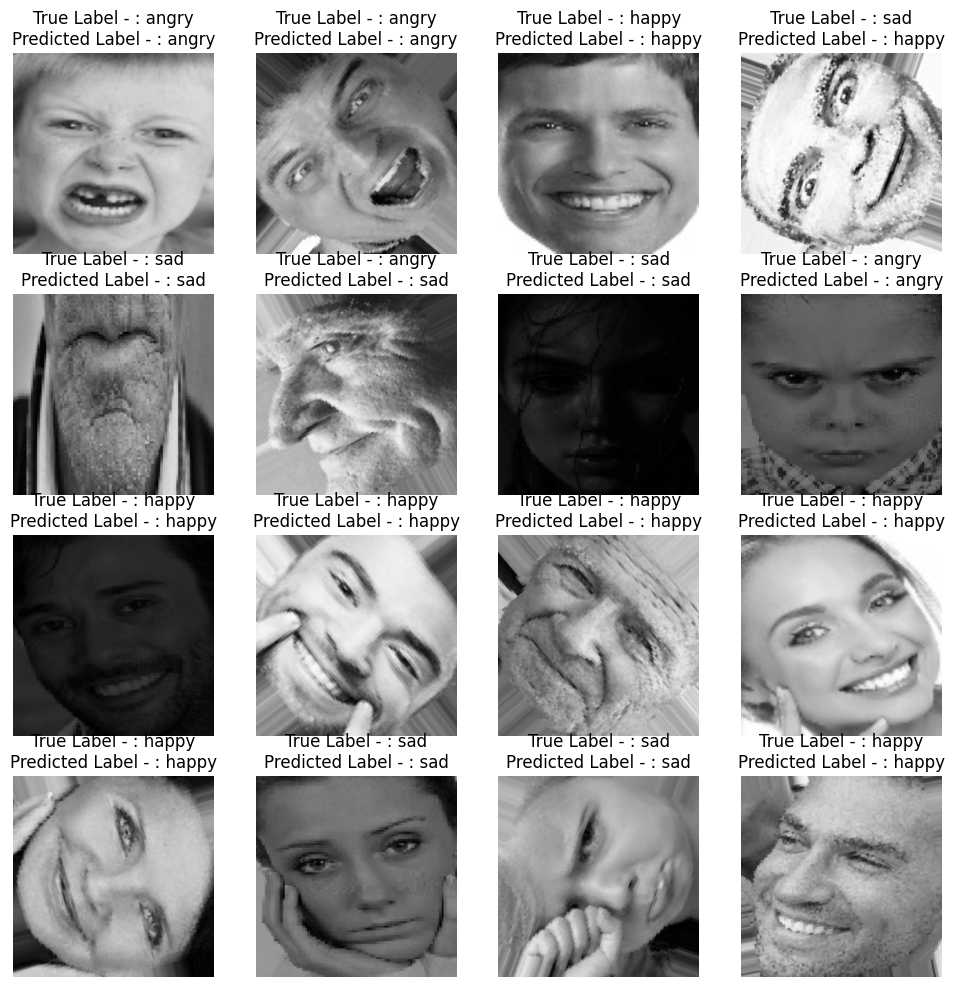

In [41]:
plt.figure(figsize = (12, 12))

for image, labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4, i+1)
        plt.imshow(image[i]/255.)
        plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = -1).numpy()] 
              + "\n" + "Predicted Label - : " 
              + CLASS_NAMES[int(tf.argmax(pretrained_model(tf.expand_dims(image[i], axis = 0)), axis =-1).numpy()[0])] )
        plt.axis("off")

In [ ]:
9/16

0.5625

# Confusion Matrix

In [43]:
predicted = []
labels = []

for im, label in validation_dataset:
    predicted.append(pretrained_model(im))
    labels.append(label.numpy())

    

KeyboardInterrupt: 

In [ ]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[2 0 1 ... 1 1 2]
[1 0 1 ... 1 1 2]


In [ ]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[269 124 122]
 [ 51 837 118]
 [ 90 205 462]]


Text(70.72222222222221, 0.5, 'Predicted')

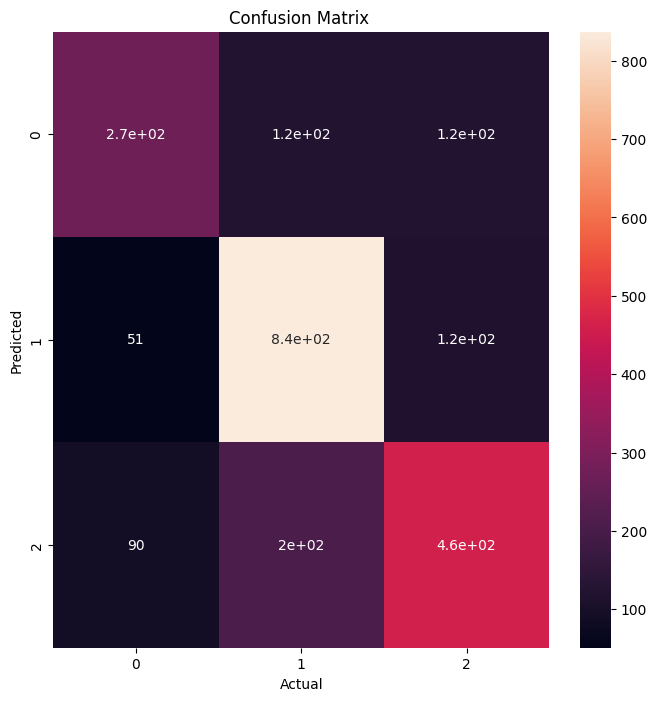

In [ ]:


cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize = (8,8))

sns.heatmap(cm, annot = True)
plt.title("Confusion Matrix ")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Visualization

Feature map Visualization


In [28]:
vgg_backbone = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"],3),
)

In [29]:
vgg_backbone.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [30]:
def is_conv(layer_name):
    if "conv" in layer_name:
        return True
    else:
        return False

In [34]:
feature_maps = [layer.output for layer in vgg_backbone.layers[1:] if is_conv(layer.name)]

feature_map_model = Model(
    inputs = vgg_backbone.input,
    outputs = feature_maps
)

feature_map_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [36]:
test_image = cv2.imread("D:/jupyter_codes/humans_emotion_detection/dataset/EmotionsDataset/data/happy/4.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

f_maps = feature_map_model.predict(im)

1/1 [==============================] - 1s 506ms/step


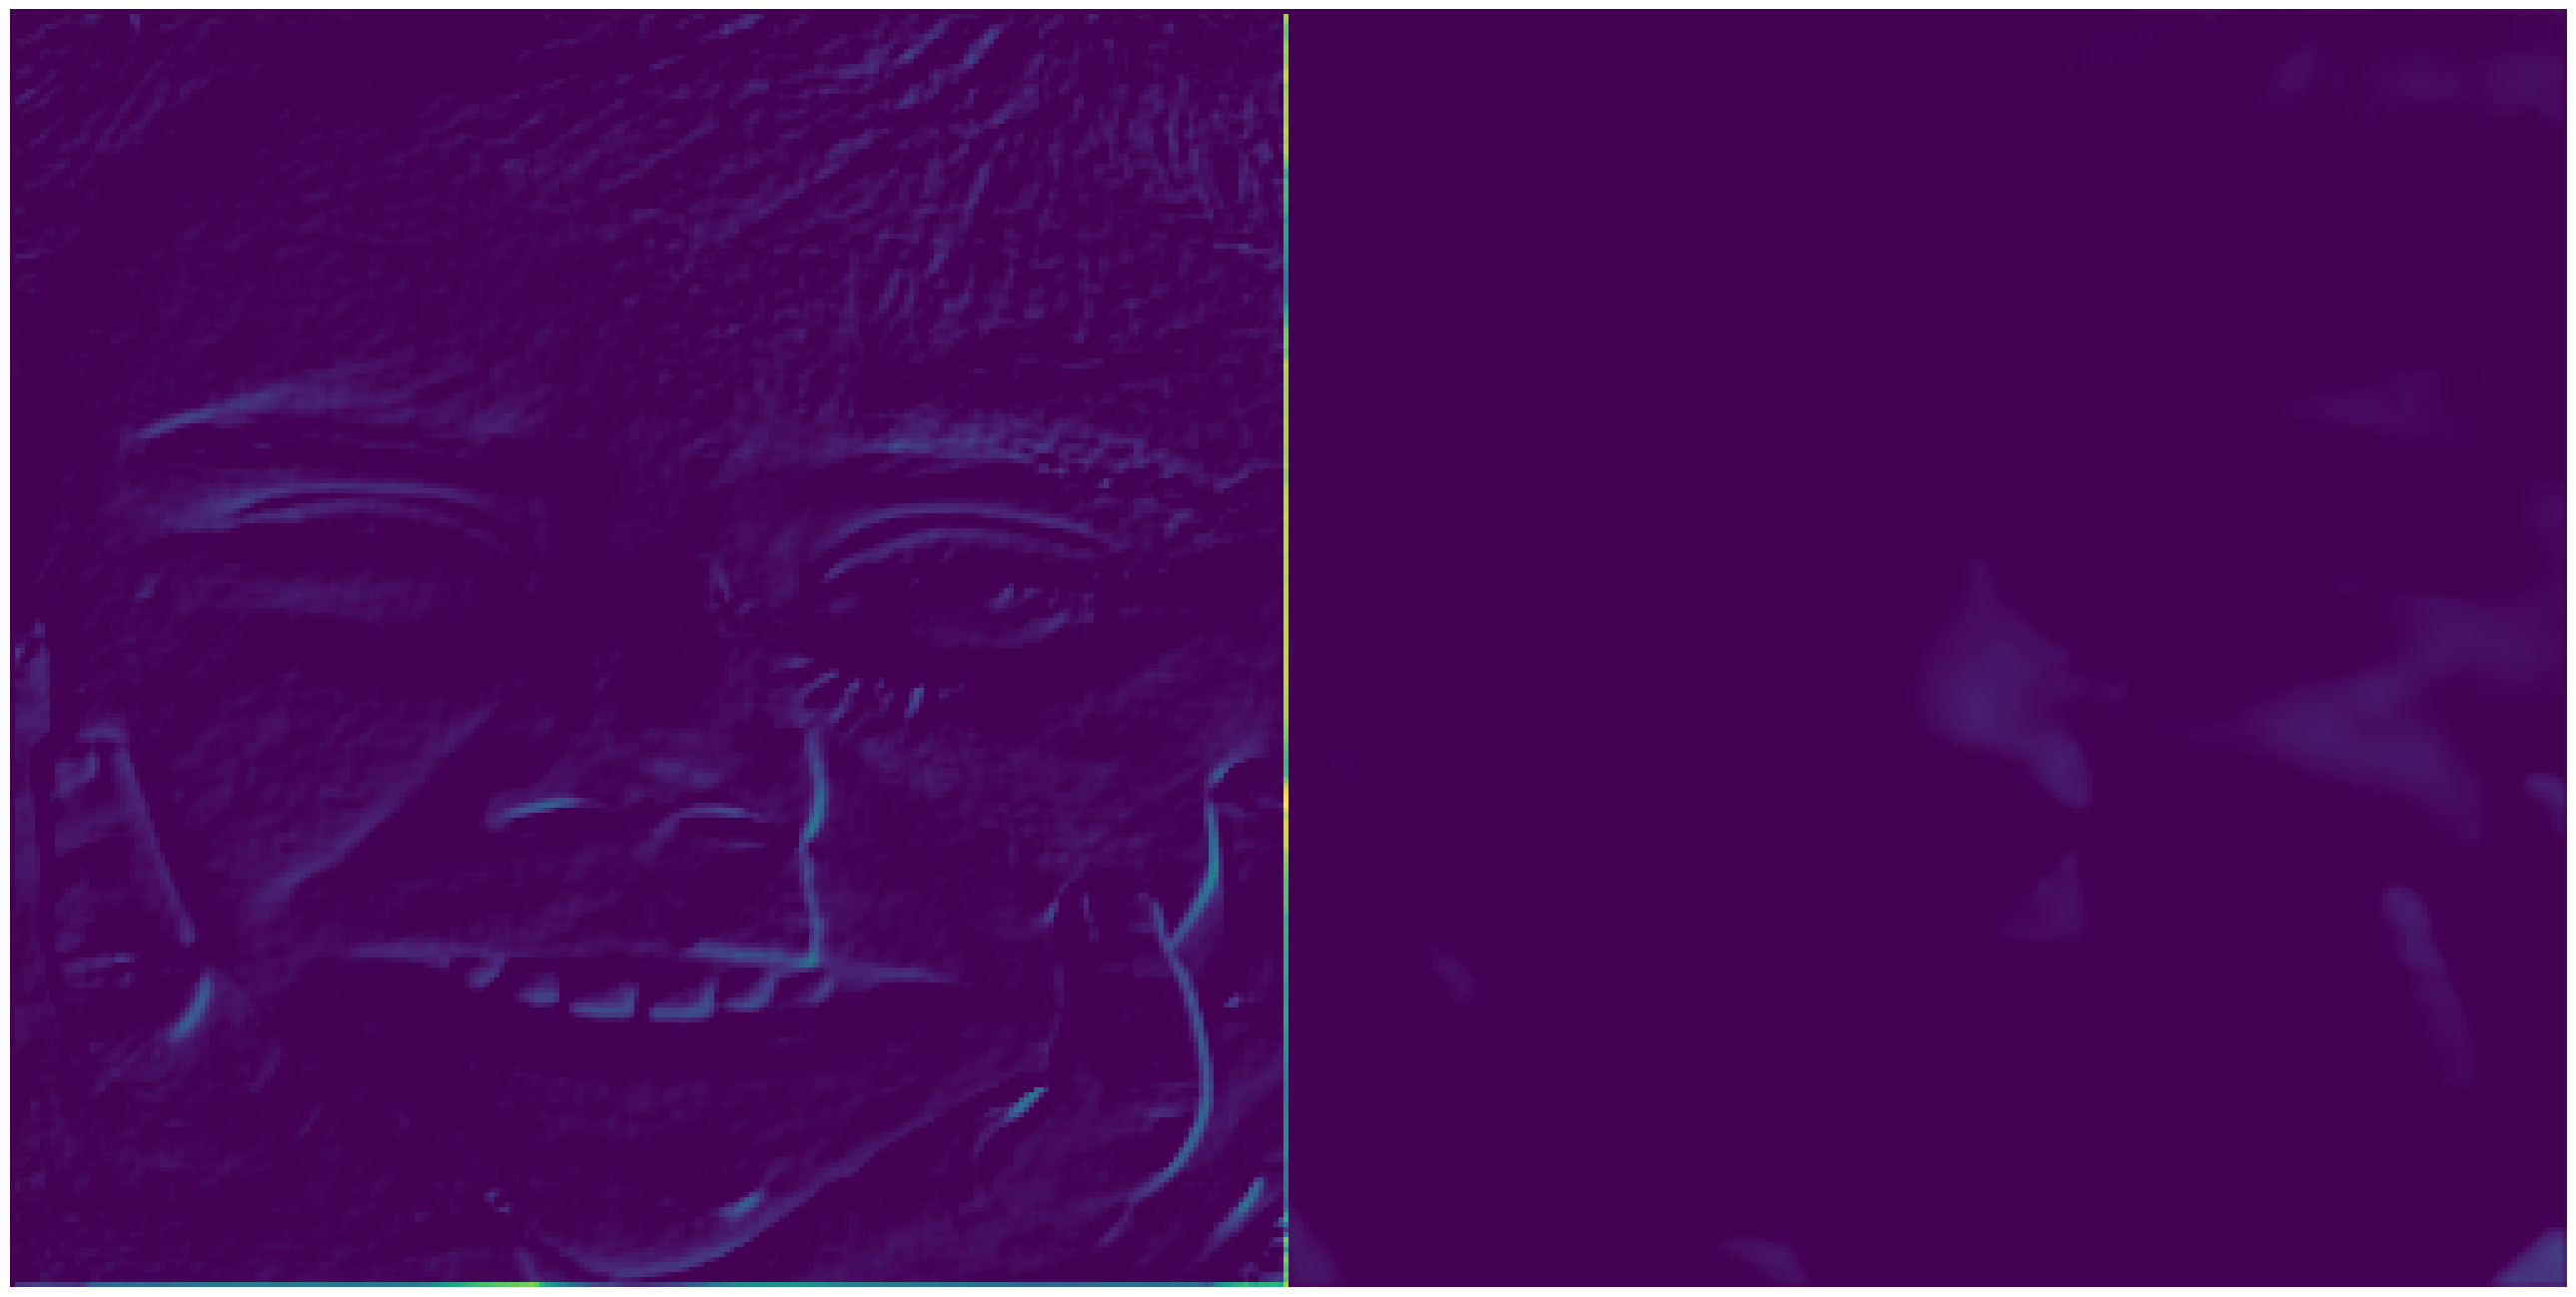

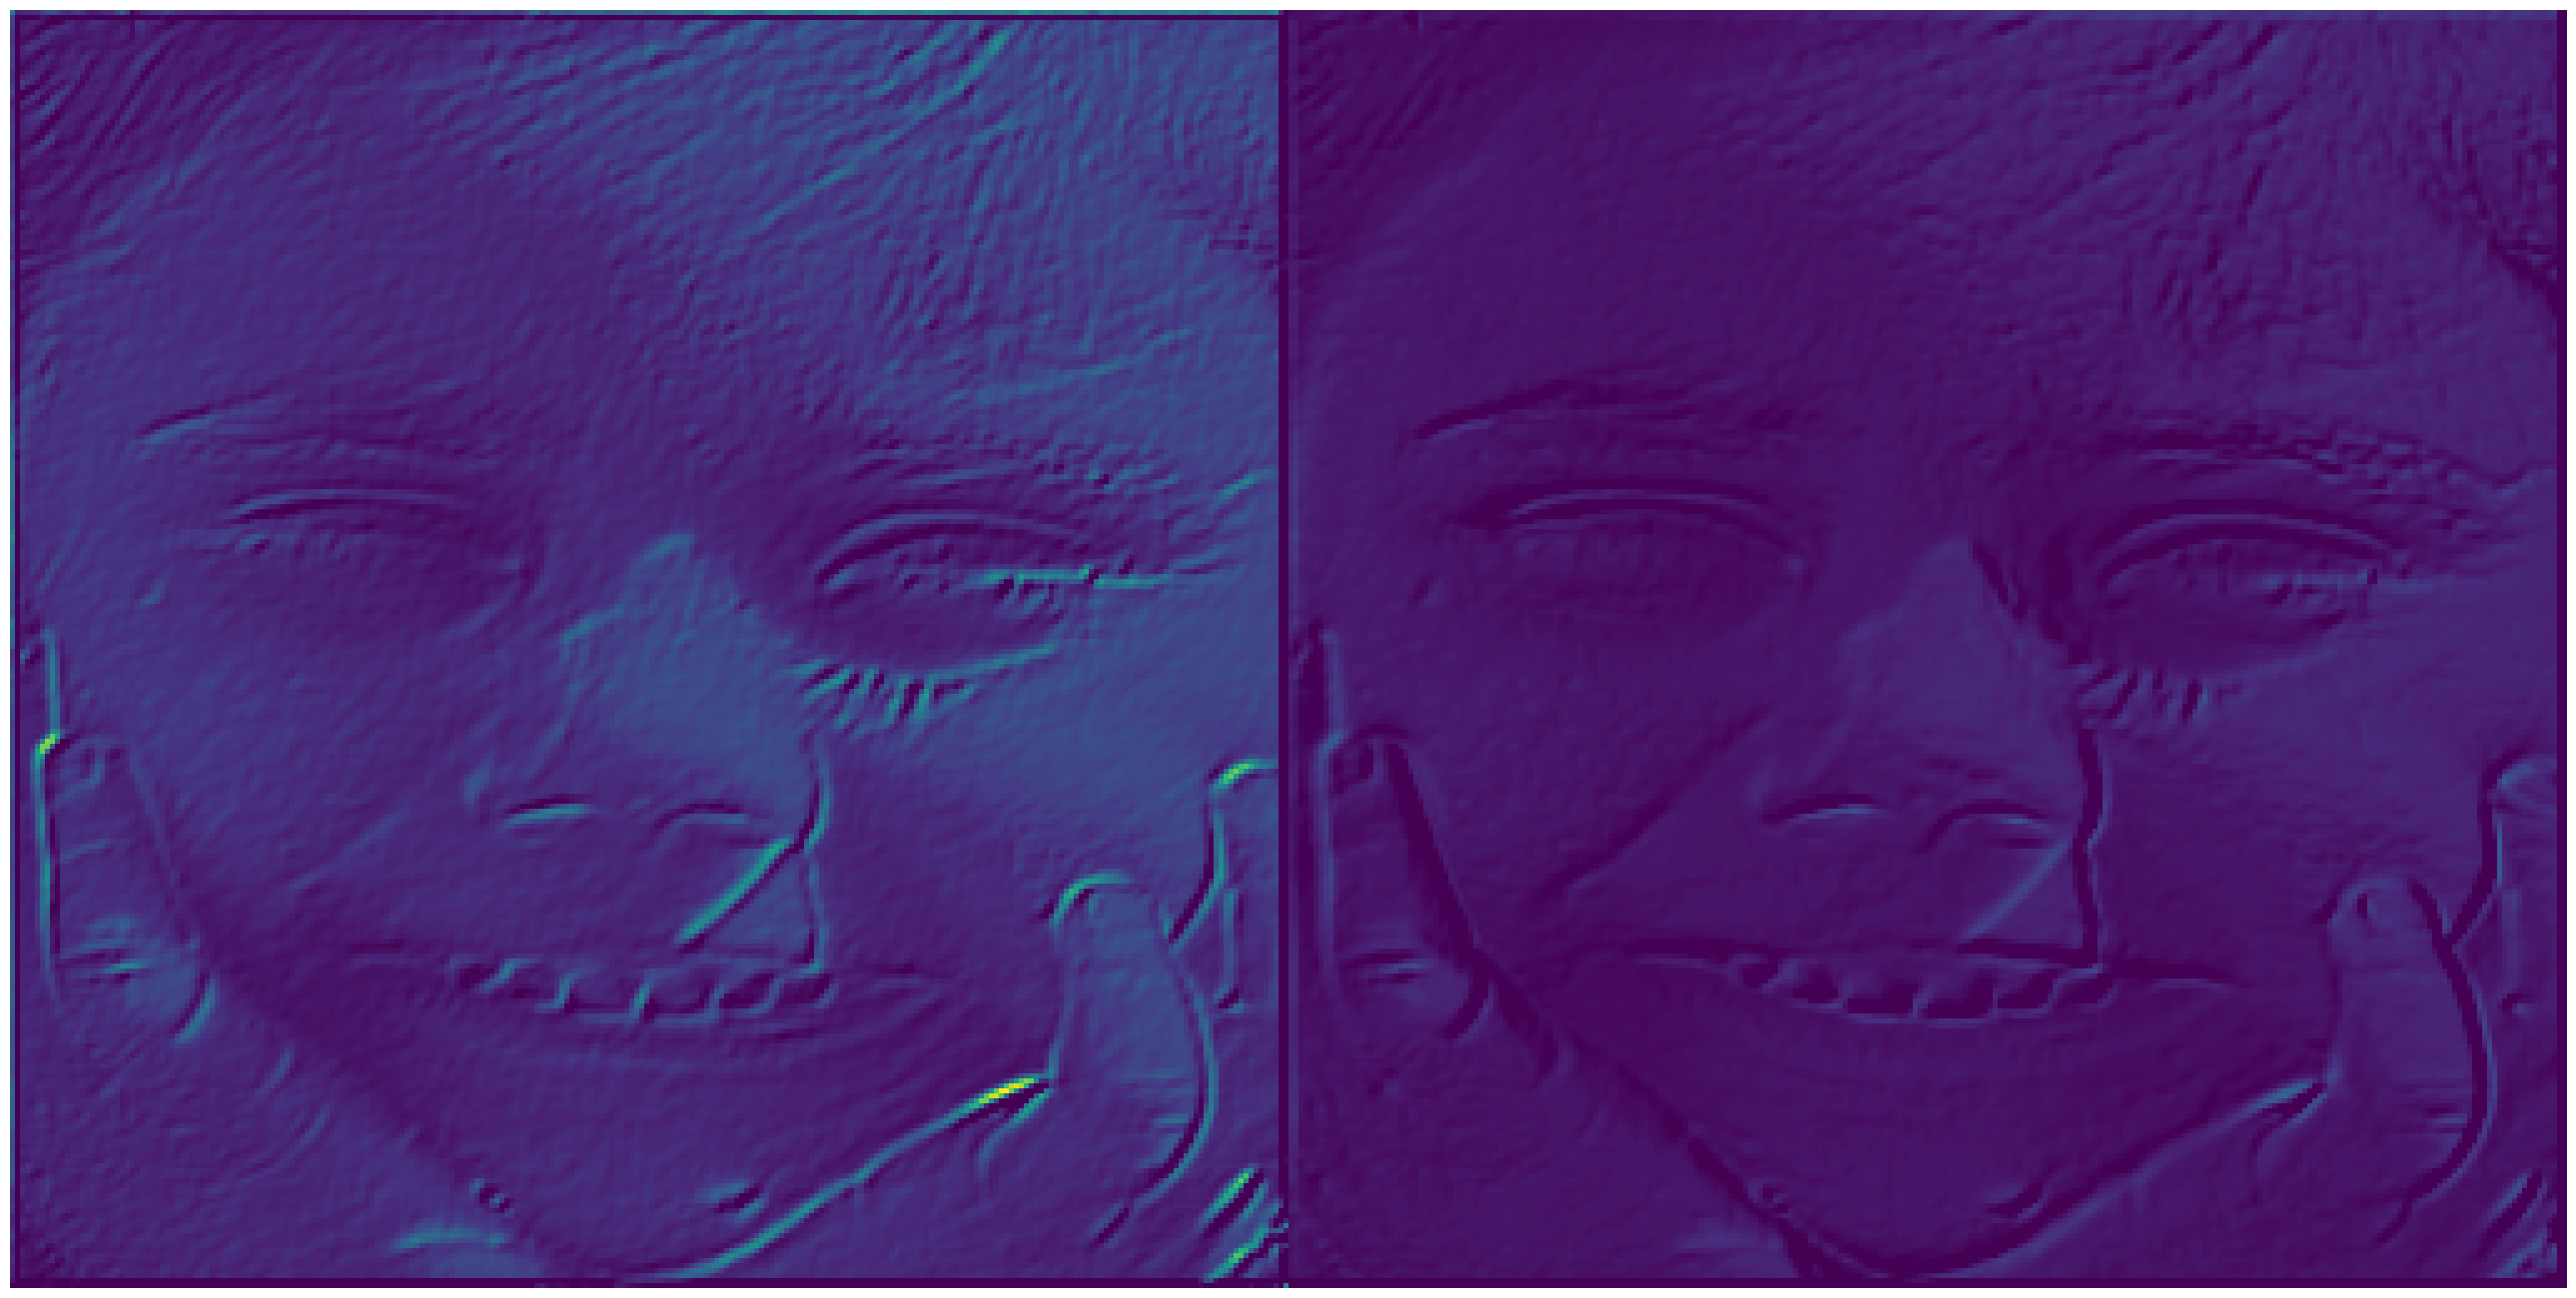

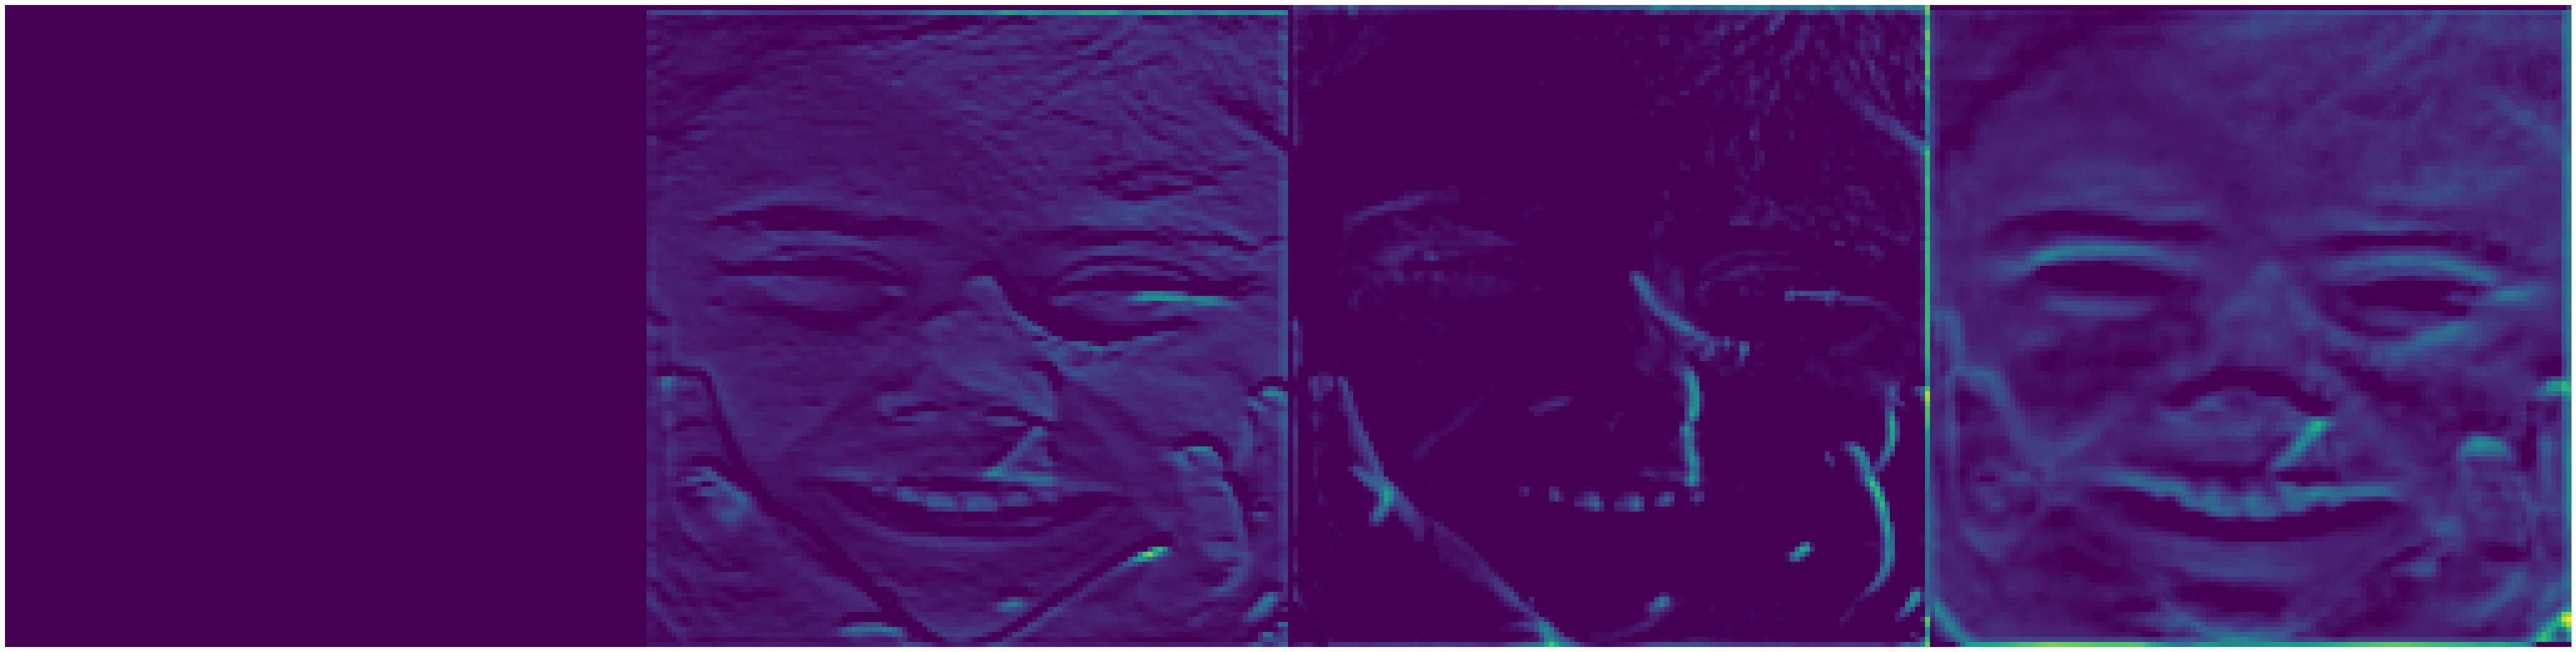

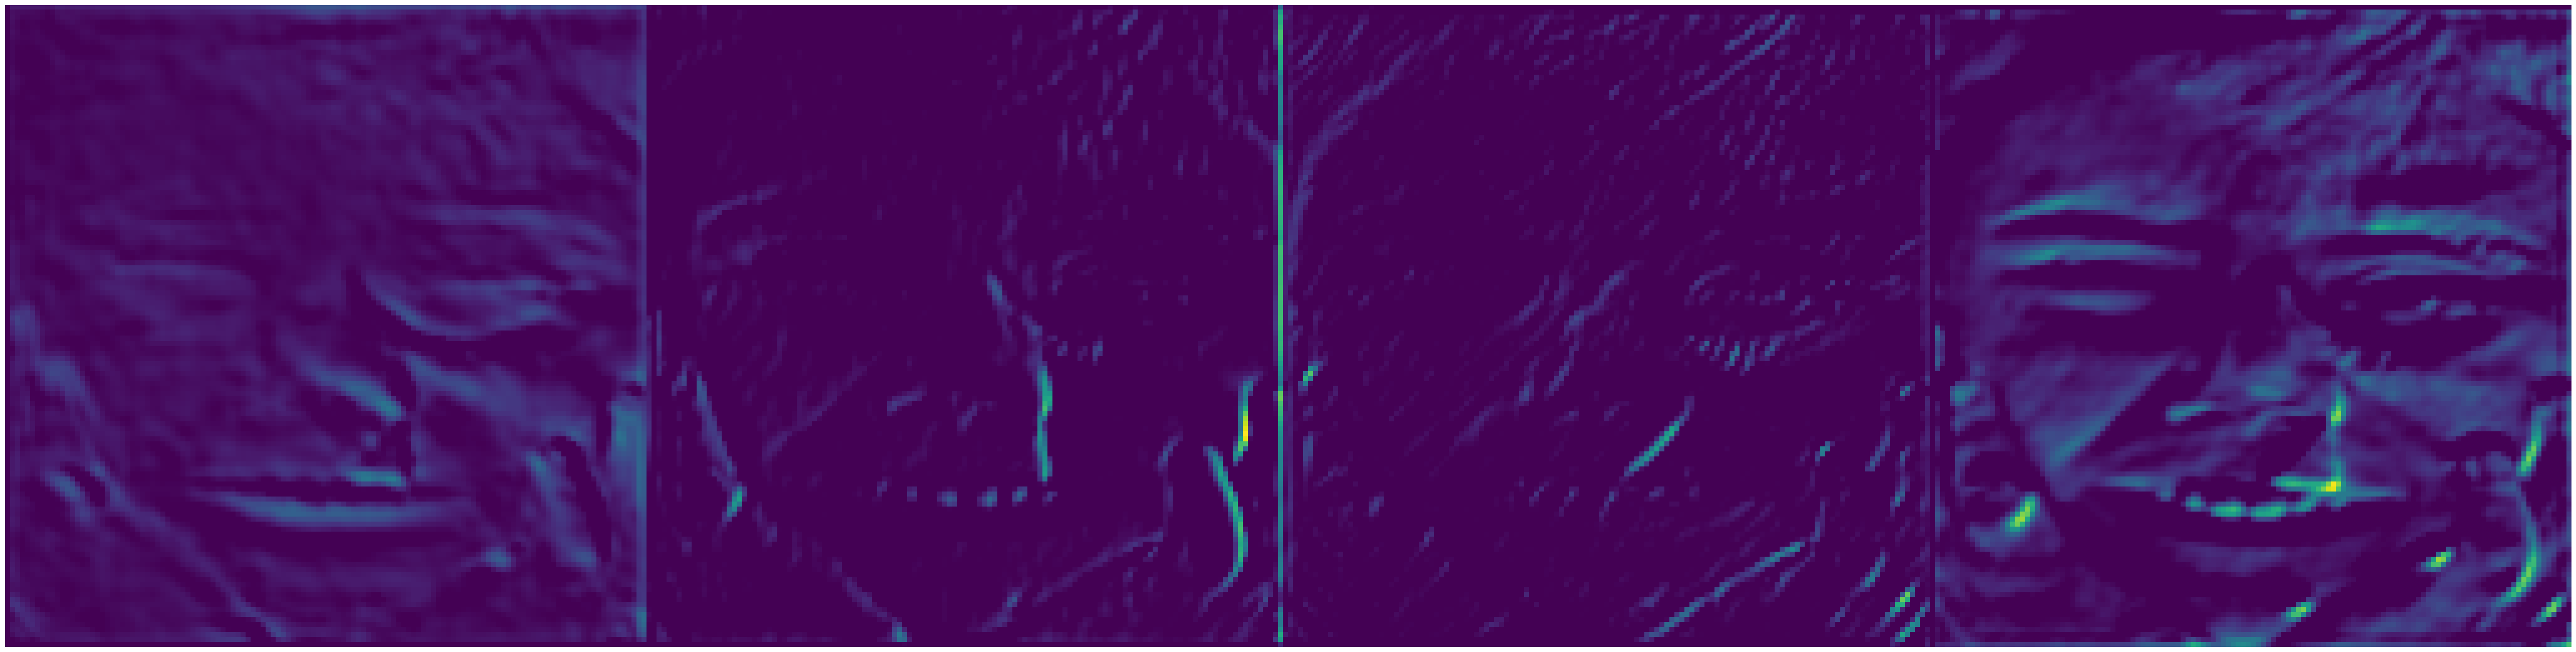

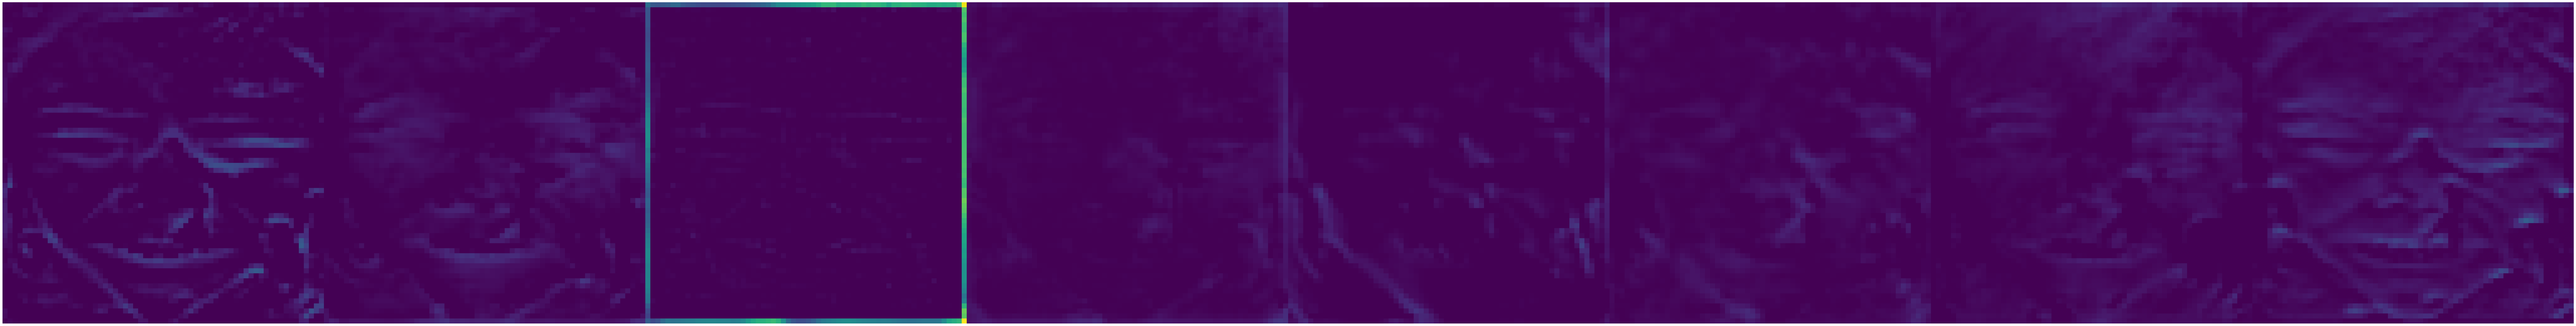

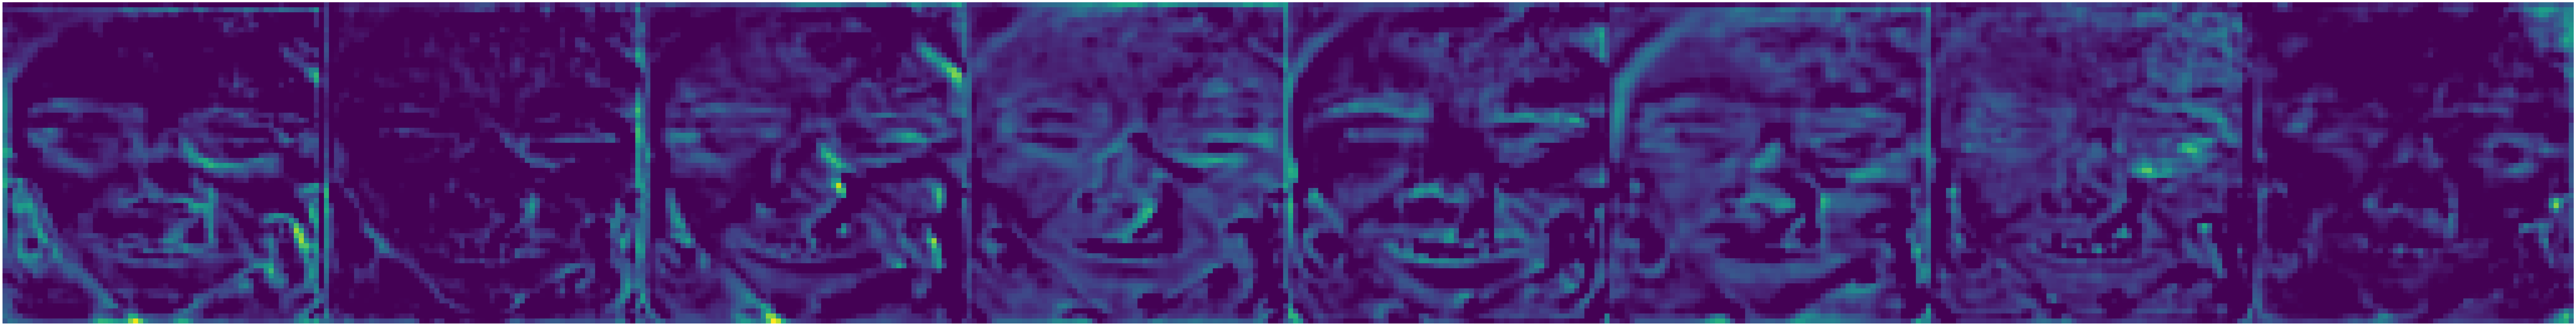

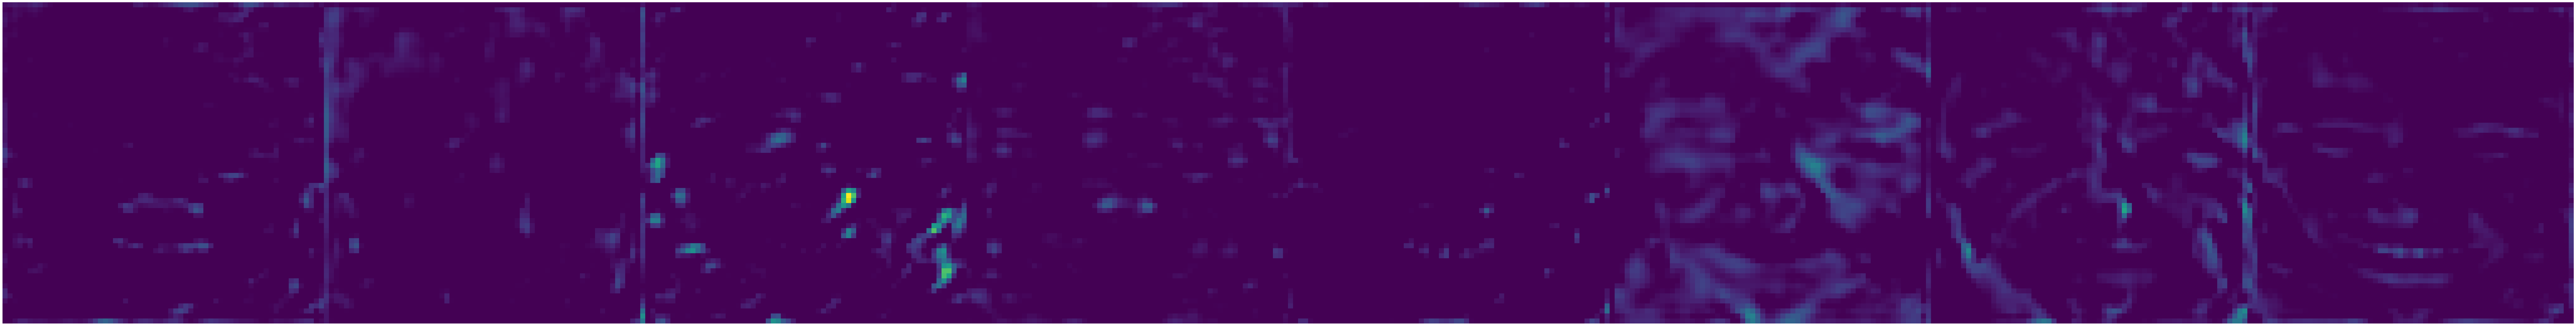

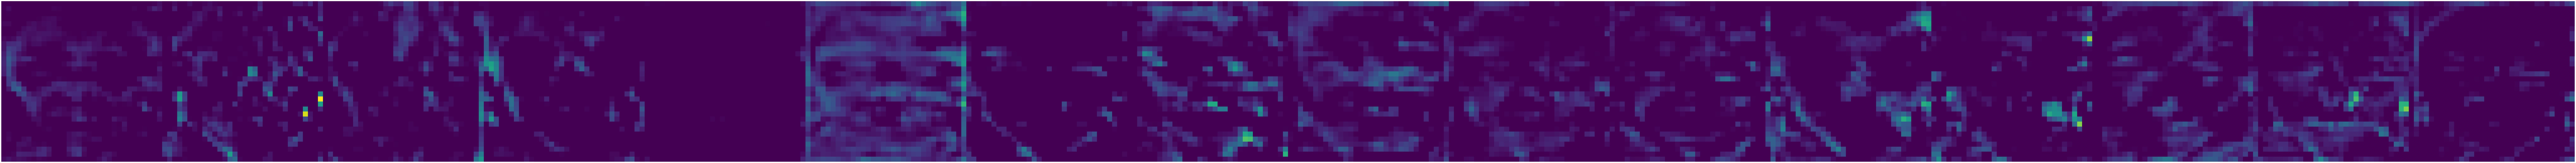

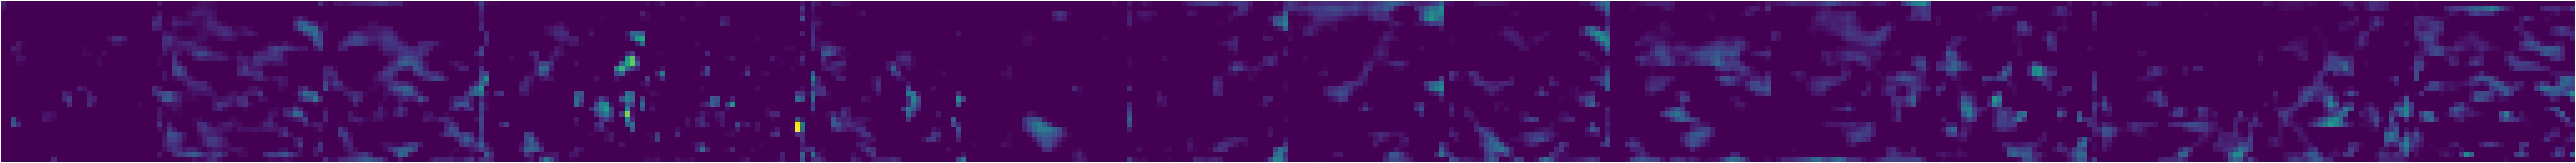

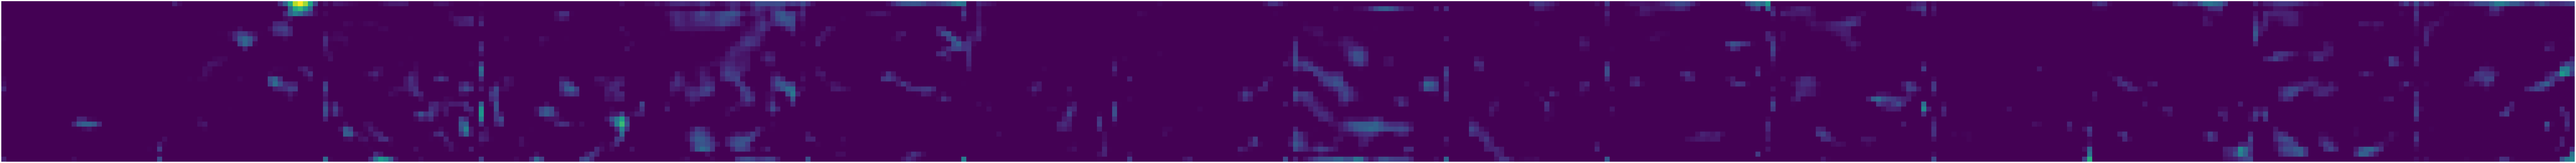

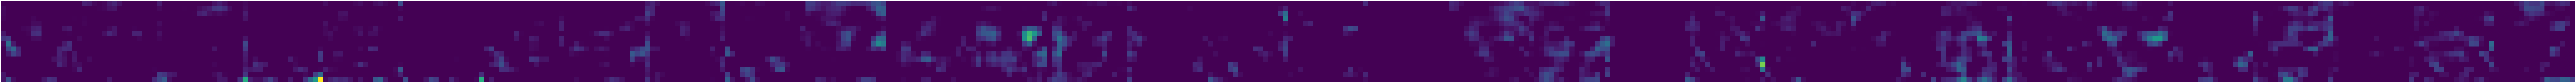

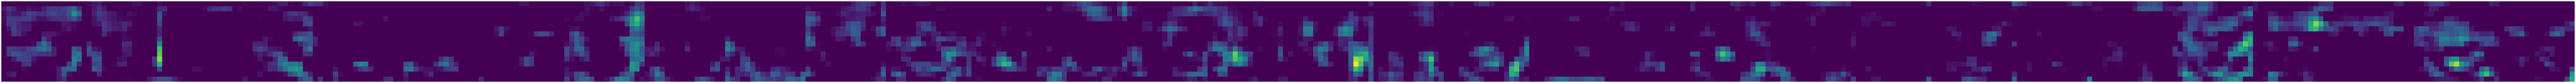

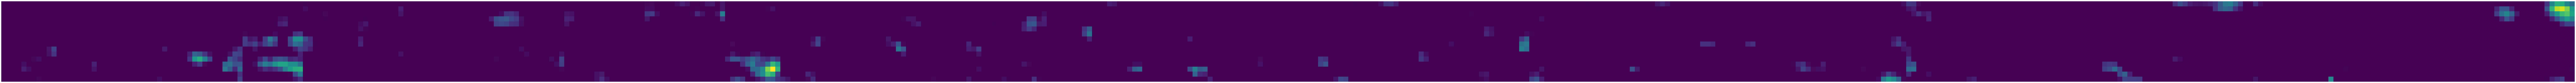

In [37]:
for i in range(len(f_maps)):
    plt.figure(figsize= (256,256))
    f_size = f_maps[i].shape[1]
    n_channels =f_maps[i].shape[3]
    joint_maps = np.ones((f_size, f_size*n_channels))

    axs = plt.subplot(len(f_maps), 1, i+1)
    for j in range(n_channels):
        joint_maps[:, f_size*j:f_size*(j+1)]  = f_maps[i][..., j]

    plt.imshow(joint_maps[:,0:512])
    plt.axis("off")

Grad Cam Method

In [ ]:
backbone = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )
backbone.trainable=False

In [ ]:
x = backbone.output

x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

pretrained_model = Model(backbone.inputs, output)
pretrained_model.summary()

In [ ]:
pretrained_model.load_weights('/content/drive/MyDrive/Bang/mobilenet_human_emotions.h5')

In [ ]:
img_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/202291.jpg"

In [ ]:
test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

In [ ]:
preds = pretrained_model.predict(img_array)

In [ ]:
np.argmax(preds[0])

In [ ]:
last_conv_layer_name = "top_activation"
last_conv_layer = pretrained_model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(pretrained_model.inputs, last_conv_layer.output)

In [ ]:
classifier_layer_names = [
 "global_average_pooling2d",
 "dense",
 "dense_1",
 "dense_2"
]

In [ ]:
classifier_input = Input(shape=(8,8,2048))
x = classifier_input 
for layer_name in classifier_layer_names:
 x = pretrained_model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
with tf.GradientTape() as tape:
  last_conv_layer_output = last_conv_layer_model(img_array)
  preds = classifier_model(last_conv_layer_output)
  top_pred_index = tf.argmax(preds[0])
  print(top_pred_index)
  top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [ ]:
grads.shape

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

In [ ]:
print(pooled_grads.shape)

In [ ]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(2048):
  last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [ ]:
print(last_conv_layer_output.shape)

In [ ]:
heatmap = np.sum(last_conv_layer_output, axis=-1)

In [ ]:
heatmap=tf.nn.relu(heatmap)
plt.matshow(heatmap)

In [ ]:
resized_heatmap=cv2.resize(np.array(heatmap),(256,256))
plt.matshow(resized_heatmap*255+img_array[0,:,:,0]/255)